<a href="https://colab.research.google.com/github/marianabetine/horse-survival-dataset/blob/main/2024_DM_Trabalho_BaseHorses.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Trabalho Final de Data Mining**

Este trabalho foi realizado para a disciplina de Data Mining da Pós-Graduação em Ciência de Dados e Inteligência Artificial da PUC-RJ.

O objetivo deste trabalho é desenvolver um modelo que seja capaz de prever a sobrevivência de cavalos com base em informações sobre suas condições médicas. Para alcançar esse objetivo, foi utilizada a técnica de Classificação de Data Mining. Essa escolha se justifica pelo fato da variável alvo ser categórica, representando se o cavalo morreu, sobreviveu ou foi submetido à eutanásia.

A base do trabalho já veio separada em treino e teste. São os arquivos:
*   horse.csv - o conjunto de dados de treinamento
*   horseTest.csv -  o conjunto de dados de teste

##**Importação das Bibliotecas e da Base de Dados**

In [ ]:
# Instalação de Bibliotecas que não estão pré-insataladas no Google Colab
!pip install rich

In [ ]:
# Importação dos pacotes
import pandas                 as pd
import numpy                  as np
import random

# Renderização de Texto
from rich                     import print                     # Texto
from collections              import defaultdict               # Padrão de dicionário
from tabulate                 import tabulate                  # Formatação de Tabelas

# Gráficos
import matplotlib.pyplot      as plt
import seaborn                as sns
import plotly.express         as px
import missingno              as msno                           # Missing Values

# Pré-processamento
from sklearn.compose          import make_column_transformer
from sklearn.preprocessing    import OneHotEncoder              # One Hot Encoding
from sklearn.preprocessing    import LabelEncoder               # Label Encoding
from sklearn.preprocessing    import MinMaxScaler               # Normalização
from sklearn.dummy            import DummyClassifier            # Modelo Dummy
from sklearn.preprocessing    import StandardScaler             # Padronização
from imblearn.over_sampling   import SMOTE                      # Balanceamento / Oversampling

# Árvore de Decisão
from sklearn.tree             import DecisionTreeClassifier
from sklearn.tree             import plot_tree

# KNN
from sklearn.neighbors        import KNeighborsClassifier

# Regressão Logística Multinomial (RLM)
from sklearn.linear_model     import LogisticRegression

# PCA
from sklearn.decomposition    import PCA

# Random Florest
from sklearn.ensemble         import RandomForestClassifier

# Matriz de Confusão
from sklearn.metrics          import confusion_matrix

# Métricas de Avaliação
from sklearn.metrics          import cohen_kappa_score          # Kappa
from sklearn.metrics          import accuracy_score             # Acurácia
from sklearn.metrics          import f1_score                   # F1-Score
from sklearn.metrics          import recall_score               # Recall
from sklearn.metrics          import precision_score            # Precisão
from sklearn.metrics          import classification_report      # Precisão, Recall, F1-Score e Suporte
from sklearn.model_selection  import cross_val_score            # Validação Cruzada
from sklearn.model_selection  import KFold                      # Validação Cruzada
from sklearn.model_selection  import GridSearchCV               # Hiperparâmetros
from scipy.stats              import chi2_contingency           # Tabela de Contigência

# Seed para reprodução de resultados
seed = 1
random.seed(seed)
np.random.seed(seed)

In [ ]:
# Importar a base de dados
data = pd.read_csv('horse.csv')         #Base de treino
test = pd.read_csv('horseTest.csv')     #Base de teste

##**Análise Exploratória dos Dados**

###*Características da base de dados*

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 28 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   surgery                299 non-null    object 
 1   age                    299 non-null    object 
 2   hospital_number        299 non-null    int64  
 3   rectal_temp            239 non-null    float64
 4   pulse                  275 non-null    float64
 5   respiratory_rate       241 non-null    float64
 6   temp_of_extremities    243 non-null    object 
 7   peripheral_pulse       230 non-null    object 
 8   mucous_membrane        252 non-null    object 
 9   capillary_refill_time  267 non-null    object 
 10  pain                   244 non-null    object 
 11  peristalsis            255 non-null    object 
 12  abdominal_distention   243 non-null    object 
 13  nasogastric_tube       195 non-null    object 
 14  nasogastric_reflux     193 non-null    object 
 15  nasoga

In [ ]:
data.head()

surgery    age  hospital_number  rectal_temp  pulse  respiratory_rate  \
0      no  adult           530101         38.5   66.0              28.0   
1     yes  adult           534817         39.2   88.0              20.0   
2      no  adult           530334         38.3   40.0              24.0   
3     yes  young          5290409         39.1  164.0              84.0   
4      no  adult           530255         37.3  104.0              35.0   

  temp_of_extremities peripheral_pulse mucous_membrane capillary_refill_time  \
0                cool          reduced             NaN            more_3_sec   
1                 NaN              NaN   pale_cyanotic            less_3_sec   
2              normal           normal       pale_pink            less_3_sec   
3                cold           normal   dark_cyanotic            more_3_sec   
4                 NaN              NaN   dark_cyanotic            more_3_sec   

   ... packed_cell_volume total_protein abdomo_appearance abdomo_protein  \
0  ...               45.0           8.4               NaN            NaN   
1  ...               50.0          85.0            cloudy            2.0   
2  ...               33.0           6.7               NaN            NaN   
3  ...               48.0           7.2     serosanguious            5.3   
4  ...               74.0           7.4               NaN            NaN   

      outcome  surgical_lesion lesion_1 lesion_2  lesion_3  cp_data  
0        died               no    11300        0         0       no  
1  euthanized               no     2208        0         0       no  
2       lived               no        0        0         0      yes  
3        died              yes     2208        0         0      yes  
4        died               no     4300        0         0       no  

[5 rows x 28 columns]

In [ ]:
data.shape

(299, 28)

In [ ]:
#Análise dos atributos: tipo do dado, valores únicos de registros, contagem de registros total, porcentagem missing values

def summary(data):
    sum = pd.DataFrame(data.dtypes, columns=['dtypes'])
    sum['uniques'] = data.nunique().values
    sum['count'] = data.count().values

# Calcula a porcentagem de valores ausentes e ordena o DataFrame com base nessa porcentagem
    sum['missing%'] = (data.isna().sum() * 100) / len(data)
    sum.sort_values(by='missing%', ascending=False, inplace=True)

    return sum

# Chama a função summary e aplica um estilo de gradiente de cor
summary(data).style.background_gradient(cmap='BuGn')

###*Análise dos dados categóricos*

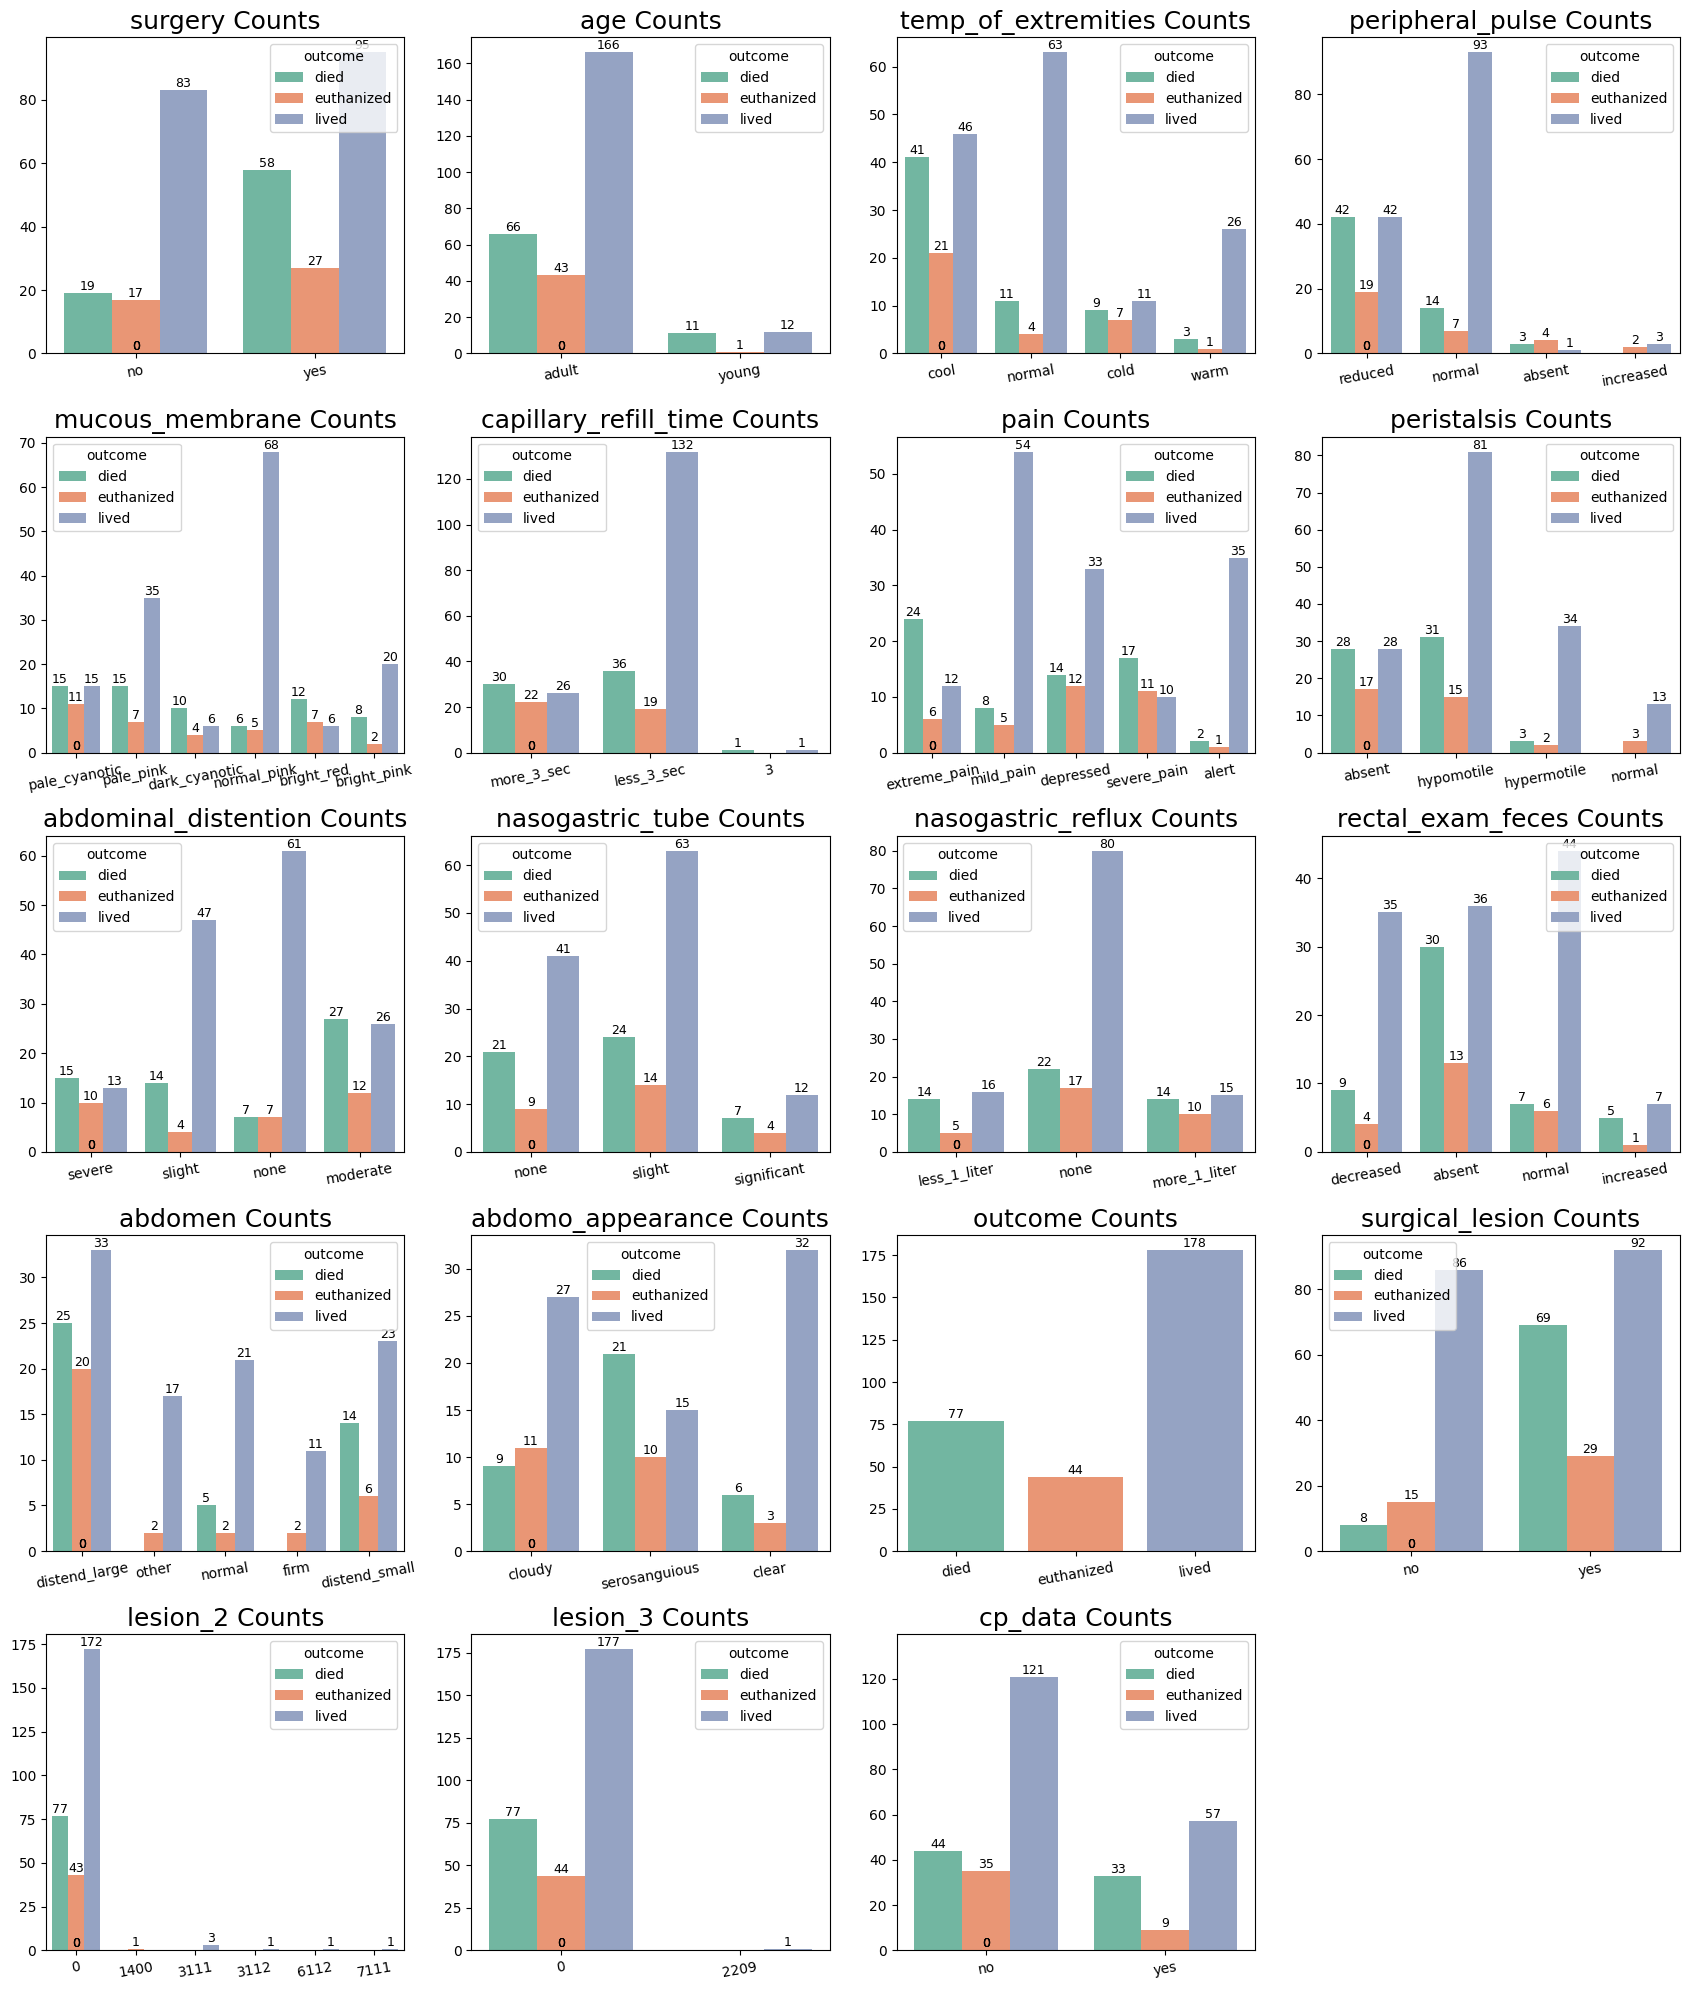

In [ ]:
# Análise dos atributos em relação a variável alvo (outcome)

# Obtendo a paleta de cores
colors = sns.color_palette("Set2")

# Definindo cores específicas para algumas classes
specific_colors = {'died': colors[2], 'euthanized': colors[1], 'lived': colors[0]}

# Mapeamento de cores para cada classe de outcome
default_color = colors[6]  # Definindo uma cor padrão para as demais classes


# Filtro para colunas com menos de 10 valores únicos
columns_cat = [column for column in data.columns if data[column].nunique() < 10]


# Contrução do gráfico
def plot_count(df,columns,n_cols,hue):

    n_rows = (len(columns) - 1) // n_cols + 1
    fig, ax = plt.subplots(n_rows, n_cols, figsize=(17, 4 * n_rows))
    ax = ax.flatten()

    for i, column in enumerate(columns):
        sns.countplot(data=df, x=column, ax=ax[i],hue=hue, palette=sns.color_palette("Set2", len(df[hue].unique())))

        # Títulos
        ax[i].set_title(f'{column} Counts', fontsize=18)
        ax[i].set_xlabel(None, fontsize=16)
        ax[i].set_ylabel(None, fontsize=16)
        ax[i].tick_params(axis='x', rotation=10)

        for p in ax[i].patches:
            value = int(p.get_height())
            ax[i].annotate(f'{value:.0f}', (p.get_x() + p.get_width() / 2, p.get_height()),
                           ha='center', va='bottom', fontsize=9)

    ylim_top = ax[i].get_ylim()[1]
    ax[i].set_ylim(top=ylim_top * 1.1)
    for i in range(len(columns), len(ax)):
        ax[i].axis('off')

    plt.tight_layout()
    plt.show()

plot_count(data,columns_cat,4,'outcome')

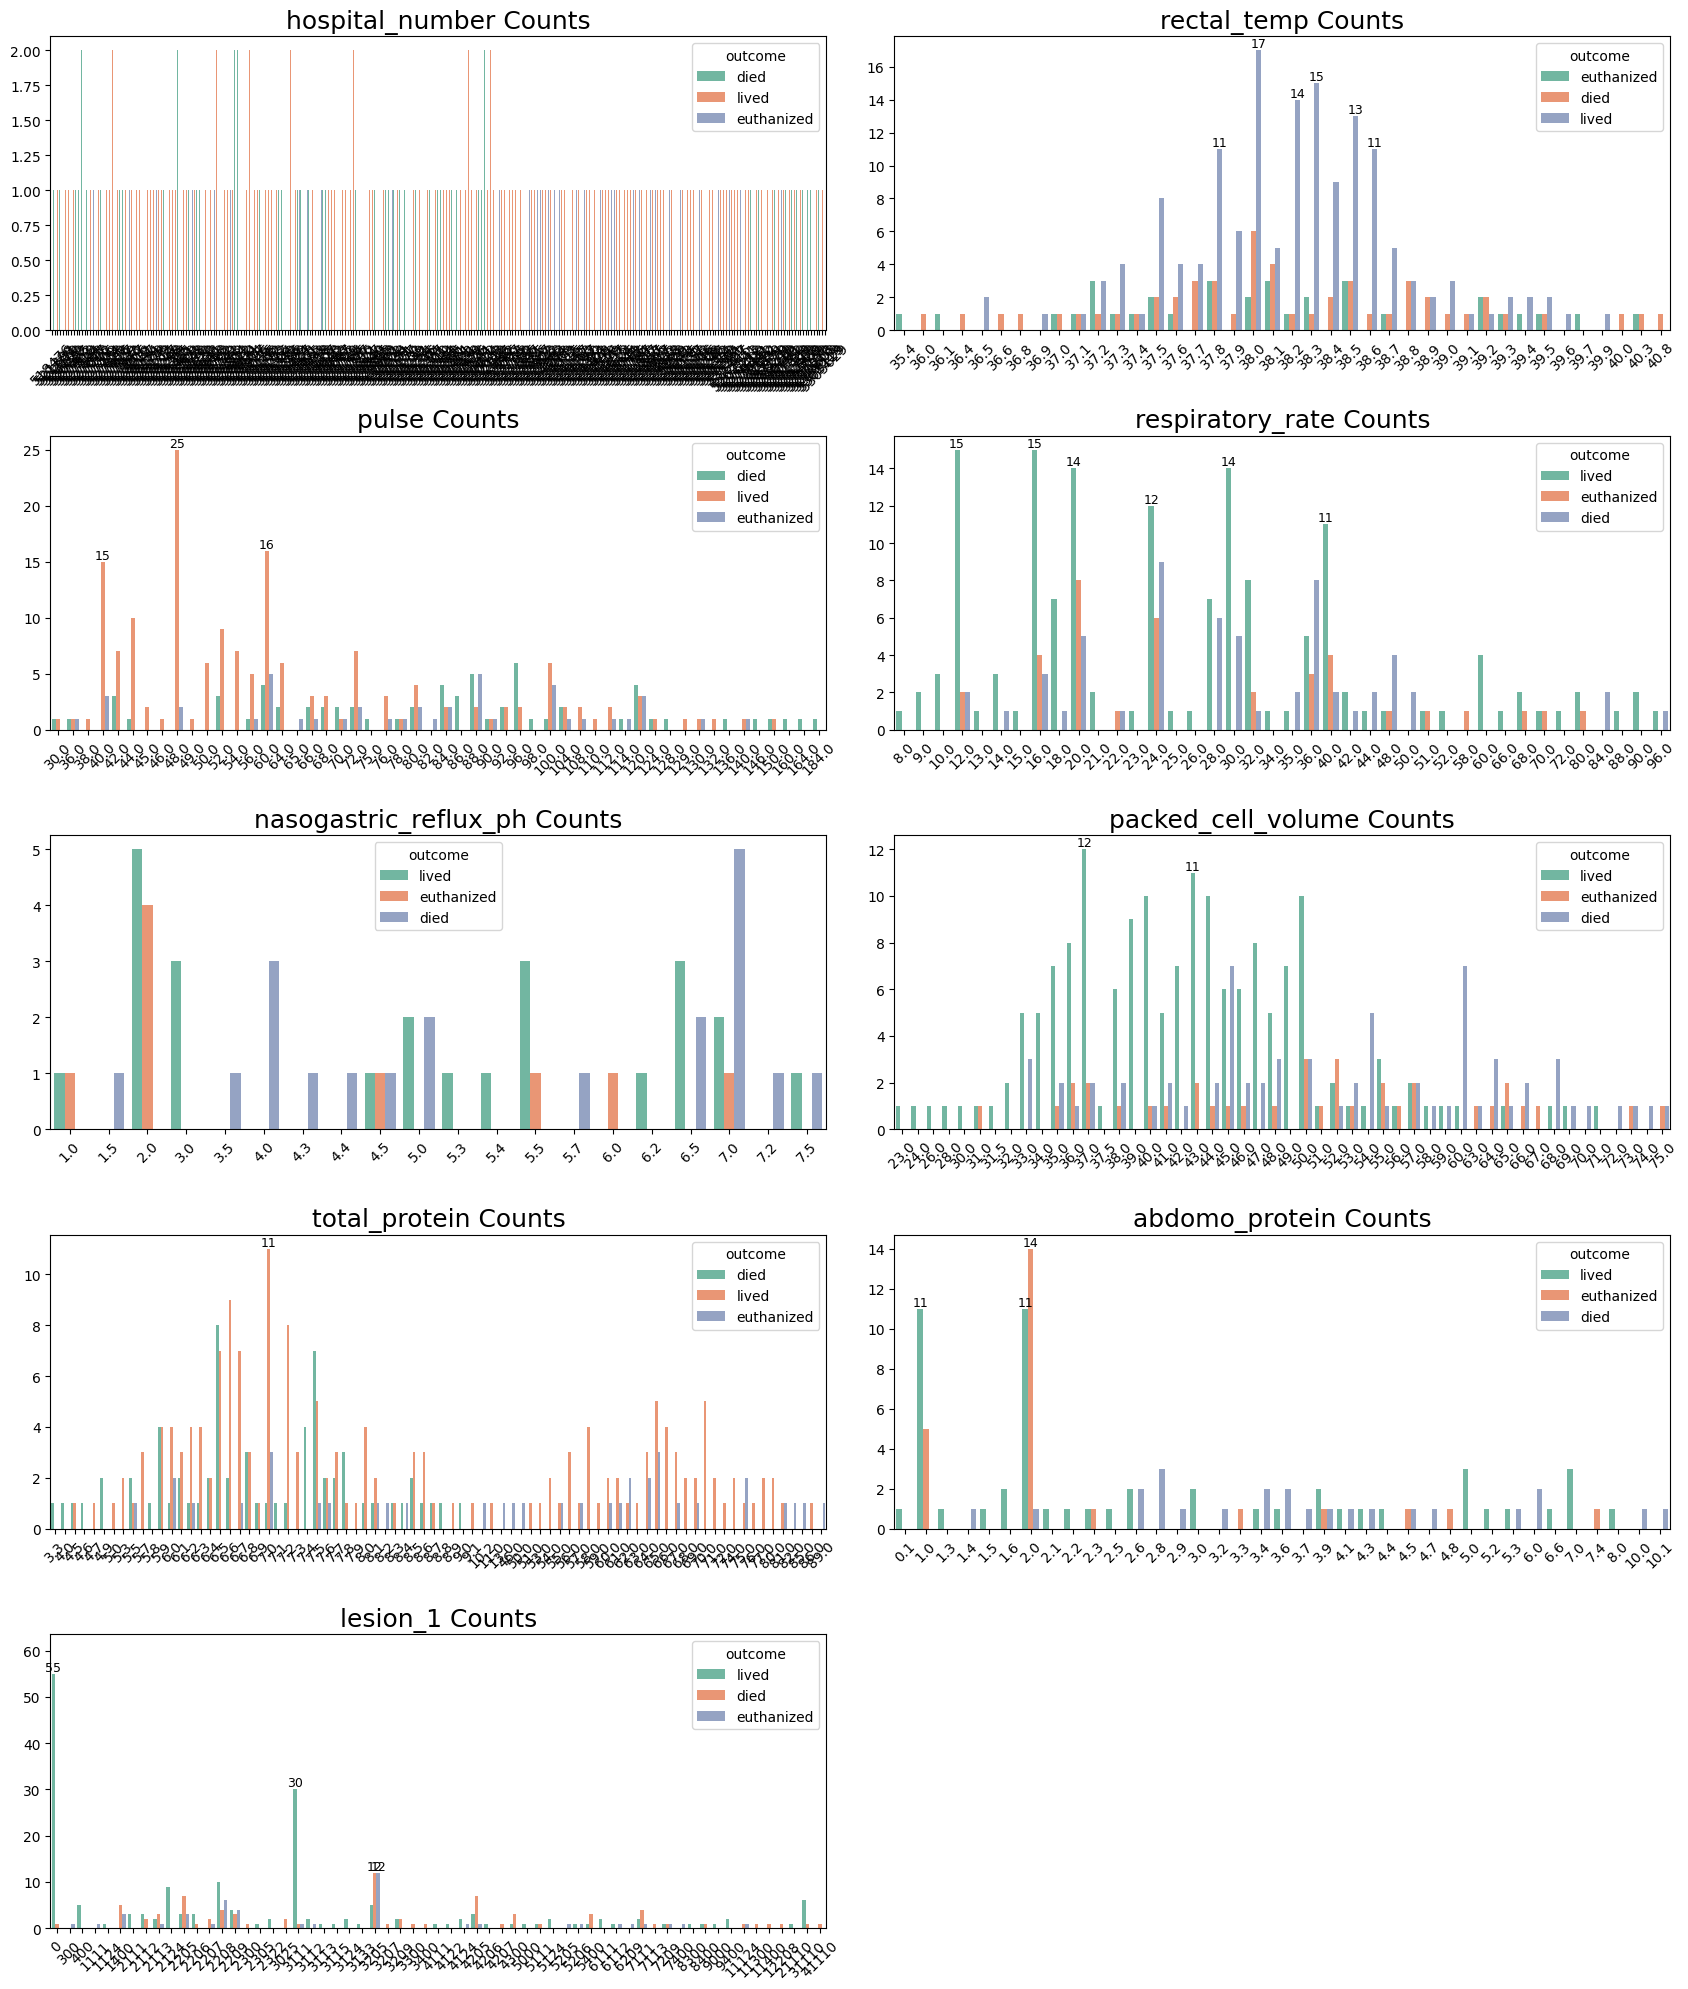

In [ ]:
# Filtro para colunas com mais de 10 valores únicos
columns_cat_10mais = [column for column in data.columns if data[column].nunique() > 10]


# Construção do gráfico
def plot_count(df, columns, n_cols, hue=None):
    n_rows = (len(columns) - 1) // n_cols + 1
    fig, ax = plt.subplots(n_rows, n_cols, figsize=(17, 4 * n_rows))
    ax = ax.flatten()

    for i, column in enumerate(columns):
        sns.countplot(data=df, x=column, ax=ax[i], hue=hue, palette=sns.color_palette("Set2", len(df[hue].unique())))

        # Títulos
        ax[i].set_title(f'{column} Counts', fontsize=18)
        ax[i].set_xlabel(None, fontsize=16)
        ax[i].set_ylabel(None, fontsize=16)
        ax[i].tick_params(axis='x', rotation=45)  # Rotacionar rótulos do eixo x para melhor legibilidade

        # Ajuste dos rótulos nos números
        for p in ax[i].patches:
            value = int(p.get_height())
            if value > 10:  # Apenas rotule valores maiores que 10
                ax[i].annotate(f'{value:.0f}', (p.get_x() + p.get_width() / 2, p.get_height()),
                               ha='center', va='bottom', fontsize=9)

    ylim_top = ax[i].get_ylim()[1]
    ax[i].set_ylim(top=ylim_top * 1.1)

    # Remover eixo se sobrarem espaços em branco
    for i in range(len(columns), len(ax)):
        ax[i].axis('off')

    plt.tight_layout()
    plt.show()

plot_count(data, columns_cat_10mais, 2, 'outcome')  # Ajuste o número de colunas para 2

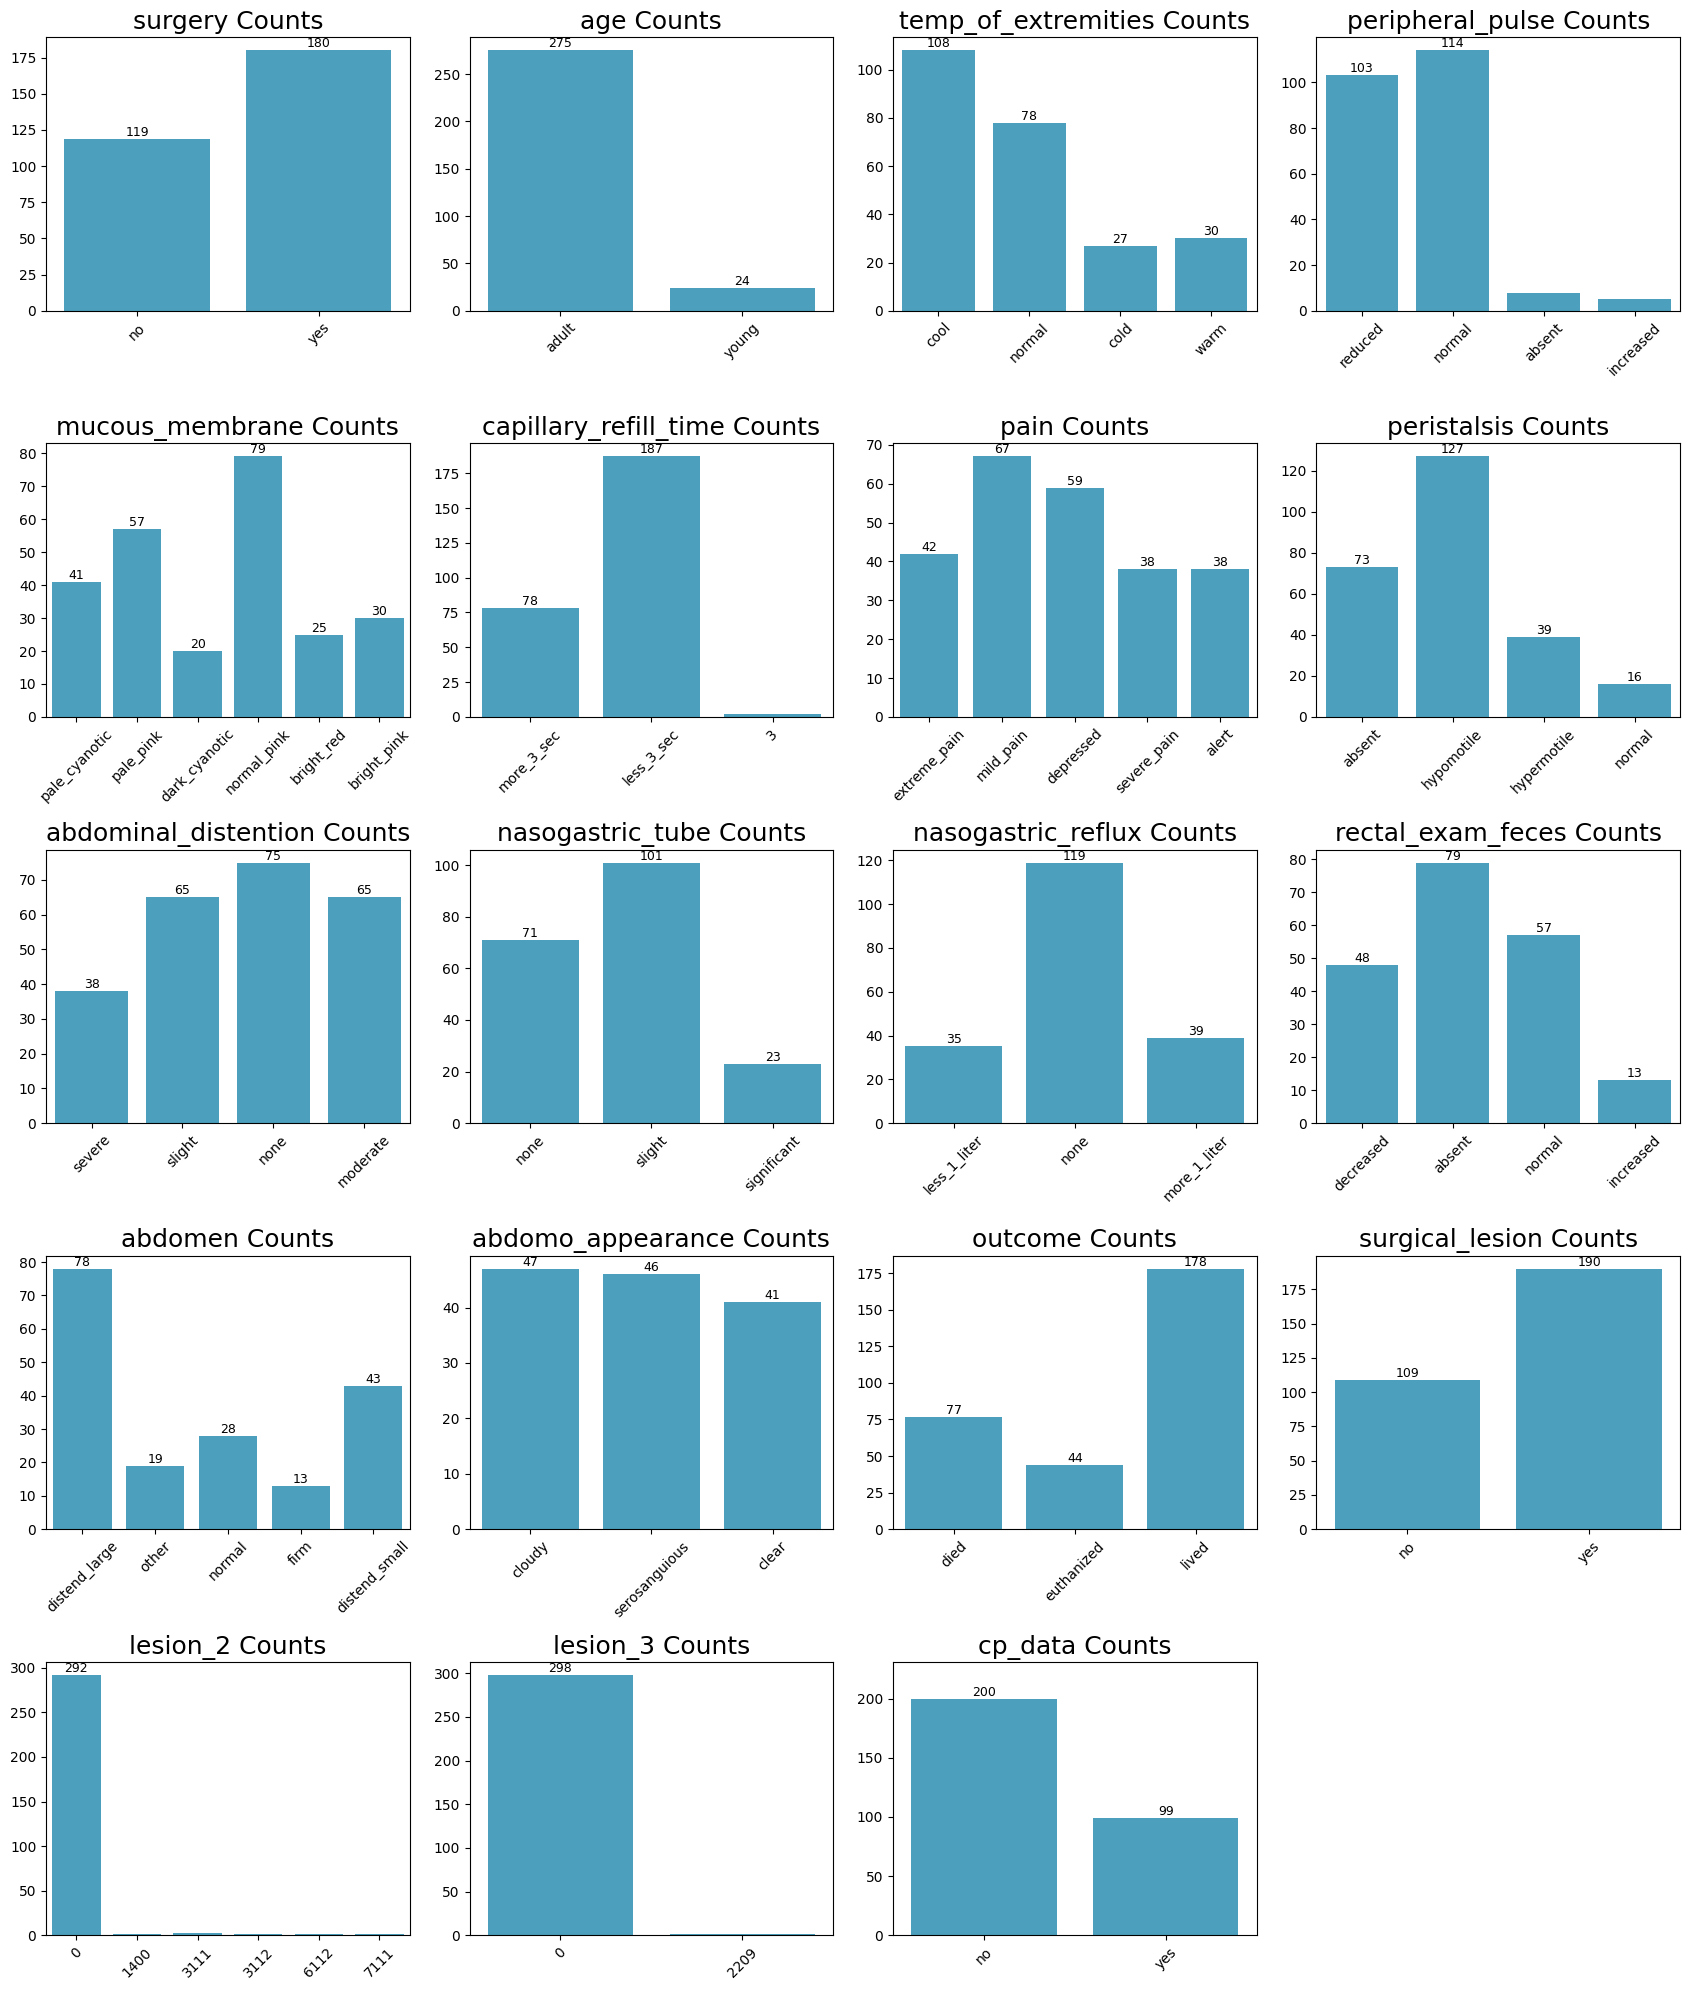

In [ ]:
def plot_count(df, columns, n_cols):
    n_rows = (len(columns) - 1) // n_cols + 1
    fig, ax = plt.subplots(n_rows, n_cols, figsize=(17, 4 * n_rows))
    ax = ax.flatten()

    color = sns.color_palette("husl", 8)[5]  # Definindo a cor

    for i, column in enumerate(columns):
        sns.countplot(data=df, x=column, ax=ax[i], color=color)

        ax[i].set_title(f'{column} Counts', fontsize=18)
        ax[i].set_xlabel(None, fontsize=16)
        ax[i].set_ylabel(None, fontsize=16)
        ax[i].tick_params(axis='x', rotation=45)

        for p in ax[i].patches:
            value = int(p.get_height())
            if value > 10:
                ax[i].annotate(f'{value:.0f}', (p.get_x() + p.get_width() / 2, p.get_height()),
                               ha='center', va='bottom', fontsize=9)

    ylim_top = ax[i].get_ylim()[1]
    ax[i].set_ylim(top=ylim_top * 1.1)

    for i in range(len(columns), len(ax)):
        ax[i].axis('off')

    plt.tight_layout()
    plt.show()

# Análise dos registros dos atributos no total
columns_cat_total = [column for column in data.columns if data[column].nunique() < 10]
plot_count(data, columns_cat_total, 4)  # Remova o argumento 'hue'


###*Análise dos dados numéricos*

In [ ]:
# Distribuição dos dados numéricos em relação a variável alvo (outcome)

fig1 = px.box(data, x='rectal_temp', y='outcome', color='outcome')
fig2 = px.box(data, x='pulse', y='outcome', color='outcome')
fig3 = px.box(data, x='respiratory_rate', y='outcome', color='outcome')
fig4 = px.box(data, x='packed_cell_volume', y='outcome', color='outcome')
fig5 = px.box(data, x='total_protein', y='outcome', color='outcome')
fig6 = px.box(data, x='abdomo_protein', y='outcome', color='outcome')
fig7 = px.box(data, x='lesion_1', y='outcome', color='outcome')  # Apesar de ser integer, será tratada, na verdade, como categórica porque faz referência a uma lesão
fig8 = px.box(data, x='lesion_2', y='outcome', color='outcome')  # Apesar de ser integer, será tratada, na verdade, como categórica porque faz referência a uma lesão
fig9 = px.box(data, x='lesion_3', y='outcome', color='outcome')  # Apesar de ser integer, será tratada, na verdade, como categórica porque faz referência a uma lesão

fig1.show()
fig2.show()
fig3.show()
fig4.show()
fig5.show()
fig6.show()
fig7.show()
fig8.show()
fig9.show()

## **Pré-Processamento**

###*Missing Values*

Através da Análise Exploratória de Dados foi possível identificar que há 3 atributos que tem mais de 50% de dados faltantes:
* nasogastric_reflux_ph
* abdomo_protein
* abdomo_protein

Estes atributos irão ser excluídos no modelo.

####Retirar colunas do modelo que tem mais de 50% dos dados faltantes




In [ ]:
# Calcula a porcentagem de valores ausentes em cada coluna
missing_percentage = (data.isna().sum() * 100) / len(data)

# Identifica as colunas que têm mais de 50% de valores ausentes
columns_to_delete = missing_percentage[missing_percentage > 50].index

# Remove as colunas com mais de 50% de valores ausentes e salva no novo DataFrame chamado data_missing
data_missing = data.drop(columns=columns_to_delete)

In [ ]:
# Estes são os 3 atributos que tem mais de 50% de dados faltantes e que retiramos:
columns_to_delete

Index(['nasogastric_reflux_ph', 'abdomo_appearance', 'abdomo_protein'], dtype='object')

In [ ]:
#Ainda temos 16 colunas com valores ausentes para tratar, são elas:

def summary(data_missing):
    # Calcula a porcentagem de missing values apenas para as colunas que possuem valores ausentes
    missing_percentage = (data_missing.isna().sum() * 100) / len(data_missing)
    missing_percentage = missing_percentage[missing_percentage > 0]

    if not missing_percentage.empty:
        # Cria um DataFrame com as porcentagens de valores ausentes
        sum = pd.DataFrame({'missing%': missing_percentage})

        # Adiciona o tipo de dado (dtype) de cada coluna ao DataFrame
        sum['dtype'] = data_missing.dtypes

        # Ordena o DataFrame com base na porcentagem de valores ausentes
        sum.sort_values(by='missing%', ascending=False, inplace=True)

        return sum

    #Se não houver colunas com valores ausentes, exibe a mensagem abaixo
    else:
        print("Não há colunas com valores ausentes.")

# Chama a função summary e aplica um estilo de gradiente de cor
summary_df = summary(data_missing)
summary_df.style.background_gradient(cmap='BuGn')

#### Tratamento das colunas que tem missing values e que os registros são valores numéricos

Os valores ausentes das variáveis numéricas serão preenchidos com a mediana da variável, isto é, o valor que ocupa a posição central dos dados (50% percentil).

Esta técnica foi escolhida por conta da distribuição dos dados, uma vez que foi identificado na análise exploratória que nem todas as distribuições são normais. Portanto, a mediana é preferível nestes casos pois é menos sensível a outliers.

In [ ]:
#Analisar as colunas que tem missing values e que os registros são valores numéricos

# Verificar quantas linhas cada coluna tem
num_rows_per_column = data_missing.count()

# Obtenha o nome das colunas que têm exatamente 299 registros
columns_to_drop = num_rows_per_column[num_rows_per_column == 299].index

# Exclua as colunas que tem exatamente 299 registros - são as que não tem missing values
data_numero = data_missing.drop(columns=columns_to_drop, axis=1)

# Visualizar os dados
data_numero.describe()


rectal_temp       pulse  respiratory_rate  packed_cell_volume  \
count   239.000000  275.000000        241.000000          270.000000   
mean     38.168619   72.000000         30.460581           46.307407   
std       0.733744   28.646219         17.666102           10.436743   
min      35.400000   30.000000          8.000000           23.000000   
25%      37.800000   48.000000         18.000000           38.000000   
50%      38.200000   64.000000         25.000000           45.000000   
75%      38.500000   88.000000         36.000000           52.000000   
max      40.800000  184.000000         96.000000           75.000000   

       total_protein  
count     266.000000  
mean       24.274436  
std        27.364194  
min         3.300000  
25%         6.500000  
50%         7.500000  
75%        56.750000  
max        89.000000

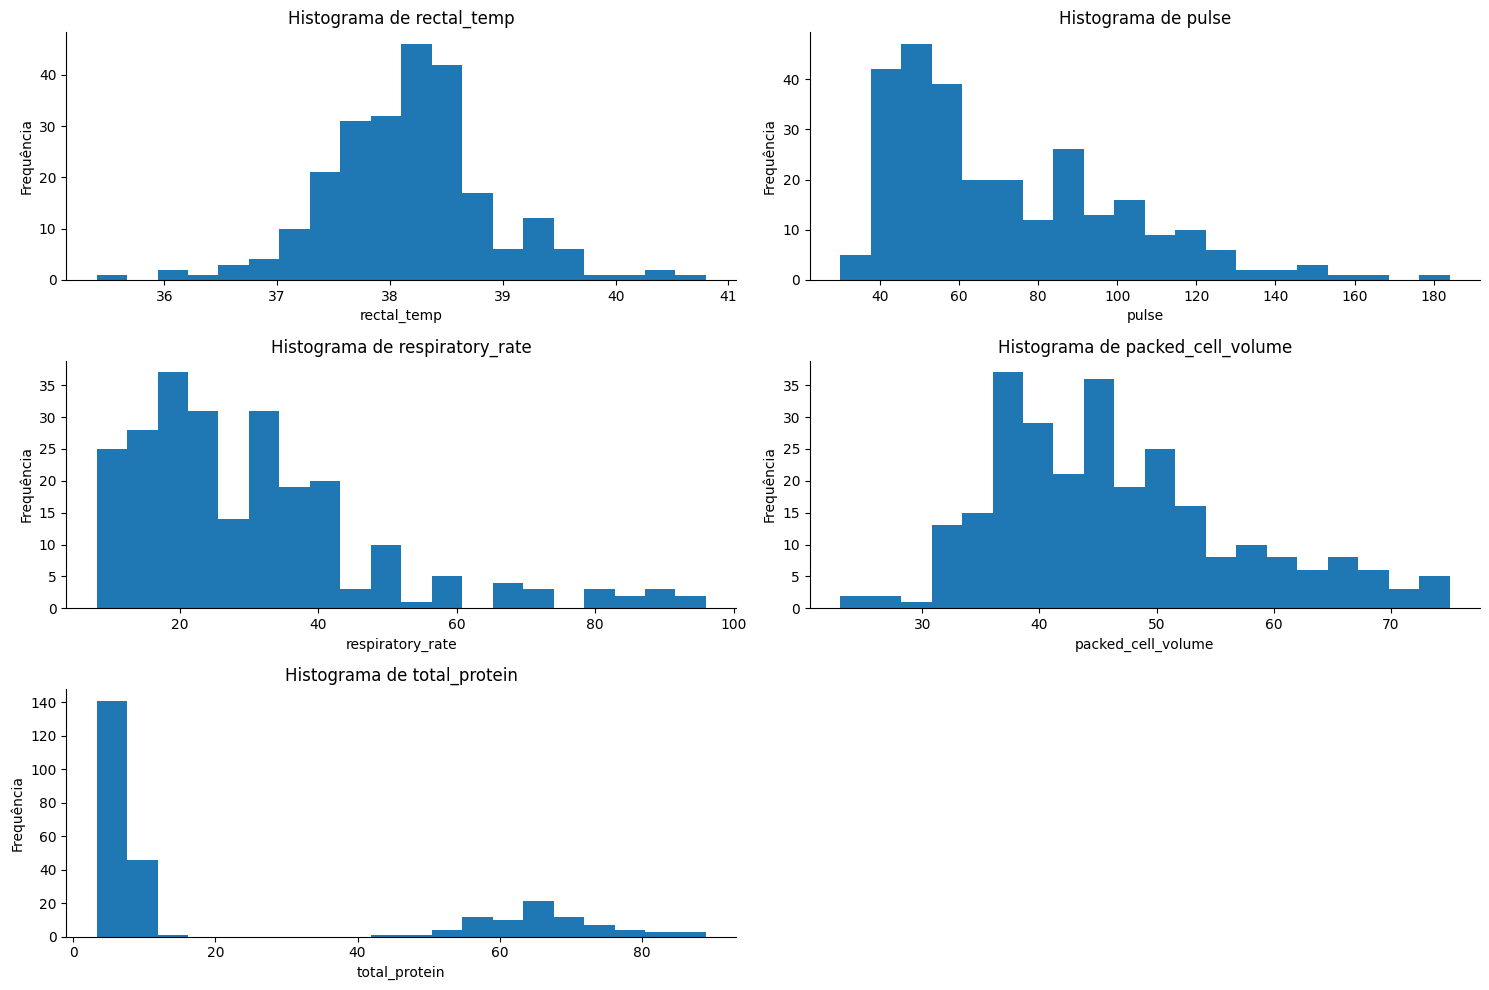

In [ ]:
# Análise de histograma dos atributos numéricos que tem missing

# Definir as colunas que serão plotadas
columns_to_plot = ['rectal_temp', 'pulse', 'respiratory_rate', 'packed_cell_volume', 'total_protein']

# Definir o número de bins para os histogramas
num_bins = 20

# Definir o tamanho da figura
plt.figure(figsize=(15, 10))

# Loop sobre as colunas e plotar os histogramas
for i, column in enumerate(columns_to_plot, 1):
    plt.subplot(3, 2, i)
    plt.hist(data_missing[column], bins=num_bins)
    plt.title(f'Histograma de {column}')
    plt.xlabel(column)
    plt.ylabel('Frequência')
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)

# Ajustar o layout e exibir os histogramas
plt.tight_layout()
plt.show()

In [ ]:
# Calcular a mediana de cada coluna numérica que contém missing values
median_rectal_temp = data_missing['rectal_temp'].median()
median_pulse = data_missing['pulse'].median()
median_respiratory_rate = data_missing['respiratory_rate'].median()
median_packed_cell_volume = data_missing['packed_cell_volume'].median()
median_total_protein = data_missing['total_protein'].median()

# Preencher os valores faltantes nas colunas especificadas com as medianas correspondentes
data_missing['rectal_temp'].fillna(median_rectal_temp, inplace=True)
data_missing['pulse'].fillna(median_pulse, inplace=True)
data_missing['respiratory_rate'].fillna(median_respiratory_rate, inplace=True)
data_missing['packed_cell_volume'].fillna(median_packed_cell_volume, inplace=True)
data_missing['total_protein'].fillna(median_total_protein, inplace=True)

In [ ]:
# Filtrar colunas do tipo float
float_columns = data_missing.select_dtypes(include=['float']).columns

# Calcular a soma de valores ausentes apenas para as colunas float
missing_float_values = data_missing[float_columns].isnull().sum()

# Imprimir o resultado
print(missing_float_values)

rectal_temp           0
pulse                 0
respiratory_rate      0
packed_cell_volume    0
total_protein         0
dtype: int64

In [ ]:
data_missing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 25 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   surgery                299 non-null    object 
 1   age                    299 non-null    object 
 2   hospital_number        299 non-null    int64  
 3   rectal_temp            299 non-null    float64
 4   pulse                  299 non-null    float64
 5   respiratory_rate       299 non-null    float64
 6   temp_of_extremities    243 non-null    object 
 7   peripheral_pulse       230 non-null    object 
 8   mucous_membrane        252 non-null    object 
 9   capillary_refill_time  267 non-null    object 
 10  pain                   244 non-null    object 
 11  peristalsis            255 non-null    object 
 12  abdominal_distention   243 non-null    object 
 13  nasogastric_tube       195 non-null    object 
 14  nasogastric_reflux     193 non-null    object 
 15  rectal

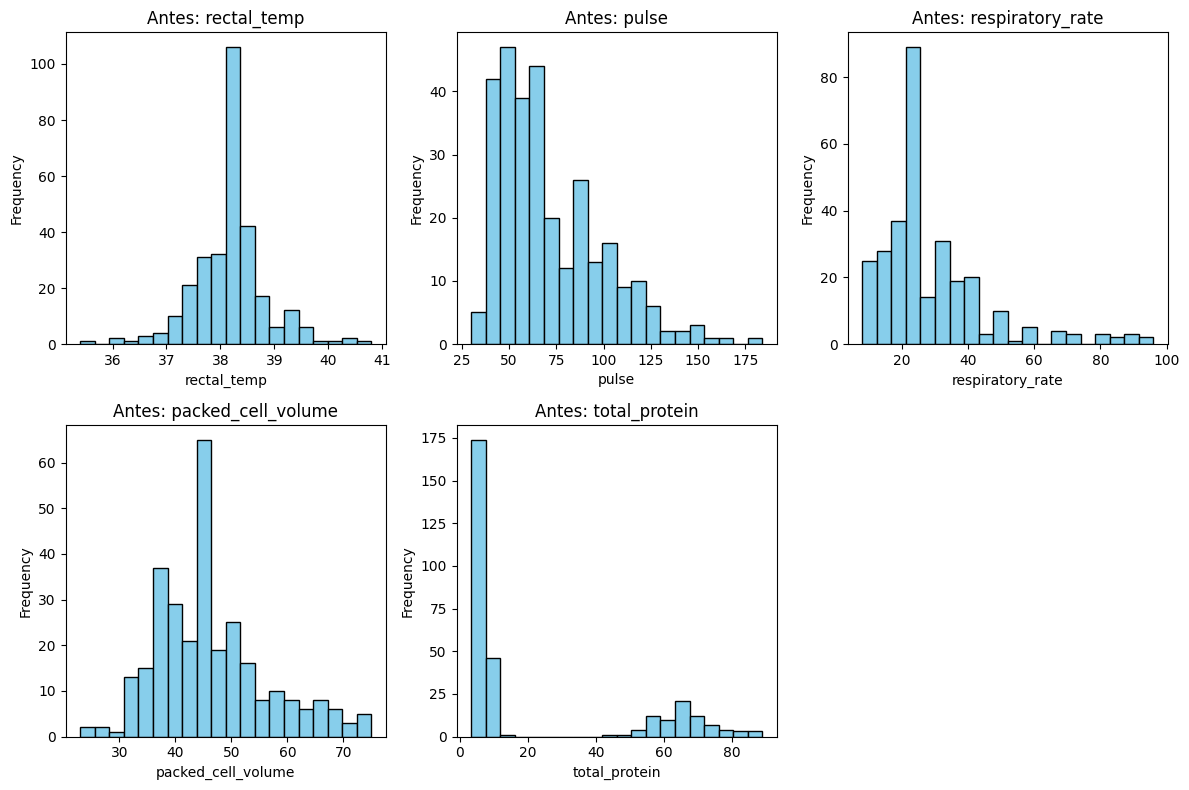

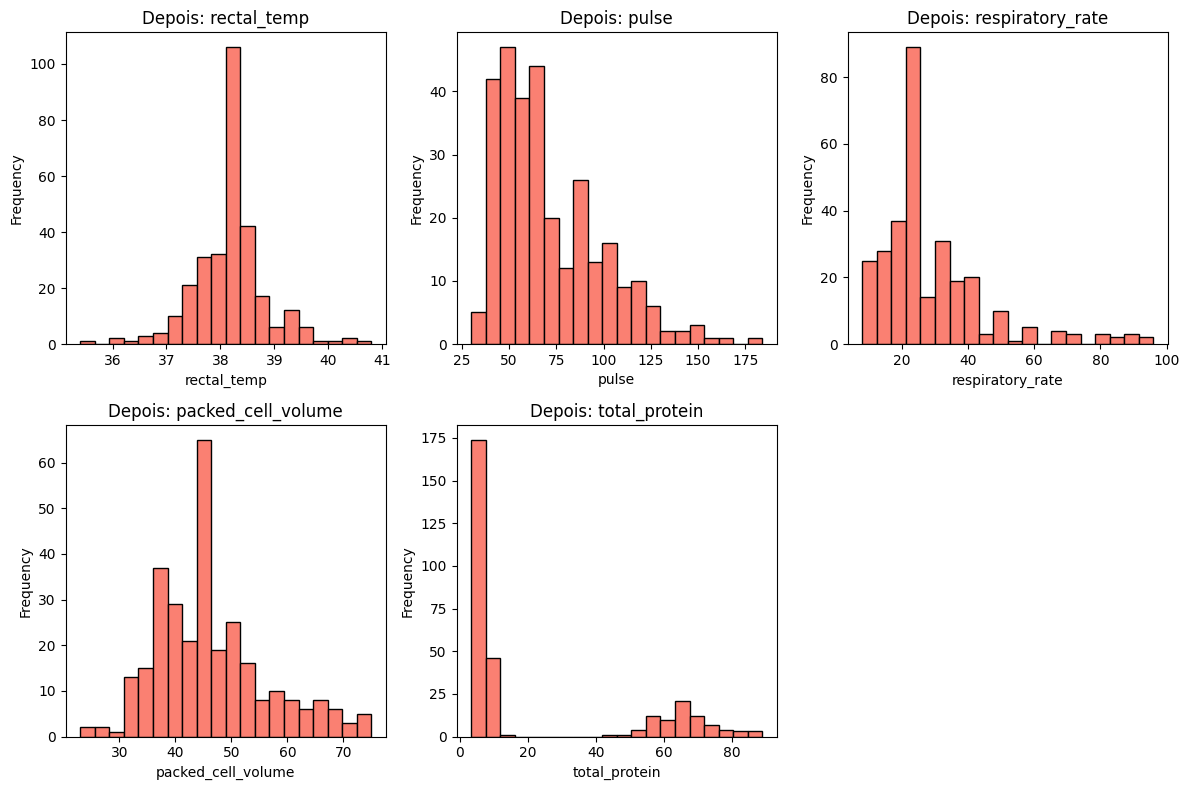

In [ ]:
#Fazer a comparação da distribuição de dados antes e depois do tratamento de missing values

# Definir as colunas para os histogramas
columns_to_plot = ['rectal_temp', 'pulse', 'respiratory_rate', 'packed_cell_volume', 'total_protein']

# Criar histogramas antes do tratamento de valores ausentes
plt.figure(figsize=(12, 8))
for i, column in enumerate(columns_to_plot):
    plt.subplot(2, 3, i+1)
    plt.hist(data_missing[column], bins=20, color='skyblue', edgecolor='black')
    plt.title(f'Antes: {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# Criar histogramas depois do tratamento de valores ausentes
plt.figure(figsize=(12, 8))
for i, column in enumerate(columns_to_plot):
    plt.subplot(2, 3, i+1)
    plt.hist(data_missing[column].fillna(data_missing[column].median()), bins=20, color='salmon', edgecolor='black')
    plt.title(f'Depois: {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')

# Ajustar o layout e mostrar os subplots
plt.tight_layout()
plt.show()

Podemos notar que não houve mudanças na distribuição dos números.

####*Tratamento das colunas que tem missing values e que os registros são valores categóricos*

Até agora, então, retiramos todos os valores ausentes das colunas do tipo numéricas. Temos de tratar as 11 colunas abaixo que são categóricas que ainda ficaram com missing values.

Os registros que são categóricos serão preenchidos pela moda, ou seja, pelo valor mais frequente. Desta forma, a distribuição das categorias são mantidas e evita criar algum viés nas análises subsequentes.


In [ ]:
def summary(data_missing):
    # Calcula a porcentagem de missing values apenas para as colunas que possuem valores ausentes
    missing_percentage = (data_missing.isna().sum() * 100) / len(data_missing)
    missing_percentage = missing_percentage[missing_percentage > 0]

    if not missing_percentage.empty:
        # Cria um DataFrame com as porcentagens de valores ausentes
        sum = pd.DataFrame({'missing%': missing_percentage})

        # Adiciona o tipo de dado (dtype) de cada coluna ao DataFrame
        sum['dtype'] = data_missing.dtypes

        # Ordena o DataFrame com base na porcentagem de valores ausentes
        sum.sort_values(by='missing%', ascending=False, inplace=True)

        return sum

    #Se não houver colunas com valores ausentes, exibe a mensagem abaixo
    else:
        print("Não há colunas com valores ausentes.")

# Chama a função summary e aplica um estilo de gradiente de cor
summary_df = summary(data_missing)
summary_df.style.background_gradient(cmap='BuGn')

In [ ]:
# Calcular a moda de cada coluna categórica
mode_values = data_missing.select_dtypes(include=['object']).mode()

In [ ]:
mode_values

surgery    age temp_of_extremities peripheral_pulse mucous_membrane  \
0     yes  adult                cool           normal     normal_pink   

  capillary_refill_time       pain peristalsis abdominal_distention  \
0            less_3_sec  mild_pain  hypomotile                 none   

  nasogastric_tube nasogastric_reflux rectal_exam_feces        abdomen  \
0           slight               none            absent  distend_large   

  outcome surgical_lesion cp_data  
0   lived             yes      no

In [ ]:
# Preencher os valores faltantes com as modas correspondentes
data_missing.fillna(mode_values.iloc[0], inplace=True)

In [ ]:
data_missing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 25 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   surgery                299 non-null    object 
 1   age                    299 non-null    object 
 2   hospital_number        299 non-null    int64  
 3   rectal_temp            299 non-null    float64
 4   pulse                  299 non-null    float64
 5   respiratory_rate       299 non-null    float64
 6   temp_of_extremities    299 non-null    object 
 7   peripheral_pulse       299 non-null    object 
 8   mucous_membrane        299 non-null    object 
 9   capillary_refill_time  299 non-null    object 
 10  pain                   299 non-null    object 
 11  peristalsis            299 non-null    object 
 12  abdominal_distention   299 non-null    object 
 13  nasogastric_tube       299 non-null    object 
 14  nasogastric_reflux     299 non-null    object 
 15  rectal

####Visualização do tratamento de missing values

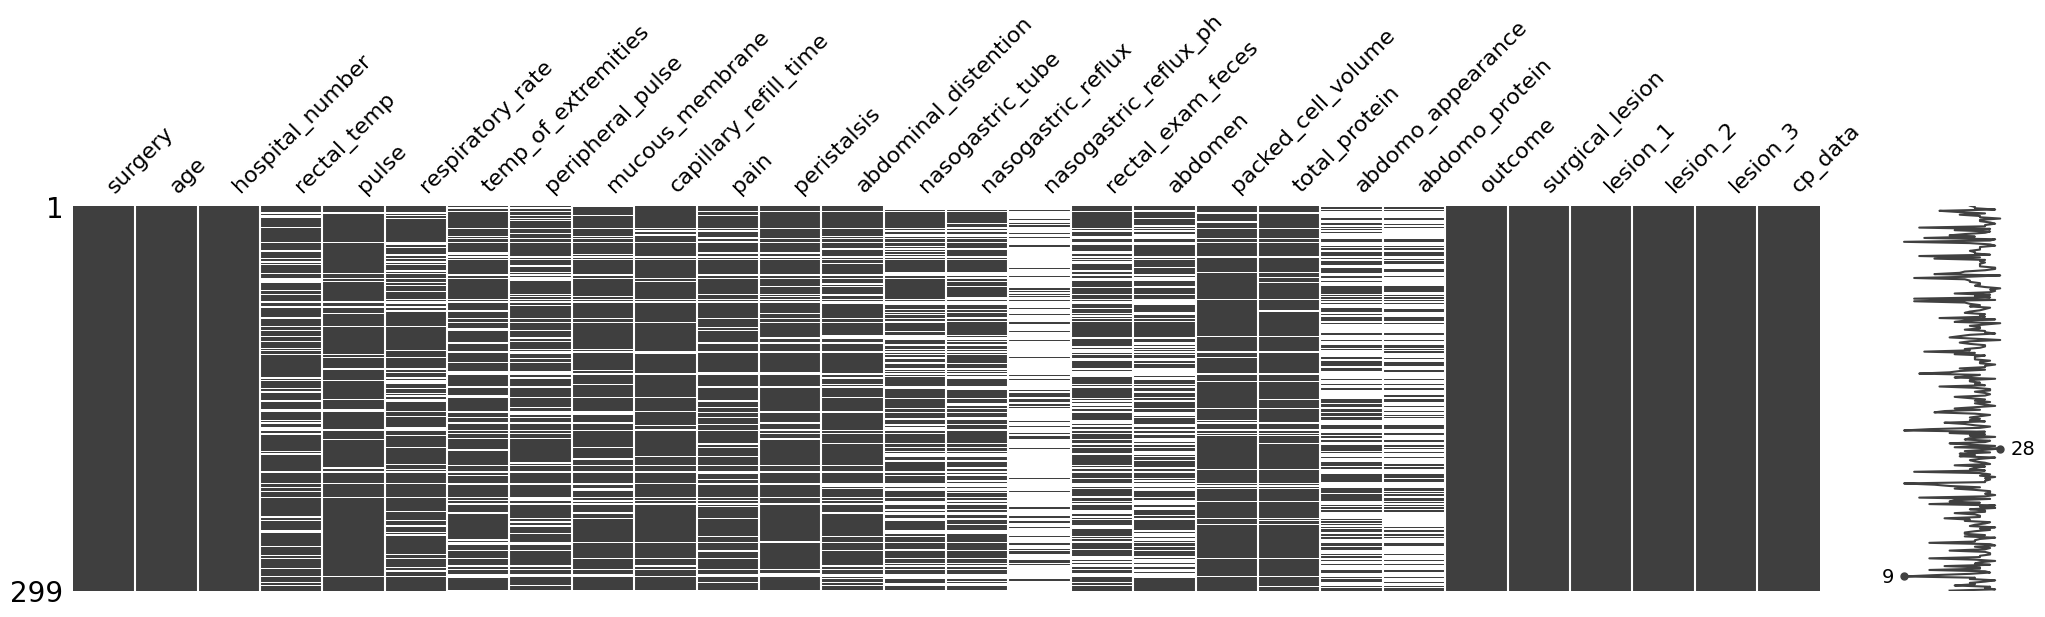

In [ ]:
# Visualização dos valores ausentes da base
msno.matrix(data, figsize=(25,5));

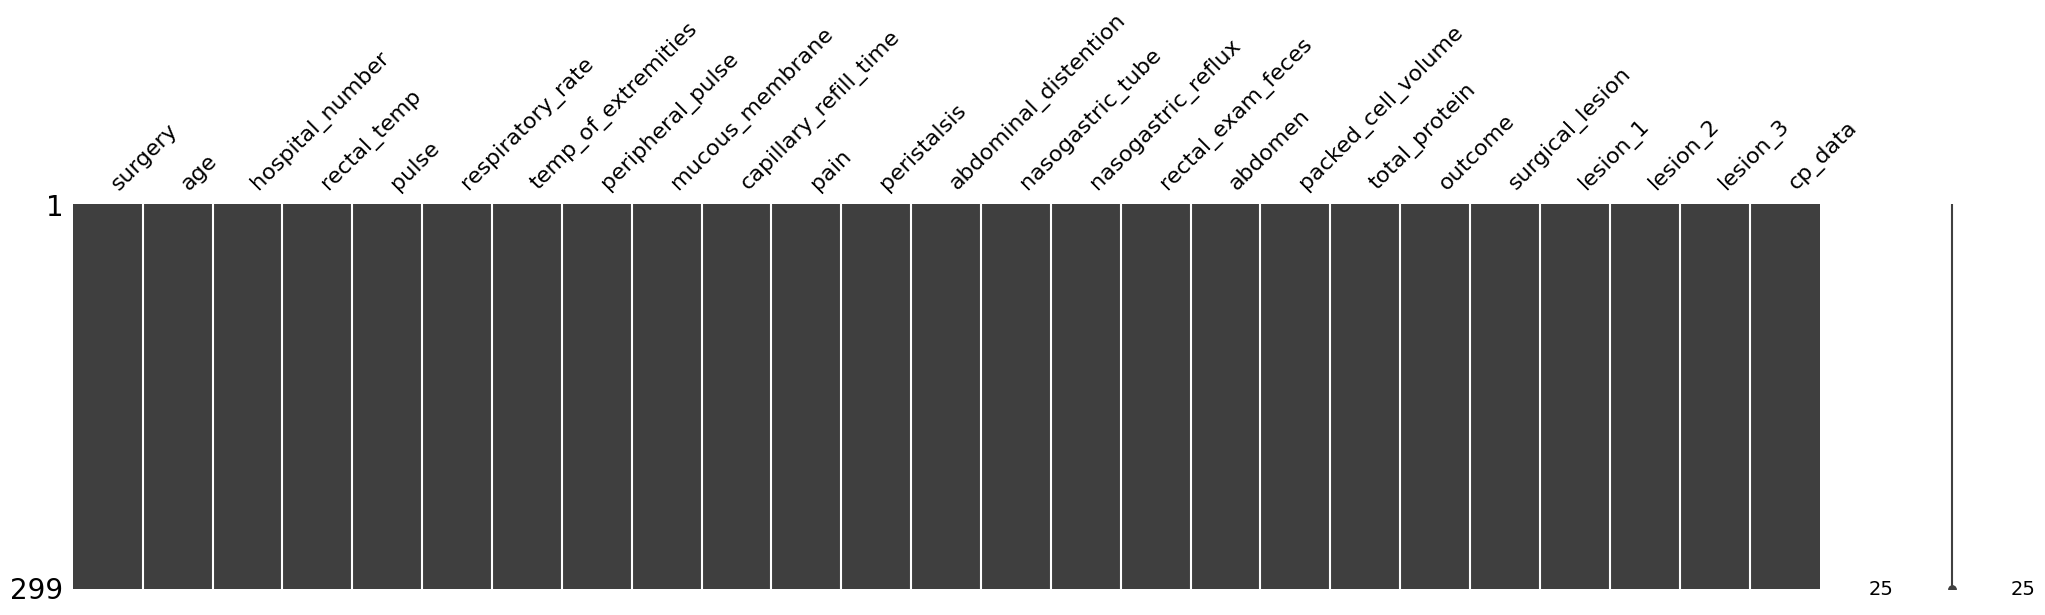

In [ ]:
# Visualização dos valores ausentes da base após o tratamento
msno.matrix(data_missing, figsize=(25,5));

In [ ]:
data_missing.isnull().sum()

surgery                  0
age                      0
hospital_number          0
rectal_temp              0
pulse                    0
respiratory_rate         0
temp_of_extremities      0
peripheral_pulse         0
mucous_membrane          0
capillary_refill_time    0
pain                     0
peristalsis              0
abdominal_distention     0
nasogastric_tube         0
nasogastric_reflux       0
rectal_exam_feces        0
abdomen                  0
packed_cell_volume       0
total_protein            0
outcome                  0
surgical_lesion          0
lesion_1                 0
lesion_2                 0
lesion_3                 0
cp_data                  0
dtype: int64

###*Seleção/Extração dos Atributos*

#### Atributo capillary_refill_time

Na coluna 'capillary_refill_time', há o dado '3' com são apenas 2 entradas. Como são poucas, serão excluídas essas duas linhas.

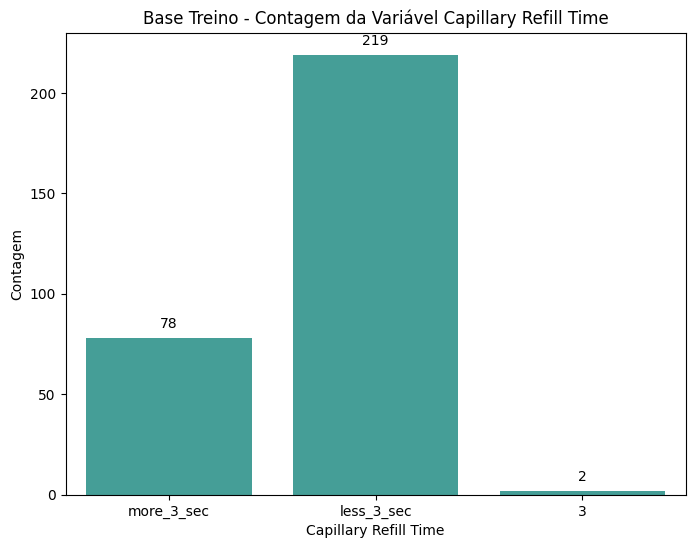

In [ ]:
# Definindo a cor desejada
color = sns.color_palette("husl", 8)[4]

# Criando o gráfico de barras para a variável capillary_refill_time
plt.figure(figsize=(8, 6))
sns.countplot(data=data_missing, x='capillary_refill_time', color=color)
plt.title('Base Treino - Contagem da Variável Capillary Refill Time')
plt.xlabel('Capillary Refill Time')
plt.ylabel('Contagem')

# Adicionando rótulos às barras
for p in plt.gca().patches:
    plt.gca().annotate(format(p.get_height(), '.0f'),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'bottom',
                xytext = (0, 5),
                textcoords = 'offset points')

plt.show()

#### *Atributos: hospital_number e lesion_1 / lesion_2 / lesion_3*

Para analisar a correlação entre variáveis categóricas e a variável alvo, será aplicado:

1. **Tabela de Contingência**:
Esta tabela mostra a frequência conjunta de cada combinação de valores entre a variável categórica e a variável alvo.

2. **Teste Qui-Quadrado**:
Este teste estatístico verifica se existe uma associação significativa entre as variáveis categóricas. Um valor p baixo (geralmente menor que 0.05) indica uma associação significativa.

In [ ]:
# Crie uma tabela de contingência
tabela_contingencia = pd.crosstab(data_missing['hospital_number'], data_missing['outcome'])

# Realize o teste qui-quadrado
estatisticas, pvalor, graus_liberdade, tabela_esperada = chi2_contingency(tabela_contingencia)

# Interprete o resultado
print("Valor p:", pvalor)

if pvalor < 0.05:
    print("[bold green3]Existe uma associação significativa entre as variáveis.")
else:
    print("[bold red3]Não há evidência de associação significativa.[/]")

Valor p: 0.1951460093110452

Não há evidência de associação significativa.

In [ ]:
# Crie uma tabela de contingência
tabela_contingencia = pd.crosstab(data_missing['lesion_1'], data_missing['outcome'])

# Realize o teste qui-quadrado
estatisticas, pvalor, graus_liberdade, tabela_esperada = chi2_contingency(tabela_contingencia)

# Interprete o resultado
print("Valor p:", pvalor)

if pvalor < 0.05:
    print("[bold green3]Existe uma associação significativa entre as variáveis.")
else:
    print("[bold red3]Não há evidência de associação significativa.[/]")

Valor p: 3.3769719959851023e-10

Existe uma associação significativa entre as variáveis.

In [ ]:
# Crie uma tabela de contingência
tabela_contingencia = pd.crosstab(data_missing['lesion_2'], data_missing['outcome'])

# Realize o teste qui-quadrado
estatisticas, pvalor, graus_liberdade, tabela_esperada = chi2_contingency(tabela_contingencia)

# Interprete o resultado
print("Valor p:", pvalor)

if pvalor < 0.05:
    print("[bold green3]Existe uma associação significativa entre as variáveis.")
else:
    print("[bold red3]Não há evidência de associação significativa.[/]")

Valor p: 0.4460673201370049

Não há evidência de associação significativa.

In [ ]:
# Crie uma tabela de contingência
tabela_contingencia = pd.crosstab(data_missing['lesion_3'], data_missing['outcome'])

# Realize o teste qui-quadrado
estatisticas, pvalor, graus_liberdade, tabela_esperada = chi2_contingency(tabela_contingencia)

# Interprete o resultado
print("Valor p:", pvalor)

if pvalor < 0.05:
    print("[bold green3]Existe uma associação significativa entre as variáveis.")
else:
    print("[bold red3]Não há evidência de associação significativa.[/]")

Valor p: 0.7110388544938988

Não há evidência de associação significativa.

**hospital_number, lesion_2 e lesion_3 não tem associação significativa com a variável alvo, e com isso, serão removidos da base**.

Esta decisão foi tomada uma vez que a base de treino e teste precisam ter o mesmo número de colunas. Como as colunas avaliadas acima possuem muitas classes, após o tratamento do One Hot Enconding, o número de colunas iriam aumentar e não seria garantido que as colunas entre as bases vão ser correspondentes, uma vez que uma classe pode estar na base de treino, mas não na de teste (e vice-versa).

O atributo lesion_3 tem apenas 2 classes, porém, foi também avaliado por ser uma parte da representação de lesões.

**Como o atributo lesion_1 teve associação significativa com a variável alvo, foi mantido nesta parte e será feito um tratamento na hora da codificação one-hot-encoding**.

In [ ]:
# Encontrar as classes únicas em data['lesion_1'] que não estão em test['lesion_1']
classes_lesion_1_data = set(data['lesion_1'].unique())
classes_lesion_1_test = set(test['lesion_1'].unique())

classes_lesion_1_data_nao_test = classes_lesion_1_data - classes_lesion_1_test
print("Classes únicas em data['lesion_1'] que não estão em test['lesion_1']:")
print(classes_lesion_1_data_nao_test)

# Encontrar as classes únicas em test['lesion_1'] que não estão em data['lesion_1']
classes_lesion_1_test_nao_data = classes_lesion_1_test - classes_lesion_1_data
print("Classes únicas em test['lesion_1'] que não estão em data['lesion_1']:")
print(classes_lesion_1_test_nao_data)


Classes únicas em data['lesion_1'] que não estão em test['lesion_1']:

{
    2305,
    3207,
    4111,
    2322,
    5400,
    2207,
    11300,
    9000,
    3113,
    3115,
    300,
    3124,
    9400,
    3133,
    6209,
    3400,
    7113,
    8400,
    6112,
    3300,
    7400,
    8300,
    11124,
    5111,
    2300
}

Classes únicas em test['lesion_1'] que não estão em data['lesion_1']:

set()

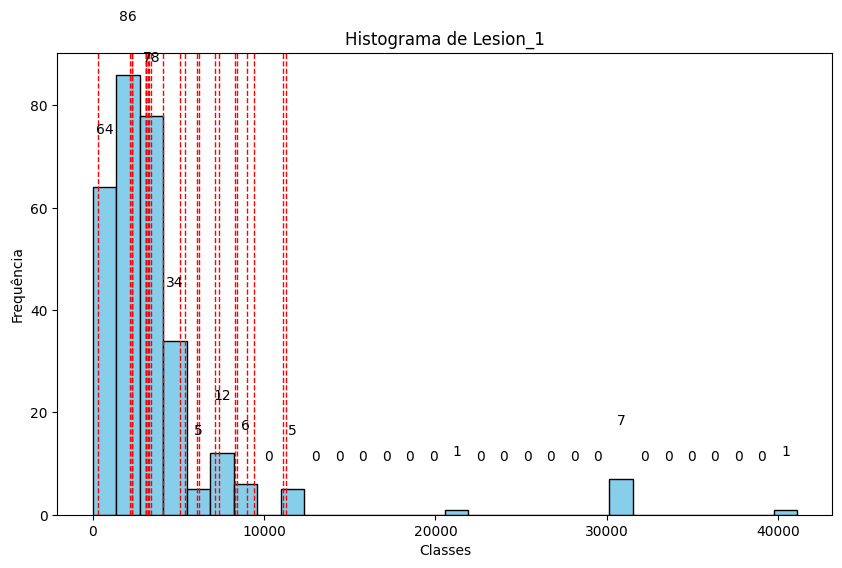

In [ ]:
# Classes específicas
classes_especificas = [2305, 3207, 4111, 2322, 5400, 2207, 11300, 9000, 3113, 3115, 300, 3124, 9400, 3133, 6209, 3400, 7113, 8400, 6112, 3300, 7400, 8300, 11124, 5111, 2300]

# Plote o histograma
plt.figure(figsize=(10, 6))
histograma = data['lesion_1'].hist(bins=30, color='skyblue', edgecolor='black')
plt.title('Histograma de Lesion_1')
plt.xlabel('Classes')
plt.ylabel('Frequência')

# Adicione linhas verticais para as classes específicas
for classe in classes_especificas:
    plt.axvline(x=classe, color='red', linestyle='--', linewidth=1)

# Adicione o número total de cada classe sobre as barras
for i in range(len(histograma.patches)):
    plt.text(histograma.patches[i].get_x() + histograma.patches[i].get_width()/2,
             histograma.patches[i].get_height() + 10,
             int(histograma.patches[i].get_height()),
             ha='center',
             va='bottom')

plt.grid(False)
plt.show()


Conforme as análises acima, o problema reside na discrepância entre as classes presentes no atributo "lesion_1" do conjunto de treinamento e do conjunto de teste.

No conjunto de treinamento, estão presentes as classes 2305, 3207, 4111, 2322, 5400, 2207, 11300, 9000, 3113, 3115, 300, 3124, 9400, 3133, 6209, 3400, 7113, 8400, 6112, 3300, 7400, 8300, 11124, 5111 e 2300; porém, essas classes não aparecem no conjunto de teste.

Ao aplicar o codificador one-hot-encoding (tratamento que será feito a frente), essa discrepância gerará um problema, pois o codificador criará colunas para cada classe presente no conjunto de treinamento.

Como as classes do conjunto de teste não coincidem com as do conjunto de treinamento, as colunas geradas pelo codificador não serão compatíveis com os dados do conjunto de teste, resultando em um número diferente de colunas para cada conjunto.

Para resolver este problema, iremos plotar novas colunas que representam as classes ausentes deste atributo dentro da base de teste. Todas as linhas dessas novas colunas serão preenchidas com zero. Este tratamento será feito na etapa do one-hot-encoding.

Neste momento, apenas iremos excluir os atributos que não tem significância em relação a variável alvo (hospital_number, lesion_2 e lesion_3).

#### *Exclusão dos atributos*

In [ ]:
# Remover as linhas que contêm o valor '3' na coluna 'capillary_refill_time'
data_cleaned = data_missing[data_missing['capillary_refill_time'] != '3'].copy()

In [ ]:
# Remover as colunas hospital_number, lesion_2 e lesion_3
data_cleaned.drop(['hospital_number', 'lesion_2', 'lesion_3'], axis=1, inplace=True)

In [ ]:
data_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 297 entries, 0 to 298
Data columns (total 22 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   surgery                297 non-null    object 
 1   age                    297 non-null    object 
 2   rectal_temp            297 non-null    float64
 3   pulse                  297 non-null    float64
 4   respiratory_rate       297 non-null    float64
 5   temp_of_extremities    297 non-null    object 
 6   peripheral_pulse       297 non-null    object 
 7   mucous_membrane        297 non-null    object 
 8   capillary_refill_time  297 non-null    object 
 9   pain                   297 non-null    object 
 10  peristalsis            297 non-null    object 
 11  abdominal_distention   297 non-null    object 
 12  nasogastric_tube       297 non-null    object 
 13  nasogastric_reflux     297 non-null    object 
 14  rectal_exam_feces      297 non-null    object 
 15  abdomen    

###*Normalização*

In [ ]:
# Selecionando apenas as colunas numéricas para normalização
colunas_numericas = ['rectal_temp', 'pulse', 'respiratory_rate', 'packed_cell_volume', 'total_protein']
dados_numericos = data_cleaned[colunas_numericas]

# Normalização dos dados
normalizacao = MinMaxScaler()
dados_normalizados = normalizacao.fit_transform(dados_numericos)

In [ ]:
# Convertendo os dados normalizados de volta em um DataFrame
df_numerico = pd.DataFrame(dados_normalizados, columns=colunas_numericas)

In [ ]:
df_numerico

rectal_temp     pulse  respiratory_rate  packed_cell_volume  \
0       0.574074  0.233766          0.227273            0.423077   
1       0.703704  0.376623          0.136364            0.519231   
2       0.537037  0.064935          0.181818            0.192308   
3       0.685185  0.870130          0.863636            0.480769   
4       0.351852  0.480519          0.306818            0.980769   
..           ...       ...               ...                 ...   
292     0.518519  0.584416          0.704545            0.615385   
293     0.333333  0.272727          0.181818            0.403846   
294     0.388889  0.272727          0.250000            0.711538   
295     0.203704  0.454545          0.181818            0.519231   
296     0.333333  0.064935          0.136364            0.250000   

     total_protein  
0         0.059510  
1         0.953326  
2         0.039673  
3         0.045508  
4         0.047841  
..             ...  
292       0.719953  
293       0.049008  
294       0.040840  
295       0.031505  
296       0.684947  

[297 rows x 5 columns]

In [ ]:
# Substituindo os valores normalizados de volta no DataFrame
data_cleaned.loc[:, colunas_numericas] = dados_normalizados

# Agora data_cleaned contém os valores normalizados das colunas numéricas, mantendo as colunas categóricas existentes

In [ ]:
data_cleaned

surgery    age  rectal_temp     pulse  respiratory_rate  \
0        no  adult     0.574074  0.233766          0.227273   
1       yes  adult     0.703704  0.376623          0.136364   
2        no  adult     0.537037  0.064935          0.181818   
3       yes  young     0.685185  0.870130          0.863636   
4        no  adult     0.351852  0.480519          0.306818   
..      ...    ...          ...       ...               ...   
294     yes  adult     0.518519  0.584416          0.704545   
295      no  adult     0.333333  0.272727          0.181818   
296     yes  adult     0.388889  0.272727          0.250000   
297     yes  adult     0.203704  0.454545          0.181818   
298     yes  adult     0.333333  0.064935          0.136364   

    temp_of_extremities peripheral_pulse mucous_membrane  \
0                  cool          reduced     normal_pink   
1                  cool           normal   pale_cyanotic   
2                normal           normal       pale_pink   
3                  cold           normal   dark_cyanotic   
4                  cool           normal   dark_cyanotic   
..                  ...              ...             ...   
294                cold           normal   pale_cyanotic   
295                cool        increased   pale_cyanotic   
296                cold          reduced   pale_cyanotic   
297                cool          reduced       pale_pink   
298                cool           normal     normal_pink   

    capillary_refill_time          pain  ... nasogastric_tube  \
0              more_3_sec  extreme_pain  ...           slight   
1              less_3_sec     mild_pain  ...           slight   
2              less_3_sec     mild_pain  ...           slight   
3              more_3_sec     depressed  ...             none   
4              more_3_sec     mild_pain  ...           slight   
..                    ...           ...  ...              ...   
294            more_3_sec     depressed  ...           slight   
295            more_3_sec   severe_pain  ...      significant   
296            less_3_sec   severe_pain  ...           slight   
297            less_3_sec     mild_pain  ...      significant   
298            less_3_sec     mild_pain  ...           slight   

    nasogastric_reflux rectal_exam_feces        abdomen packed_cell_volume  \
0                 none         decreased  distend_large           0.423077   
1                 none            absent          other           0.519231   
2                 none            normal         normal           0.192308   
3         less_1_liter         decreased  distend_large           0.480769   
4                 none            absent  distend_large           0.980769   
..                 ...               ...            ...                ...   
294               none            absent  distend_large           0.615385   
295               none            absent  distend_small           0.403846   
296               none         decreased  distend_large           0.711538   
297               none            absent  distend_small           0.519231   
298               none            absent         normal           0.250000   

    total_protein     outcome  surgical_lesion lesion_1 cp_data  
0        0.059510        died               no    11300      no  
1        0.953326  euthanized               no     2208      no  
2        0.039673       lived               no        0     yes  
3        0.045508        died              yes     2208     yes  
4        0.047841        died               no     4300      no  
..            ...         ...              ...      ...     ...  
294      0.719953  euthanized               no     3205      no  
295      0.049008  euthanized              yes     2208     yes  
296      0.040840        died              yes     3205      no  
297      0.031505       lived              yes     2208     yes  
298      0.684947  euthanized               no     6112      no  

[297 rows x 22 

In [ ]:
dados_normalizados

array([[0.57407407, 0.23376623, 0.22727273, 0.42307692, 0.05950992],
       [0.7037037 , 0.37662338, 0.13636364, 0.51923077, 0.95332555],
       [0.53703704, 0.06493506, 0.18181818, 0.19230769, 0.03967328],
       ...,
       [0.38888889, 0.27272727, 0.25      , 0.71153846, 0.04084014],
       [0.2037037 , 0.45454545, 0.18181818, 0.51923077, 0.03150525],
       [0.33333333, 0.06493506, 0.13636364, 0.25      , 0.68494749]])

### *Separação das Variáveis Explicativas da Variável Alvo*

In [ ]:
# No X, estão todas as colunas, menos a variável alvo. Enquanto no Y, está somente a variável alvo.
# Atributos (X) e Target (y)

x_treino = data_cleaned.drop('outcome', axis = 1)
y_treino = data_cleaned['outcome']

In [ ]:
x_treino.info()

<class 'pandas.core.frame.DataFrame'>
Index: 297 entries, 0 to 298
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   surgery                297 non-null    object 
 1   age                    297 non-null    object 
 2   rectal_temp            297 non-null    float64
 3   pulse                  297 non-null    float64
 4   respiratory_rate       297 non-null    float64
 5   temp_of_extremities    297 non-null    object 
 6   peripheral_pulse       297 non-null    object 
 7   mucous_membrane        297 non-null    object 
 8   capillary_refill_time  297 non-null    object 
 9   pain                   297 non-null    object 
 10  peristalsis            297 non-null    object 
 11  abdominal_distention   297 non-null    object 
 12  nasogastric_tube       297 non-null    object 
 13  nasogastric_reflux     297 non-null    object 
 14  rectal_exam_feces      297 non-null    object 
 15  abdomen    

In [ ]:
y_treino.info()

<class 'pandas.core.series.Series'>
Index: 297 entries, 0 to 298
Series name: outcome
Non-Null Count  Dtype 
--------------  ----- 
297 non-null    object
dtypes: object(1)
memory usage: 4.6+ KB


###*Tratamento das Variáveis Categóricas*

In [ ]:
# Quando os novos nomes de colunas forem gerados, perderemos o acesso ao nome das colunas que já temos.
# Para solucionar isto, armazenaremos essa informação em uma variável coluna.

colunas = x_treino.columns

In [ ]:
colunas

Index(['surgery', 'age', 'rectal_temp', 'pulse', 'respiratory_rate',
       'temp_of_extremities', 'peripheral_pulse', 'mucous_membrane',
       'capillary_refill_time', 'pain', 'peristalsis', 'abdominal_distention',
       'nasogastric_tube', 'nasogastric_reflux', 'rectal_exam_feces',
       'abdomen', 'packed_cell_volume', 'total_protein', 'surgical_lesion',
       'lesion_1', 'cp_data'],
      dtype='object')

In [ ]:
# Configuração do One-Hot Encoder

one_hot = make_column_transformer((
    OneHotEncoder(drop = 'if_binary'),
    ['surgery', 'age', 'temp_of_extremities', 'peripheral_pulse', 'mucous_membrane', 'capillary_refill_time', 'pain', 'peristalsis', 'abdominal_distention', 'nasogastric_tube', 'nasogastric_reflux', 'rectal_exam_feces', 'abdomen', 'surgical_lesion', 'lesion_1', 'cp_data']
                                  ),
    remainder = 'passthrough',
    sparse_threshold=0
                                  )

In [ ]:
x_treino = one_hot.fit_transform(x_treino)

In [ ]:
# Retorna o novo nome das colunas:
# As colunas que foram transformadas estão com o nome ondehotencoder na frente
# Enquanto as que não tiveram nenhuma transformação, estão com o nome remainder na frente
one_hot.get_feature_names_out(colunas)

array(['onehotencoder__surgery_yes', 'onehotencoder__age_young',
       'onehotencoder__temp_of_extremities_cold',
       'onehotencoder__temp_of_extremities_cool',
       'onehotencoder__temp_of_extremities_normal',
       'onehotencoder__temp_of_extremities_warm',
       'onehotencoder__peripheral_pulse_absent',
       'onehotencoder__peripheral_pulse_increased',
       'onehotencoder__peripheral_pulse_normal',
       'onehotencoder__peripheral_pulse_reduced',
       'onehotencoder__mucous_membrane_bright_pink',
       'onehotencoder__mucous_membrane_bright_red',
       'onehotencoder__mucous_membrane_dark_cyanotic',
       'onehotencoder__mucous_membrane_normal_pink',
       'onehotencoder__mucous_membrane_pale_cyanotic',
       'onehotencoder__mucous_membrane_pale_pink',
       'onehotencoder__capillary_refill_time_more_3_sec',
       'onehotencoder__pain_alert', 'onehotencoder__pain_depressed',
       'onehotencoder__pain_extreme_pain',
       'onehotencoder__pain_mild_pain', 'one

In [ ]:
x_treino

array([[0.        , 0.        , 0.        , ..., 0.22727273, 0.42307692,
        0.05950992],
       [1.        , 0.        , 0.        , ..., 0.13636364, 0.51923077,
        0.95332555],
       [0.        , 0.        , 0.        , ..., 0.18181818, 0.19230769,
        0.03967328],
       ...,
       [1.        , 0.        , 1.        , ..., 0.25      , 0.71153846,
        0.04084014],
       [1.        , 0.        , 0.        , ..., 0.18181818, 0.51923077,
        0.03150525],
       [1.        , 0.        , 0.        , ..., 0.13636364, 0.25      ,
        0.68494749]])

In [ ]:
# Transformar os dados tratados em um DataFrame do Pandas

# Converter x_treino
df_x_treino = pd.DataFrame(x_treino, columns = one_hot.get_feature_names_out(colunas))

In [ ]:
df_x_treino

onehotencoder__surgery_yes  onehotencoder__age_young  \
0                           0.0                       0.0   
1                           1.0                       0.0   
2                           0.0                       0.0   
3                           1.0                       1.0   
4                           0.0                       0.0   
..                          ...                       ...   
292                         1.0                       0.0   
293                         0.0                       0.0   
294                         1.0                       0.0   
295                         1.0                       0.0   
296                         1.0                       0.0   

     onehotencoder__temp_of_extremities_cold  \
0                                        0.0   
1                                        0.0   
2                                        0.0   
3                                        1.0   
4                                        0.0   
..                                       ...   
292                                      1.0   
293                                      0.0   
294                                      1.0   
295                                      0.0   
296                                      0.0   

     onehotencoder__temp_of_extremities_cool  \
0                                        1.0   
1                                        1.0   
2                                        0.0   
3                                        0.0   
4                                        1.0   
..                                       ...   
292                                      0.0   
293                                      1.0   
294                                      0.0   
295                                      1.0   
296                                      1.0   

     onehotencoder__temp_of_extremities_normal  \
0                                          0.0   
1                                          0.0   
2                                          1.0   
3                                          0.0   
4                                          0.0   
..                                         ...   
292                                        0.0   
293                                        0.0   
294                                        0.0   
295                                        0.0   
296                                        0.0   

     onehotencoder__temp_of_extremities_warm  \
0                                        0.0   
1                                        0.0   
2                                        0.0   
3                                        0.0   
4                                        0.0   
..                                       ...   
292                                      0.0   
293                                      0.0   
294                                      0.0   
295                                      0.0   
296                                      0.0   

     onehotencoder__peripheral_pulse_absent  \
0                                       0.0   
1                                       0.0   
2                                       0.0   
3                                       0.0   
4                                       0.0   
..                                      ...   
292                                     0.0   
293                                     0.0   
294                                     0.0   
295                                     0.0   
296                                     0.0   

     onehotencoder__peripheral_pulse_increased  \
0                                          0.0   
1                                          0.0   
2                                          0.0   
3                                          0.0   
4                                          0.0   
..                                         ...   
292                      

###*Tratamento da Variável Alvo*

In [ ]:
# Para transformar a variável alvo, utilizamos a função Label Encoder, da biblioteca Scikit-Learn
label_encoder = LabelEncoder()

In [ ]:
y_treino = label_encoder.fit_transform(y_treino)

In [ ]:
y_treino

array([0, 1, 2, 0, 0, 2, 2, 0, 1, 2, 2, 2, 2, 0, 2, 0, 0, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 0, 2, 0, 1, 2, 2, 2, 1, 1, 2, 2, 0, 0, 2, 2, 1,
       1, 0, 2, 2, 0, 0, 2, 0, 2, 2, 1, 0, 2, 0, 0, 0, 2, 2, 0, 1, 2, 2,
       2, 2, 2, 2, 1, 2, 0, 0, 0, 1, 2, 2, 2, 0, 2, 2, 0, 2, 0, 1, 2, 2,
       2, 0, 2, 0, 2, 2, 2, 1, 2, 2, 2, 1, 2, 2, 0, 2, 2, 2, 1, 0, 0, 2,
       2, 0, 2, 2, 2, 1, 2, 2, 2, 1, 2, 0, 1, 2, 2, 2, 1, 2, 0, 0, 2, 0,
       0, 0, 2, 2, 2, 2, 0, 0, 2, 1, 2, 2, 0, 2, 2, 2, 0, 2, 2, 2, 2, 2,
       1, 2, 2, 2, 0, 2, 1, 2, 1, 2, 2, 2, 1, 2, 0, 2, 0, 0, 2, 2, 0, 2,
       1, 0, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 1, 0, 2, 2, 2,
       0, 1, 2, 2, 1, 2, 0, 1, 2, 0, 0, 2, 2, 2, 2, 2, 2, 1, 2, 1, 2, 2,
       2, 2, 2, 0, 2, 1, 2, 2, 0, 2, 2, 2, 0, 2, 2, 1, 1, 0, 2, 0, 2, 2,
       0, 2, 0, 2, 2, 1, 0, 0, 2, 2, 0, 1, 0, 2, 0, 2, 2, 2, 0, 2, 1, 2,
       2, 2, 2, 0, 2, 2, 0, 1, 0, 1, 2, 2, 2, 2, 0, 0, 2, 2, 2, 1, 2, 2,
       2, 2, 0, 0, 1, 2, 1, 1, 0, 2, 1])

In [ ]:
# Ver qual é a ordem da codificação para cada saída: 0='died', 1='euthanized', 2='lived'
label_encoder.inverse_transform(y_treino)

array(['died', 'euthanized', 'lived', 'died', 'died', 'lived', 'lived',
       'died', 'euthanized', 'lived', 'lived', 'lived', 'lived', 'died',
       'lived', 'died', 'died', 'lived', 'lived', 'lived', 'lived',
       'lived', 'lived', 'lived', 'lived', 'lived', 'lived', 'lived',
       'died', 'lived', 'died', 'euthanized', 'lived', 'lived', 'lived',
       'euthanized', 'euthanized', 'lived', 'lived', 'died', 'died',
       'lived', 'lived', 'euthanized', 'euthanized', 'died', 'lived',
       'lived', 'died', 'died', 'lived', 'died', 'lived', 'lived',
       'euthanized', 'died', 'lived', 'died', 'died', 'died', 'lived',
       'lived', 'died', 'euthanized', 'lived', 'lived', 'lived', 'lived',
       'lived', 'lived', 'euthanized', 'lived', 'died', 'died', 'died',
       'euthanized', 'lived', 'lived', 'lived', 'died', 'lived', 'lived',
       'died', 'lived', 'died', 'euthanized', 'lived', 'lived', 'lived',
       'died', 'lived', 'died', 'lived', 'lived', 'lived', 'euthanized',
 

In [ ]:
# Transformar os dados tratados em um DataFrame do Pandas

# Converter y_treino
df_y_treino = pd.DataFrame(y_treino, columns=['variavel_alvo'])

In [ ]:
df_y_treino

variavel_alvo
0                0
1                1
2                2
3                0
4                0
..             ...
292              1
293              1
294              0
295              2
296              1

[297 rows x 1 columns]

##**Replicar Pré-Processamento na Base de Teste**

###*Características da base de teste*

In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89 entries, 0 to 88
Data columns (total 28 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   surgery                89 non-null     object 
 1   age                    89 non-null     object 
 2   hospital_number        89 non-null     int64  
 3   rectal_temp            73 non-null     float64
 4   pulse                  84 non-null     float64
 5   respiratory_rate       73 non-null     float64
 6   temp_of_extremities    76 non-null     object 
 7   peripheral_pulse       70 non-null     object 
 8   mucous_membrane        79 non-null     object 
 9   capillary_refill_time  85 non-null     object 
 10  pain                   77 non-null     object 
 11  peristalsis            79 non-null     object 
 12  abdominal_distention   77 non-null     object 
 13  nasogastric_tube       66 non-null     object 
 14  nasogastric_reflux     61 non-null     object 
 15  nasogast

In [ ]:
test.shape

(89, 28)

###*Missing Values*

As colunas que foram retiradas na base de treino foram: ['nasogastric_reflux_ph', 'abdomo_appearance', 'abdomo_protein']

Na base de teste, o valor de missing da coluna abdomo_appearance é de 49%, portanto, abaixo de 50%.

Para retirarmos exatamente as mesmas colunas, neste traramento, utilizamos os valores acima de 49%.

####Retirar colunas do modelo que tem mais de 50% dos dados faltantes




In [ ]:
# Calcula a porcentagem de valores ausentes em cada coluna
missing_percentage_test = (test.isna().sum() * 100) / len(test)

# Identifica as colunas que têm mais de 50% de valores ausentes
columns_to_delete_test = missing_percentage_test[missing_percentage_test > 49].index

# Remove as colunas com mais de 50% de valores ausentes e salva no novo DataFrame chamado test_missing
test_missing = test.drop(columns=columns_to_delete)

In [ ]:
# Estes são os 3 atributos que tem mais de 50% de dados faltantes e que retiramos:
columns_to_delete_test

Index(['nasogastric_reflux_ph', 'abdomo_appearance', 'abdomo_protein'], dtype='object')

In [ ]:
#Ainda temos 16 colunas com valores ausentes para tratar, são elas:

def summary(test_missing):
    # Calcula a porcentagem de missing values apenas para as colunas que possuem valores ausentes
    missing_percentage_test = (test_missing.isna().sum() * 100) / len(test_missing)
    missing_percentage_test = missing_percentage_test[missing_percentage_test > 0]

    if not missing_percentage_test.empty:
        # Cria um DataFrame com as porcentagens de valores ausentes
        sum = pd.DataFrame({'missing%': missing_percentage_test})

        # Adiciona o tipo de dado (dtype) de cada coluna ao DataFrame
        sum['dtype'] = test_missing.dtypes

        # Ordena o DataFrame com base na porcentagem de valores ausentes
        sum.sort_values(by='missing%', ascending=False, inplace=True)

        return sum

    #Se não houver colunas com valores ausentes, exibe a mensagem abaixo
    else:
        print("Não há colunas com valores ausentes.")

# Chama a função summary e aplica um estilo de gradiente de cor
summary_df = summary(test_missing)
summary_df.style.background_gradient(cmap='BuGn')

#### Tratamento das colunas que tem missing values e que os registros são valores numéricos

In [ ]:
#Analisar as colunas que tem missing values e que os registros são valores numéricos

# Verificar quantas linhas cada coluna tem
num_rows_per_column_test = test_missing.count()

# Obtenha o nome das colunas que têm exatamente 299 registros
columns_to_drop_test = num_rows_per_column_test[num_rows_per_column_test == 299].index

# Exclua as colunas que tem exatamente 299 registros - são as que não tem missing values
test_numero = test_missing.drop(columns=columns_to_drop_test, axis=1)

# Visualizar os dados
test_numero.describe()


hospital_number  rectal_temp       pulse  respiratory_rate  \
count        89.000000    73.000000   84.000000         73.000000   
mean         45.000000    38.175342   74.797619         34.232877   
std          25.836021     0.808768   31.099831         19.158346   
min           1.000000    36.000000   36.000000          9.000000   
25%          23.000000    37.800000   52.500000         20.000000   
50%          45.000000    38.100000   65.000000         30.000000   
75%          67.000000    38.600000   93.000000         42.000000   
max          89.000000    40.800000  184.000000         90.000000   

       packed_cell_volume  total_protein      lesion_1     lesion_2  \
count           82.000000      79.000000     89.000000    89.000000   
mean            45.621951      22.930380   4582.415730   218.483146   
std              9.196940      26.512955   7088.406982  1082.038807   
min             31.000000       3.300000      0.000000     0.000000   
25%             39.000000       6.500000   2111.000000     0.000000   
50%             44.000000       7.300000   3111.000000     0.000000   
75%             50.000000      54.500000   4206.000000     0.000000   
max             74.000000      89.000000  41110.000000  7111.000000   

          lesion_3  
count    89.000000  
mean     24.820225  
std     234.153532  
min       0.000000  
25%       0.000000  
50%       0.000000  
75%       0.000000  
max    2209.000000

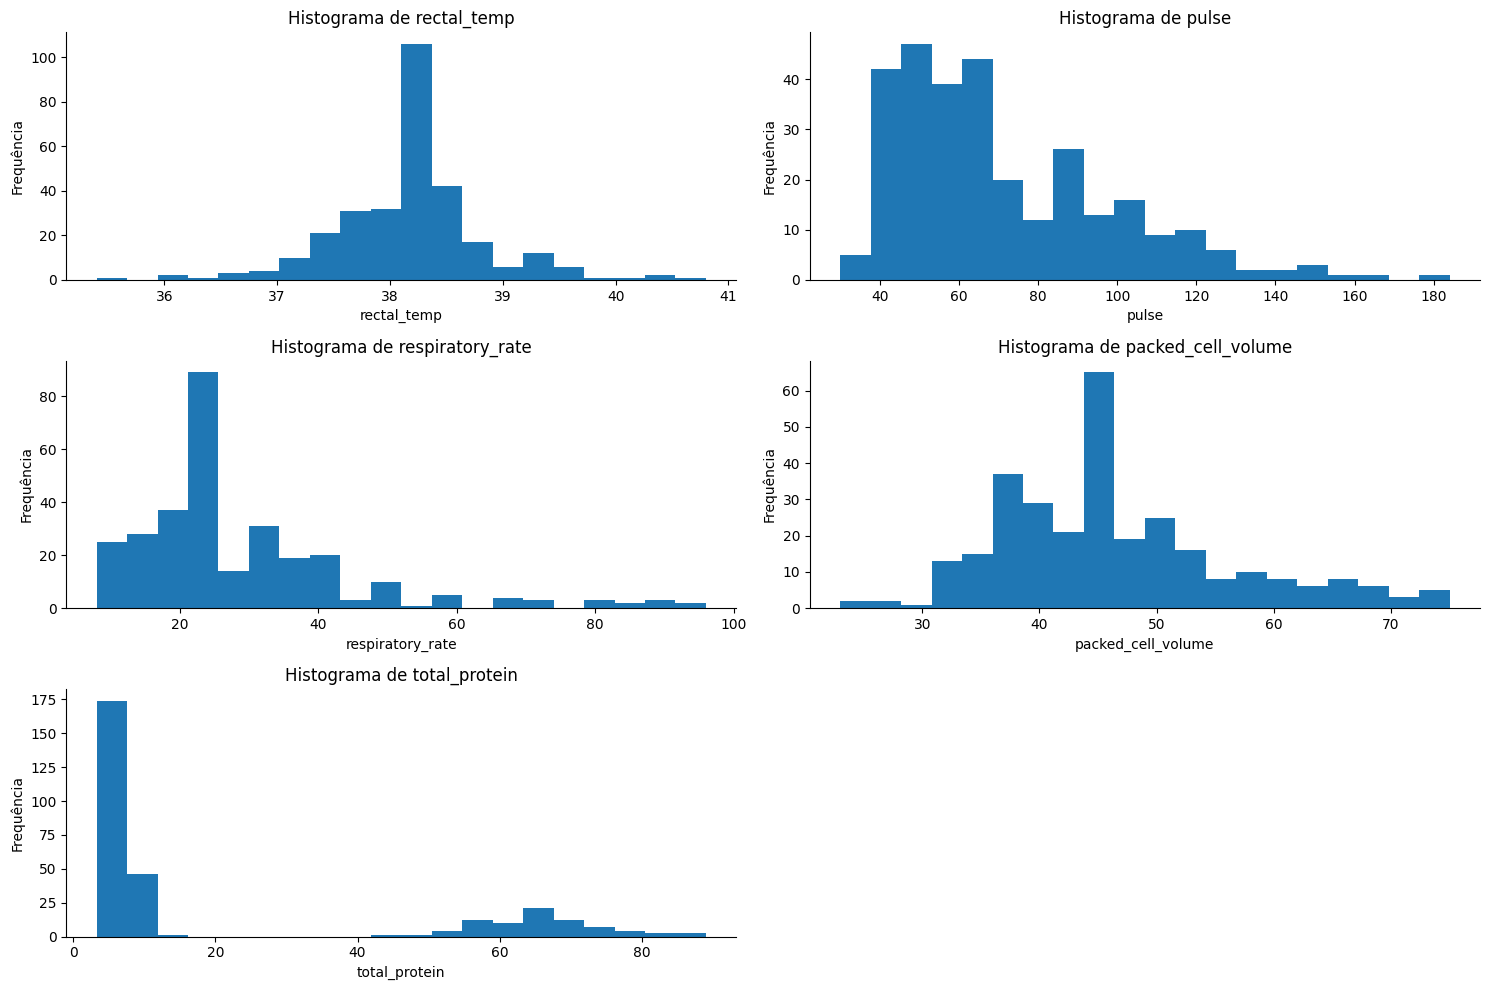

In [ ]:
# Análise de histograma dos atributos numéricos que tem missing

# Definir as colunas que serão plotadas
columns_to_plot_test = ['rectal_temp', 'pulse', 'respiratory_rate', 'packed_cell_volume', 'total_protein']

# Definir o número de bins para os histogramas
num_bins = 20

# Definir o tamanho da figura
plt.figure(figsize=(15, 10))

# Loop sobre as colunas e plotar os histogramas
for i, column in enumerate(columns_to_plot_test, 1):
    plt.subplot(3, 2, i)
    plt.hist(data_missing[column], bins=num_bins)
    plt.title(f'Histograma de {column}')
    plt.xlabel(column)
    plt.ylabel('Frequência')
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)

# Ajustar o layout e exibir os histogramas
plt.tight_layout()
plt.show()

In [ ]:
# Calcular a mediana de cada coluna numérica que contém missing values
median_rectal_temp = test_missing['rectal_temp'].median()
median_pulse = test_missing['pulse'].median()
median_respiratory_rate = test_missing['respiratory_rate'].median()
median_packed_cell_volume = test_missing['packed_cell_volume'].median()
median_total_protein = test_missing['total_protein'].median()

# Preencher os valores faltantes nas colunas especificadas com as medianas correspondentes
test_missing['rectal_temp'].fillna(median_rectal_temp, inplace=True)
test_missing['pulse'].fillna(median_pulse, inplace=True)
test_missing['respiratory_rate'].fillna(median_respiratory_rate, inplace=True)
test_missing['packed_cell_volume'].fillna(median_packed_cell_volume, inplace=True)
test_missing['total_protein'].fillna(median_total_protein, inplace=True)

In [ ]:
# Filtrar colunas do tipo float
float_columns = data_missing.select_dtypes(include=['float']).columns

# Calcular a soma de valores ausentes apenas para as colunas float
missing_float_values = data_missing[float_columns].isnull().sum()

# Imprimir o resultado
print(missing_float_values)

rectal_temp           0
pulse                 0
respiratory_rate      0
packed_cell_volume    0
total_protein         0
dtype: int64

In [ ]:
test_missing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89 entries, 0 to 88
Data columns (total 25 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   surgery                89 non-null     object 
 1   age                    89 non-null     object 
 2   hospital_number        89 non-null     int64  
 3   rectal_temp            89 non-null     float64
 4   pulse                  89 non-null     float64
 5   respiratory_rate       89 non-null     float64
 6   temp_of_extremities    76 non-null     object 
 7   peripheral_pulse       70 non-null     object 
 8   mucous_membrane        79 non-null     object 
 9   capillary_refill_time  85 non-null     object 
 10  pain                   77 non-null     object 
 11  peristalsis            79 non-null     object 
 12  abdominal_distention   77 non-null     object 
 13  nasogastric_tube       66 non-null     object 
 14  nasogastric_reflux     61 non-null     object 
 15  rectal_e

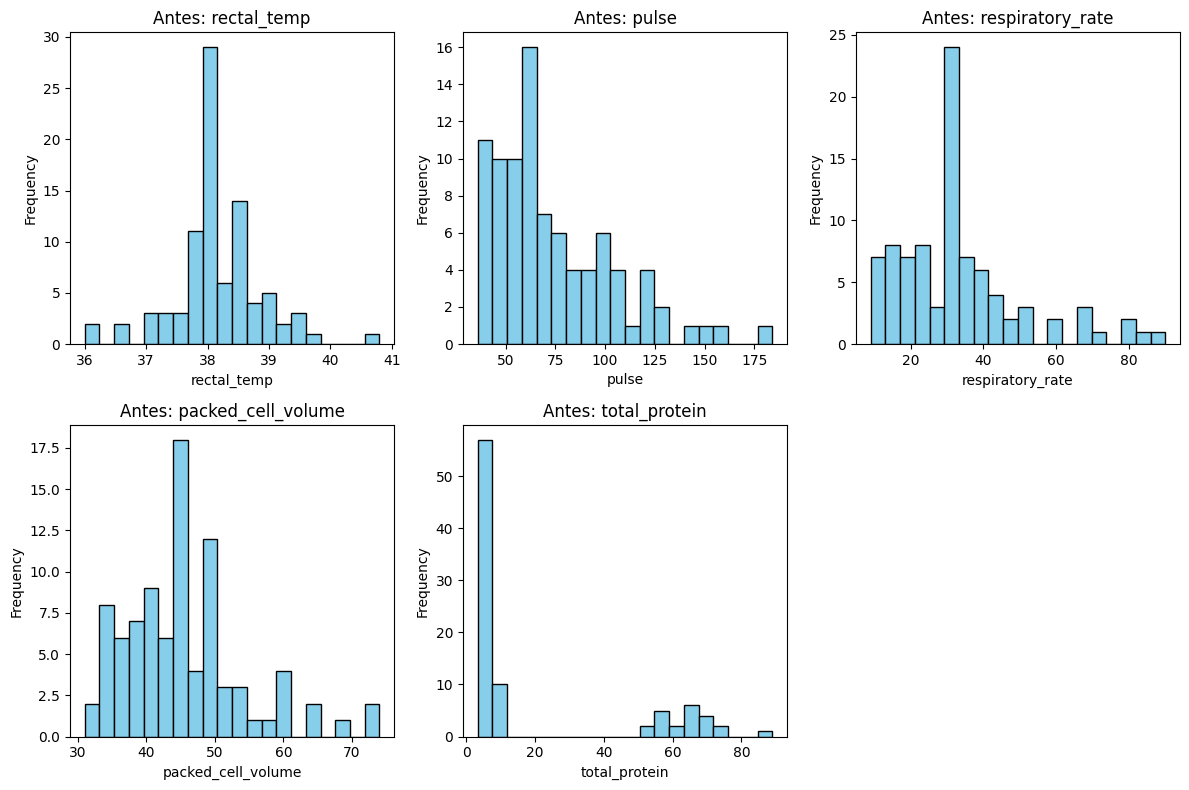

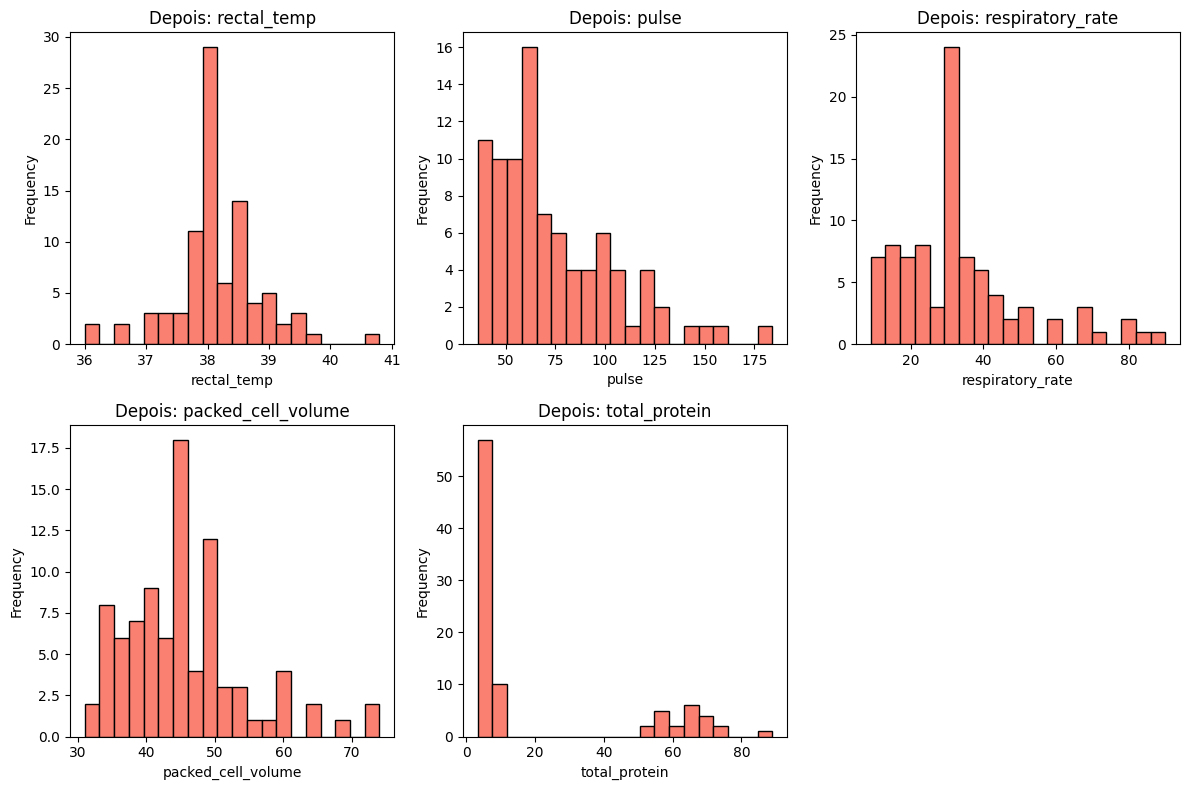

In [ ]:
#Fazer a comparação da distribuição de dados antes e depois do tratamento de missing values

# Definir as colunas para os histogramas
columns_to_plot = ['rectal_temp', 'pulse', 'respiratory_rate', 'packed_cell_volume', 'total_protein']

# Criar histogramas antes do tratamento de valores ausentes
plt.figure(figsize=(12, 8))
for i, column in enumerate(columns_to_plot):
    plt.subplot(2, 3, i+1)
    plt.hist(test_missing[column], bins=20, color='skyblue', edgecolor='black')
    plt.title(f'Antes: {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# Criar histogramas depois do tratamento de valores ausentes
plt.figure(figsize=(12, 8))
for i, column in enumerate(columns_to_plot):
    plt.subplot(2, 3, i+1)
    plt.hist(test_missing[column].fillna(test_missing[column].median()), bins=20, color='salmon', edgecolor='black')
    plt.title(f'Depois: {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')

# Ajustar o layout e mostrar os subplots
plt.tight_layout()
plt.show()

####*Tratamento das colunas que tem missing values e que os registros são valores categóricos*

In [ ]:
#Até agora, então, retiramos todos os valores ausentes das colunas do tipo numéricas. Temos de tratar as 11 colunas abaixo que são categóricas que ainda ficaram com missing values:

def summary(test_missing):
    # Calcula a porcentagem de missing values apenas para as colunas que possuem valores ausentes
    missing_percentage = (test_missing.isna().sum() * 100) / len(test_missing)
    missing_percentage = missing_percentage[missing_percentage > 0]

    if not missing_percentage.empty:
        # Cria um DataFrame com as porcentagens de valores ausentes
        sum = pd.DataFrame({'missing%': missing_percentage})

        # Adiciona o tipo de dado (dtype) de cada coluna ao DataFrame
        sum['dtype'] = test_missing.dtypes

        # Ordena o DataFrame com base na porcentagem de valores ausentes
        sum.sort_values(by='missing%', ascending=False, inplace=True)

        return sum

    #Se não houver colunas com valores ausentes, exibe a mensagem abaixo
    else:
        print("Não há colunas com valores ausentes.")

# Chama a função summary e aplica um estilo de gradiente de cor
summary_df = summary(test_missing)
summary_df.style.background_gradient(cmap='BuGn')

In [ ]:
# Calcular a moda de cada coluna categórica
mode_values_test = data_missing.select_dtypes(include=['object']).mode()

In [ ]:
mode_values_test

surgery    age temp_of_extremities peripheral_pulse mucous_membrane  \
0     yes  adult                cool           normal     normal_pink   

  capillary_refill_time       pain peristalsis abdominal_distention  \
0            less_3_sec  mild_pain  hypomotile                 none   

  nasogastric_tube nasogastric_reflux rectal_exam_feces        abdomen  \
0           slight               none            absent  distend_large   

  outcome surgical_lesion cp_data  
0   lived             yes      no

In [ ]:
# Preencher os valores faltantes com as modas correspondentes
test_missing.fillna(mode_values_test.iloc[0], inplace=True)

In [ ]:
test_missing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89 entries, 0 to 88
Data columns (total 25 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   surgery                89 non-null     object 
 1   age                    89 non-null     object 
 2   hospital_number        89 non-null     int64  
 3   rectal_temp            89 non-null     float64
 4   pulse                  89 non-null     float64
 5   respiratory_rate       89 non-null     float64
 6   temp_of_extremities    89 non-null     object 
 7   peripheral_pulse       89 non-null     object 
 8   mucous_membrane        89 non-null     object 
 9   capillary_refill_time  89 non-null     object 
 10  pain                   89 non-null     object 
 11  peristalsis            89 non-null     object 
 12  abdominal_distention   89 non-null     object 
 13  nasogastric_tube       89 non-null     object 
 14  nasogastric_reflux     89 non-null     object 
 15  rectal_e

####Visualização do tratamento de missing values

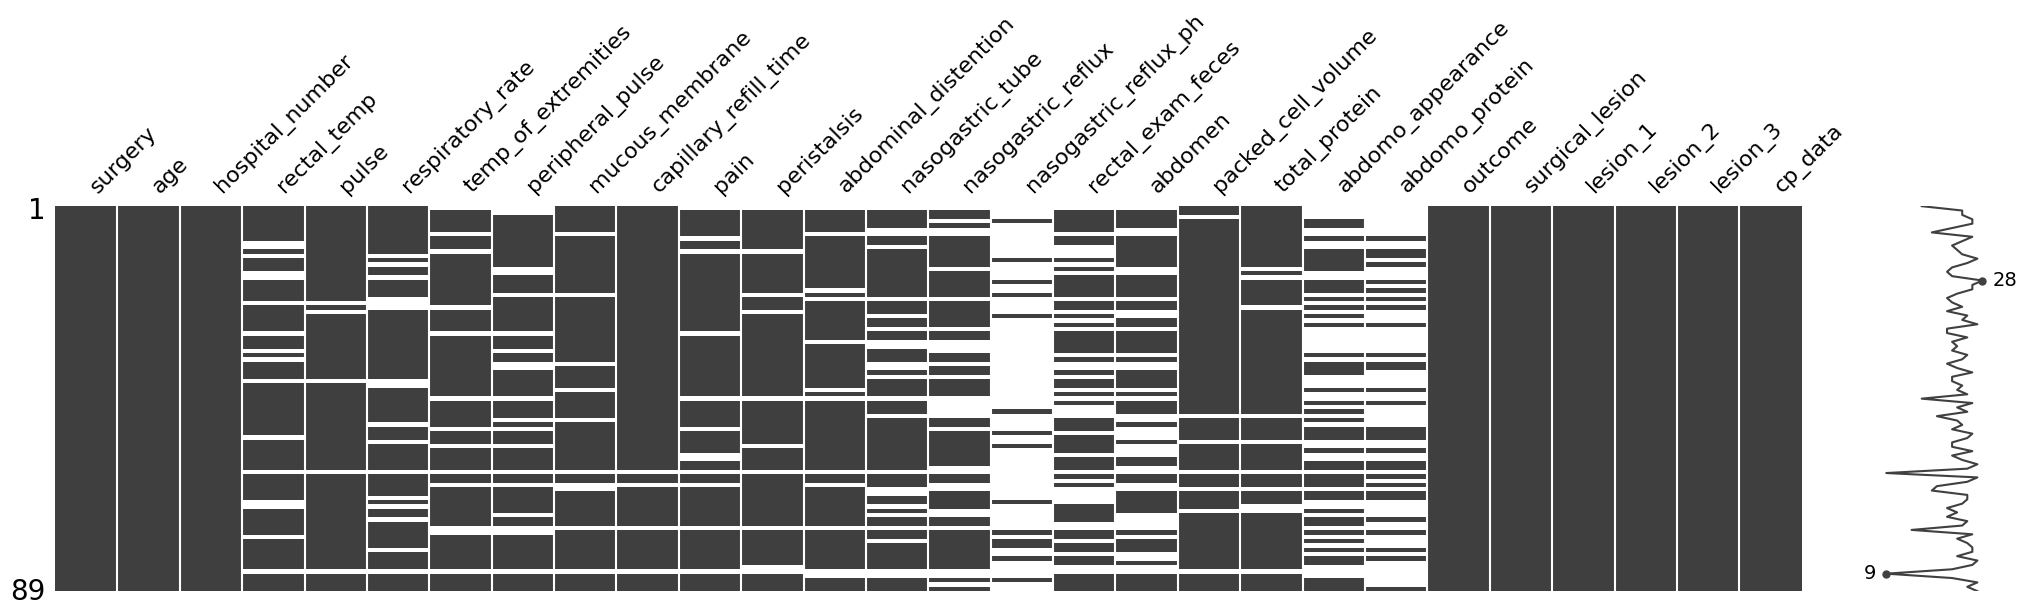

In [ ]:
# Visualização dos valores ausentes da base
msno.matrix(test, figsize=(25,5));

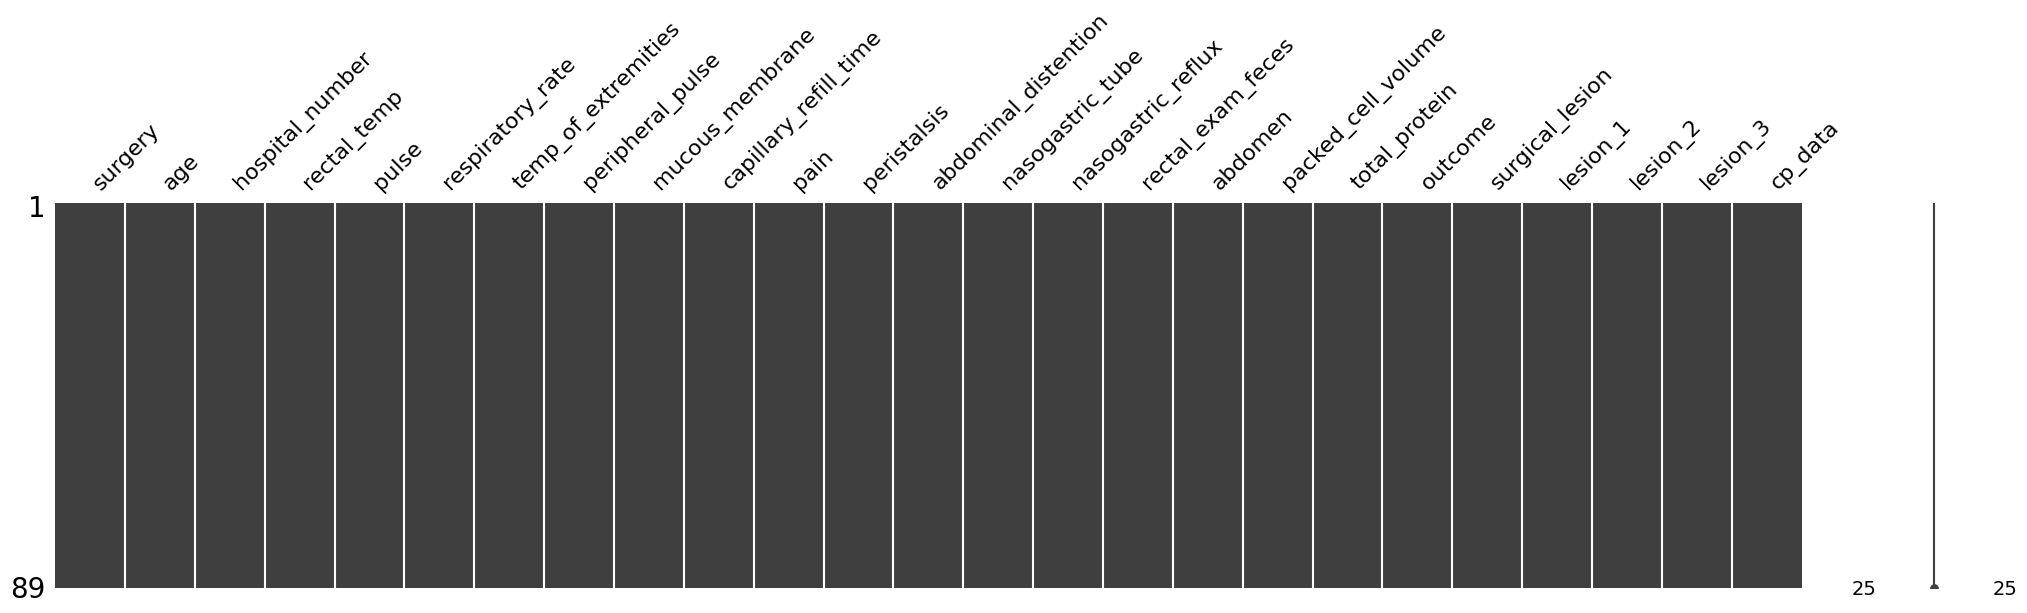

In [ ]:
# Visualização dos valores ausentes da base após o tratamento
msno.matrix(test_missing, figsize=(25,5));

In [ ]:
test_missing.isnull().sum()

surgery                  0
age                      0
hospital_number          0
rectal_temp              0
pulse                    0
respiratory_rate         0
temp_of_extremities      0
peripheral_pulse         0
mucous_membrane          0
capillary_refill_time    0
pain                     0
peristalsis              0
abdominal_distention     0
nasogastric_tube         0
nasogastric_reflux       0
rectal_exam_feces        0
abdomen                  0
packed_cell_volume       0
total_protein            0
outcome                  0
surgical_lesion          0
lesion_1                 0
lesion_2                 0
lesion_3                 0
cp_data                  0
dtype: int64

###*Seleção/Extração dos Atributos*

#### Atributo capillary_refill_time

Assim como na base de treino, a base de teste também possui a classe '3' dentro da coluna 'capillary_refill_time' com poucos valores: enquanto na base de treino eram dois, aqui na de teste são 2. Com isso, essas linhas também serão excluídas.

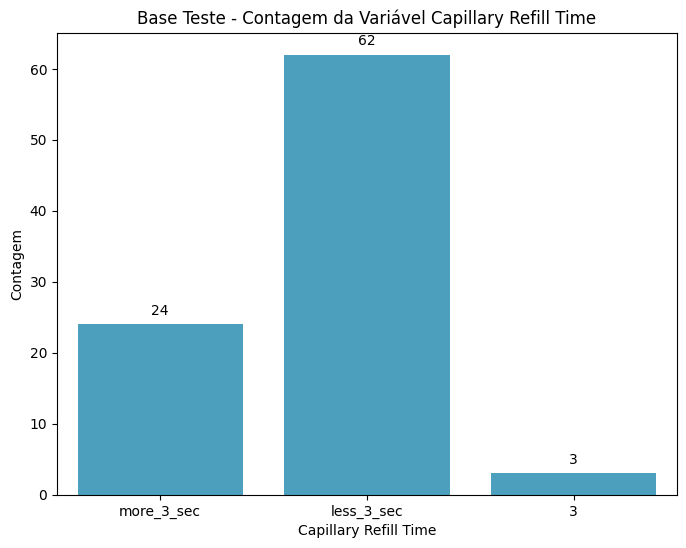

In [ ]:
# Definindo a cor desejada
color = sns.color_palette("husl", 8)[5]

# Criando o gráfico de barras para a variável capillary_refill_time
plt.figure(figsize=(8, 6))
sns.countplot(data=test_missing, x='capillary_refill_time', color=color)
plt.title('Base Teste - Contagem da Variável Capillary Refill Time')
plt.xlabel('Capillary Refill Time')
plt.ylabel('Contagem')

# Adicionando rótulos às barras
for p in plt.gca().patches:
    plt.gca().annotate(format(p.get_height(), '.0f'),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'bottom',
                xytext = (0, 5),
                textcoords = 'offset points')

plt.show()

#### *Atributos: hospital_number e lesion_1 / lesion_2 / lesion_3*

Assim como na base de treinamento, os atributos hospital_number, lesion_2 e lesion_3 não tem associação significativa com a variável alvo, e com isso, serão removidos.

In [ ]:
# Crie uma tabela de contingência
tabela_contingencia = pd.crosstab(test_missing['hospital_number'], test_missing['outcome'])

# Realize o teste qui-quadrado
estatisticas, pvalor, graus_liberdade, tabela_esperada = chi2_contingency(tabela_contingencia)

# Interprete o resultado
print("Valor p:", pvalor)

if pvalor < 0.05:
    print("[bold green3]Existe uma associação significativa entre as variáveis.")
else:
    print("[bold red3]Não há evidência de associação significativa.[/]")

Valor p: 0.4436549892989631

Não há evidência de associação significativa.

In [ ]:
# Crie uma tabela de contingência
tabela_contingencia = pd.crosstab(test_missing['lesion_1'], test_missing['outcome'])

# Realize o teste qui-quadrado
estatisticas, pvalor, graus_liberdade, tabela_esperada = chi2_contingency(tabela_contingencia)

# Interprete o resultado
print("Valor p:", pvalor)

if pvalor < 0.05:
    print("[bold green3]Existe uma associação significativa entre as variáveis.")
else:
    print("[bold red3]Não há evidência de associação significativa.[/]")

Valor p: 0.005938911641252402

Existe uma associação significativa entre as variáveis.

In [ ]:
# Crie uma tabela de contingência
tabela_contingencia = pd.crosstab(test_missing['lesion_2'], test_missing['outcome'])

# Realize o teste qui-quadrado
estatisticas, pvalor, graus_liberdade, tabela_esperada = chi2_contingency(tabela_contingencia)

# Interprete o resultado
print("Valor p:", pvalor)

if pvalor < 0.05:
    print("[bold green3]Existe uma associação significativa entre as variáveis.")
else:
    print("[bold red3]Não há evidência de associação significativa.[/]")

Valor p: 0.82805407095134

Não há evidência de associação significativa.

In [ ]:
# Crie uma tabela de contingência
tabela_contingencia = pd.crosstab(test_missing['lesion_3'], test_missing['outcome'])

# Realize o teste qui-quadrado
estatisticas, pvalor, graus_liberdade, tabela_esperada = chi2_contingency(tabela_contingencia)

# Interprete o resultado
print("Valor p:", pvalor)

if pvalor < 0.05:
    print("[bold green3]Existe uma associação significativa entre as variáveis.")
else:
    print("[bold red3]Não há evidência de associação significativa.[/]")

Valor p: 0.7092962556617779

Não há evidência de associação significativa.

#### *Exclusão dos atributos*

In [ ]:
# Como também são poucas linhas, foram removidas as linhas que contêm o valor '3' na coluna 'capillary_refill_time'
test_cleaned = test_missing[test_missing['capillary_refill_time'] != '3'].copy()

In [ ]:
test_cleaned.drop(['hospital_number', 'lesion_2', 'lesion_3'], axis=1, inplace=True)

In [ ]:
test_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 86 entries, 0 to 88
Data columns (total 22 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   surgery                86 non-null     object 
 1   age                    86 non-null     object 
 2   rectal_temp            86 non-null     float64
 3   pulse                  86 non-null     float64
 4   respiratory_rate       86 non-null     float64
 5   temp_of_extremities    86 non-null     object 
 6   peripheral_pulse       86 non-null     object 
 7   mucous_membrane        86 non-null     object 
 8   capillary_refill_time  86 non-null     object 
 9   pain                   86 non-null     object 
 10  peristalsis            86 non-null     object 
 11  abdominal_distention   86 non-null     object 
 12  nasogastric_tube       86 non-null     object 
 13  nasogastric_reflux     86 non-null     object 
 14  rectal_exam_feces      86 non-null     object 
 15  abdomen      

###*Normalização*

In [ ]:
# Selecionando apenas as colunas numéricas para normalização
colunas_numericas_test = ['rectal_temp', 'pulse', 'respiratory_rate', 'packed_cell_volume', 'total_protein']
dados_numericos_test = test_cleaned[colunas_numericas_test]

# Normalização dos dados
normalizacao = MinMaxScaler()
test_normalizado = normalizacao.fit_transform(dados_numericos_test)


In [ ]:
# Convertendo os dados normalizados de volta em um DataFrame
df_numerico_test = pd.DataFrame(test_normalizado, columns=colunas_numericas_test)

In [ ]:
df_numerico_test

rectal_temp     pulse  respiratory_rate  packed_cell_volume  total_protein
0      0.270833  0.459459          0.320988            1.000000       0.047841
1      0.645833  0.243243          0.530864            0.441860       0.052509
2      0.250000  0.040541          0.037037            0.302326       0.043174
3      0.416667  0.378378          0.234568            0.139535       0.032672
4      0.333333  0.189189          0.148148            0.209302       0.043174
..          ...       ...               ...                 ...            ...
81     0.437500  0.195946          0.259259            0.302326       0.046674
82     0.541667  0.060811          0.086420            0.279070       0.638273
83     0.604167  0.297297          0.432099            0.534884       0.037340
84     0.208333  0.202703          0.135802            0.093023       0.042007
85     0.104167  0.432432          0.185185            0.441860       0.031505

[86 rows x 5 columns]

In [ ]:
# Substituindo os valores normalizados de volta no DataFrame
test_cleaned.loc[:, colunas_numericas_test] = test_normalizado

# Agora test_cleaned contém os valores normalizados das colunas numéricas, mantendo as colunas categóricas existentes

In [ ]:
test_cleaned

surgery    age  rectal_temp     pulse  respiratory_rate  \
0       no  adult     0.270833  0.459459          0.320988   
1       no  adult     0.645833  0.243243          0.530864   
2      yes  adult     0.250000  0.040541          0.037037   
3       no  young     0.416667  0.378378          0.234568   
4      yes  adult     0.333333  0.189189          0.148148   
..     ...    ...          ...       ...               ...   
84     yes  adult     0.437500  0.195946          0.259259   
85      no  adult     0.541667  0.060811          0.086420   
86     yes  adult     0.604167  0.297297          0.432099   
87     yes  adult     0.208333  0.202703          0.135802   
88     yes  adult     0.104167  0.432432          0.185185   

   temp_of_extremities peripheral_pulse mucous_membrane capillary_refill_time  \
0                 cool           normal   dark_cyanotic            more_3_sec   
1                 warm           normal     bright_pink            less_3_sec   
2                 warm           normal     normal_pink            less_3_sec   
3               normal           normal     bright_pink            less_3_sec   
4               normal           normal     bright_pink            less_3_sec   
..                 ...              ...             ...                   ...   
84                cool           normal     normal_pink            less_3_sec   
85                warm           normal     bright_pink            less_3_sec   
86                cool          reduced       pale_pink            less_3_sec   
87              normal          reduced     bright_pink            less_3_sec   
88                cool          reduced       pale_pink            less_3_sec   

           pain  ... nasogastric_tube nasogastric_reflux rectal_exam_feces  \
0     mild_pain  ...           slight               none            absent   
1     depressed  ...             none               none            absent   
2     mild_pain  ...      significant               none            absent   
3         alert  ...      significant               none            normal   
4     depressed  ...             none               none         increased   
..          ...  ...              ...                ...               ...   
84    mild_pain  ...           slight               none            absent   
85        alert  ...           slight               none            normal   
86    depressed  ...           slight       less_1_liter         decreased   
87  severe_pain  ...             none               none            normal   
88    mild_pain  ...      significant               none            absent   

          abdomen packed_cell_volume total_protein  outcome  surgical_lesion  \
0   distend_large           1.000000      0.047841     died               no   
1   distend_small           0.441860      0.052509    lived              yes   
2   distend_large           0.302326      0.043174    lived               no   
3          normal           0.139535      0.032672     died               no   
4   distend_large           0.209302      0.043174    lived              yes   
..            ...                ...           ...      ...              ...   
84  distend_large           0.302326      0.046674    lived              yes   
85         normal           0.279070      0.638273    lived               no   
86         normal           0.534884      0.037340     died              yes   
87  distend_large           0.093023      0.042007     died              yes   
88  distend_small           0.441860      0.031505    lived              yes   

   lesion_1 cp_data  
0      4300      no  
1      2111      no  
2      4124      no  
3         0     yes  
4      4205     yes  
..      ...     ...  
84     2124      no  
85        0      no  
86     7111      no  
87    31110      no  
88     2208     yes  

[86 rows x 22 columns]

In [ ]:
test_normalizado

array([[0.27083333, 0.45945946, 0.32098765, 1.        , 0.04784131],
       [0.64583333, 0.24324324, 0.5308642 , 0.44186047, 0.05250875],
       [0.25      , 0.04054054, 0.03703704, 0.30232558, 0.04317386],
       [0.41666667, 0.37837838, 0.2345679 , 0.13953488, 0.03267211],
       [0.33333333, 0.18918919, 0.14814815, 0.20930233, 0.04317386],
       [0.47916667, 0.63513514, 0.62962963, 0.44186047, 0.77829638],
       [0.375     , 0.08108108, 0.03703704, 0.13953488, 0.02567095],
       [0.4375    , 0.43243243, 0.25925926, 0.48837209, 0.03850642],
       [0.4375    , 0.45945946, 0.18518519, 0.97674419, 0.05950992],
       [0.47916667, 0.51351351, 0.08641975, 0.46511628, 0.03150525],
       [0.4375    , 0.56756757, 0.25925926, 0.48837209, 0.74329055],
       [0.60416667, 0.2972973 , 0.43209877, 0.53488372, 0.03733956],
       [0.54166667, 0.06756757, 0.25925926, 0.41860465, 0.06767795],
       [0.54166667, 0.83783784, 0.13580247, 0.1627907 , 0.04667445],
       [0.4375    , 0.18918919, 0.

### *Separação das Variáveis Explicativas da Variável Alvo*

In [ ]:
# No X, estão todas as colunas, menos a variável alvo. Enquanto no Y, está somente a variável alvo.
# Atributos (X) e Target (y)

x_teste = test_cleaned.drop('outcome', axis = 1)
y_teste = test_cleaned['outcome']

In [ ]:
x_teste.info()

<class 'pandas.core.frame.DataFrame'>
Index: 86 entries, 0 to 88
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   surgery                86 non-null     object 
 1   age                    86 non-null     object 
 2   rectal_temp            86 non-null     float64
 3   pulse                  86 non-null     float64
 4   respiratory_rate       86 non-null     float64
 5   temp_of_extremities    86 non-null     object 
 6   peripheral_pulse       86 non-null     object 
 7   mucous_membrane        86 non-null     object 
 8   capillary_refill_time  86 non-null     object 
 9   pain                   86 non-null     object 
 10  peristalsis            86 non-null     object 
 11  abdominal_distention   86 non-null     object 
 12  nasogastric_tube       86 non-null     object 
 13  nasogastric_reflux     86 non-null     object 
 14  rectal_exam_feces      86 non-null     object 
 15  abdomen      

In [ ]:
y_teste.info()

<class 'pandas.core.series.Series'>
Index: 86 entries, 0 to 88
Series name: outcome
Non-Null Count  Dtype 
--------------  ----- 
86 non-null     object
dtypes: object(1)
memory usage: 1.3+ KB


###*Tratamento das Variáveis Categóricas*

In [ ]:
# Quando os novos nomes de colunas forem gerados, perderemos o acesso ao nome das colunas que já temos.
# Para solucionar isto, armazenaremos essa informação em uma variável coluna.

colunas_test = x_teste.columns

In [ ]:
colunas_test

Index(['surgery', 'age', 'rectal_temp', 'pulse', 'respiratory_rate',
       'temp_of_extremities', 'peripheral_pulse', 'mucous_membrane',
       'capillary_refill_time', 'pain', 'peristalsis', 'abdominal_distention',
       'nasogastric_tube', 'nasogastric_reflux', 'rectal_exam_feces',
       'abdomen', 'packed_cell_volume', 'total_protein', 'surgical_lesion',
       'lesion_1', 'cp_data'],
      dtype='object')

In [ ]:
# Criar o Column Transformer

one_hot = make_column_transformer((
    OneHotEncoder(drop = 'if_binary'),
    ['surgery', 'age', 'temp_of_extremities', 'peripheral_pulse', 'mucous_membrane', 'capillary_refill_time', 'pain', 'peristalsis', 'abdominal_distention', 'nasogastric_tube', 'nasogastric_reflux', 'rectal_exam_feces', 'abdomen', 'surgical_lesion', 'lesion_1', 'cp_data']
                                  ),
    remainder = 'passthrough',
    sparse_threshold=0
                                  )

In [ ]:
# Aplicar o One Hot Encoder
x_teste = one_hot.fit_transform(x_teste)

In [ ]:
x_teste

array([[0.        , 0.        , 0.        , ..., 0.32098765, 1.        ,
        0.04784131],
       [0.        , 0.        , 0.        , ..., 0.5308642 , 0.44186047,
        0.05250875],
       [1.        , 0.        , 0.        , ..., 0.03703704, 0.30232558,
        0.04317386],
       ...,
       [1.        , 0.        , 0.        , ..., 0.43209877, 0.53488372,
        0.03733956],
       [1.        , 0.        , 0.        , ..., 0.13580247, 0.09302326,
        0.042007  ],
       [1.        , 0.        , 0.        , ..., 0.18518519, 0.44186047,
        0.03150525]])

In [ ]:
# Transformar os dados tratados em um DataFrame do Pandas

# Converter x_teste
df_x_teste = pd.DataFrame(x_teste, columns = one_hot.get_feature_names_out(colunas_test))

In [ ]:
df_x_teste

onehotencoder__surgery_yes  onehotencoder__age_young  \
0                          0.0                       0.0   
1                          0.0                       0.0   
2                          1.0                       0.0   
3                          0.0                       1.0   
4                          1.0                       0.0   
..                         ...                       ...   
81                         1.0                       0.0   
82                         0.0                       0.0   
83                         1.0                       0.0   
84                         1.0                       0.0   
85                         1.0                       0.0   

    onehotencoder__temp_of_extremities_cold  \
0                                       0.0   
1                                       0.0   
2                                       0.0   
3                                       0.0   
4                                       0.0   
..                                      ...   
81                                      0.0   
82                                      0.0   
83                                      0.0   
84                                      0.0   
85                                      0.0   

    onehotencoder__temp_of_extremities_cool  \
0                                       1.0   
1                                       0.0   
2                                       0.0   
3                                       0.0   
4                                       0.0   
..                                      ...   
81                                      1.0   
82                                      0.0   
83                                      1.0   
84                                      0.0   
85                                      1.0   

    onehotencoder__temp_of_extremities_normal  \
0                                         0.0   
1                                         0.0   
2                                         0.0   
3                                         1.0   
4                                         1.0   
..                                        ...   
81                                        0.0   
82                                        0.0   
83                                        0.0   
84                                        1.0   
85                                        0.0   

    onehotencoder__temp_of_extremities_warm  \
0                                       0.0   
1                                       1.0   
2                                       1.0   
3                                       0.0   
4                                       0.0   
..                                      ...   
81                                      0.0   
82                                      1.0   
83                                      0.0   
84                                      0.0   
85                                      0.0   

    onehotencoder__peripheral_pulse_absent  \
0                                      0.0   
1                                      0.0   
2                                      0.0   
3                                      0.0   
4                                      0.0   
..                                     ...   
81                                     0.0   
82                                     0.0   
83                                     0.0   
84                                     0.0   
85                                     0.0   

    onehotencoder__peripheral_pulse_increased  \
0                                         0.0   
1                                         0.0   
2                                         0.0   
3                                         0.0   
4                                         0.0   
..                                        ...   
81                                        0.0   
82                                        0.0   
83   

In [ ]:
df_x_teste.columns

Index(['onehotencoder__surgery_yes', 'onehotencoder__age_young',
       'onehotencoder__temp_of_extremities_cold',
       'onehotencoder__temp_of_extremities_cool',
       'onehotencoder__temp_of_extremities_normal',
       'onehotencoder__temp_of_extremities_warm',
       'onehotencoder__peripheral_pulse_absent',
       'onehotencoder__peripheral_pulse_increased',
       'onehotencoder__peripheral_pulse_normal',
       'onehotencoder__peripheral_pulse_reduced',
       'onehotencoder__mucous_membrane_bright_pink',
       'onehotencoder__mucous_membrane_bright_red',
       'onehotencoder__mucous_membrane_dark_cyanotic',
       'onehotencoder__mucous_membrane_normal_pink',
       'onehotencoder__mucous_membrane_pale_cyanotic',
       'onehotencoder__mucous_membrane_pale_pink',
       'onehotencoder__capillary_refill_time_more_3_sec',
       'onehotencoder__pain_alert', 'onehotencoder__pain_depressed',
       'onehotencoder__pain_extreme_pain', 'onehotencoder__pain_mild_pain',
       'one

In [ ]:
# Classes ausentes que precisam ser adicionadas como colunas
classes_ausentes = [2305, 3207, 4111, 2322, 5400, 2207, 11300, 9000, 3113, 3115, 300, 3124, 9400, 3133, 6209,
                    3400, 7113, 8400, 6112, 3300, 7400, 8300, 11124, 5111, 2300]

# Adicionar colunas ausentes no df_x_teste com valores 0.0 no formato float
for classe in classes_ausentes:
    col_name = f'onehotencoder__lesion_1_{classe}'
    if col_name not in df_x_teste.columns:
        df_x_teste[col_name] = 0.0

In [ ]:
# Verificar as colunas adicionadas e seus valores
df_x_teste[["onehotencoder__lesion_1_" + str(classe) for classe in classes_ausentes]].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86 entries, 0 to 85
Data columns (total 25 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   onehotencoder__lesion_1_2305   86 non-null     float64
 1   onehotencoder__lesion_1_3207   86 non-null     float64
 2   onehotencoder__lesion_1_4111   86 non-null     float64
 3   onehotencoder__lesion_1_2322   86 non-null     float64
 4   onehotencoder__lesion_1_5400   86 non-null     float64
 5   onehotencoder__lesion_1_2207   86 non-null     float64
 6   onehotencoder__lesion_1_11300  86 non-null     float64
 7   onehotencoder__lesion_1_9000   86 non-null     float64
 8   onehotencoder__lesion_1_3113   86 non-null     float64
 9   onehotencoder__lesion_1_3115   86 non-null     float64
 10  onehotencoder__lesion_1_300    86 non-null     float64
 11  onehotencoder__lesion_1_3124   86 non-null     float64
 12  onehotencoder__lesion_1_9400   86 non-null     float

In [ ]:
df_x_teste

onehotencoder__surgery_yes  onehotencoder__age_young  \
0                          0.0                       0.0   
1                          0.0                       0.0   
2                          1.0                       0.0   
3                          0.0                       1.0   
4                          1.0                       0.0   
..                         ...                       ...   
81                         1.0                       0.0   
82                         0.0                       0.0   
83                         1.0                       0.0   
84                         1.0                       0.0   
85                         1.0                       0.0   

    onehotencoder__temp_of_extremities_cold  \
0                                       0.0   
1                                       0.0   
2                                       0.0   
3                                       0.0   
4                                       0.0   
..                                      ...   
81                                      0.0   
82                                      0.0   
83                                      0.0   
84                                      0.0   
85                                      0.0   

    onehotencoder__temp_of_extremities_cool  \
0                                       1.0   
1                                       0.0   
2                                       0.0   
3                                       0.0   
4                                       0.0   
..                                      ...   
81                                      1.0   
82                                      0.0   
83                                      1.0   
84                                      0.0   
85                                      1.0   

    onehotencoder__temp_of_extremities_normal  \
0                                         0.0   
1                                         0.0   
2                                         0.0   
3                                         1.0   
4                                         1.0   
..                                        ...   
81                                        0.0   
82                                        0.0   
83                                        0.0   
84                                        1.0   
85                                        0.0   

    onehotencoder__temp_of_extremities_warm  \
0                                       0.0   
1                                       1.0   
2                                       1.0   
3                                       0.0   
4                                       0.0   
..                                      ...   
81                                      0.0   
82                                      1.0   
83                                      0.0   
84                                      0.0   
85                                      0.0   

    onehotencoder__peripheral_pulse_absent  \
0                                      0.0   
1                                      0.0   
2                                      0.0   
3                                      0.0   
4                                      0.0   
..                                     ...   
81                                     0.0   
82                                     0.0   
83                                     0.0   
84                                     0.0   
85                                     0.0   

    onehotencoder__peripheral_pulse_increased  \
0                                         0.0   
1                                         0.0   
2                                         0.0   
3                                         0.0   
4                                         0.0   
..                                        ...   
81                                        0.0   
82                                        0.0   
83   

In [ ]:
df_x_teste.columns

Index(['onehotencoder__surgery_yes', 'onehotencoder__age_young',
       'onehotencoder__temp_of_extremities_cold',
       'onehotencoder__temp_of_extremities_cool',
       'onehotencoder__temp_of_extremities_normal',
       'onehotencoder__temp_of_extremities_warm',
       'onehotencoder__peripheral_pulse_absent',
       'onehotencoder__peripheral_pulse_increased',
       'onehotencoder__peripheral_pulse_normal',
       'onehotencoder__peripheral_pulse_reduced',
       ...
       'onehotencoder__lesion_1_3400', 'onehotencoder__lesion_1_7113',
       'onehotencoder__lesion_1_8400', 'onehotencoder__lesion_1_6112',
       'onehotencoder__lesion_1_3300', 'onehotencoder__lesion_1_7400',
       'onehotencoder__lesion_1_8300', 'onehotencoder__lesion_1_11124',
       'onehotencoder__lesion_1_5111', 'onehotencoder__lesion_1_2300'],
      dtype='object', length=113)

In [ ]:
# Checar como foram preenchidas as novas colunas das classes faltantes na base de teste

def summary(df_x_teste):
    # Filtra as colunas que possuem 'lesion_1' no nome
    lesion_cols = [col for col in df_x_teste.columns if 'lesion_1' in col]

    # Cria um DataFrame com informações resumidas das colunas filtradas
    sum = pd.DataFrame(df_x_teste[lesion_cols].dtypes, columns=['dtypes'])
    sum['uniques'] = df_x_teste[lesion_cols].nunique().values
    sum['classes'] = [df_x_teste[col].unique().tolist() for col in lesion_cols]

    return sum

# Chama a função summary e aplica um estilo de gradiente de cor
summary(df_x_teste).style.background_gradient(cmap='Set3')


###*Tratamento da Variável Alvo*

In [ ]:
# Aplicando o Label Encoder aos dados
y_teste = label_encoder.fit_transform(y_teste)

In [ ]:
y_teste

array([0, 2, 2, 0, 2, 2, 2, 2, 1, 1, 1, 0, 2, 0, 0, 0, 2, 2, 2, 1, 1, 2,
       0, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 2, 2, 2, 2, 0, 2, 2, 2, 0, 2, 2,
       2, 2, 2, 2, 1, 2, 2, 1, 2, 2, 2, 1, 0, 2, 2, 2, 0, 2, 2, 2, 1, 0,
       0, 2, 0, 1, 0, 2, 0, 1, 2, 0, 2, 0, 1, 2, 1, 2, 2, 0, 0, 2])

In [ ]:
# Ver qual é a ordem da codificação para cada saída: 0='died', 1='euthanized', 2='lived'
label_encoder.inverse_transform(y_teste)

array(['died', 'lived', 'lived', 'died', 'lived', 'lived', 'lived',
       'lived', 'euthanized', 'euthanized', 'euthanized', 'died', 'lived',
       'died', 'died', 'died', 'lived', 'lived', 'lived', 'euthanized',
       'euthanized', 'lived', 'died', 'lived', 'lived', 'lived', 'lived',
       'lived', 'lived', 'lived', 'lived', 'died', 'died', 'lived',
       'lived', 'lived', 'lived', 'died', 'lived', 'lived', 'lived',
       'died', 'lived', 'lived', 'lived', 'lived', 'lived', 'lived',
       'euthanized', 'lived', 'lived', 'euthanized', 'lived', 'lived',
       'lived', 'euthanized', 'died', 'lived', 'lived', 'lived', 'died',
       'lived', 'lived', 'lived', 'euthanized', 'died', 'died', 'lived',
       'died', 'euthanized', 'died', 'lived', 'died', 'euthanized',
       'lived', 'died', 'lived', 'died', 'euthanized', 'lived',
       'euthanized', 'lived', 'lived', 'died', 'died', 'lived'],
      dtype=object)

In [ ]:
# Transformar os dados tratados em um DataFrame do Pandas

# Converter y_teste
df_y_teste = pd.DataFrame(y_teste, columns=['variavel_alvo'])

In [ ]:
df_y_teste

variavel_alvo
0               0
1               2
2               2
3               0
4               2
..            ...
81              2
82              2
83              0
84              0
85              2

[86 rows x 1 columns]

##**Balanceamento**


Neste trabalho, foi utilizada a técnica SMOTE (Synthetic Minority Oversampling Technique) que cria novos exemplos sintéticos da classe minoritária para equilibrar as distribuições das categorias, criando exemplos sintéticos com base nos exemplos existentes.

In [ ]:
# Aplicando o SMOTE aos dados de treinamento originais
smote = SMOTE(random_state=42)   # Usando o random_state para garantir o padrão da amostra aleatória
df_x_treino_balanceado, df_y_treino_balanceado = smote.fit_resample(df_x_treino, df_y_treino)

In [ ]:
# Verificando a distribuição das classes antes do balanceamento
print("Contagem das classes da variável alvo antes do balanceamento:")
print(df_y_treino.value_counts())

Contagem das classes da variável alvo antes do balanceamento:

variavel_alvo
2                177
0                 76
1                 44
Name: count, dtype: int64

In [ ]:
# Verificando a distribuição das classes após o balanceamento
print("Contagem das classes da variável alvo após o balanceamento:")
print(df_y_treino_balanceado.value_counts())

# Agora, você pode usar os dados balanceados para treinar seus modelos

Contagem das classes da variável alvo após o balanceamento:

variavel_alvo
0                177
1                177
2                177
Name: count, dtype: int64

##**PCA (Análise de Componentes Principais)**

Para evitar o aumento na dimensionalidade dos dados, será aplicada a técnica PCA (Principal Component Analysis): técnica estatística que ajuda a lidar com muitas variáveis de uma vez, resumindo-as em poucas que capturam a maior parte da informação importante.

Treinar o PCA em cada conjunto de dados separadamente resulta em componentes principais diferentes e, consequentemente, em um número distinto de colunas. Por conta disso, o PCA será aplicado uma vez em todo o conjunto de dados combinado (treino e teste) e, em seguida, será aplicada a transformação PCA em ambas as bases separadamente.


In [ ]:
# As colunas de treino e teste estão ordenadas de formas distintas
print(df_x_treino.columns.tolist()[-5:])  # Exibe as primeiras 5 colunas
print(df_x_teste.columns.tolist()[-5:])

[
    'remainder__rectal_temp',
    'remainder__pulse',
    'remainder__respiratory_rate',
    'remainder__packed_cell_volume',
    'remainder__total_protein'
]

[
    'onehotencoder__lesion_1_7400',
    'onehotencoder__lesion_1_8300',
    'onehotencoder__lesion_1_11124',
    'onehotencoder__lesion_1_5111',
    'onehotencoder__lesion_1_2300'
]

In [ ]:
# Obtém as colunas ordenadas do df_x_treino
colunas_ordenadas = df_x_treino.columns.sort_values().tolist()

# Reordena ambos os DataFrames com as colunas ordenadas
df_x_treino_sorted = df_x_treino[colunas_ordenadas]
df_x_teste_sorted = df_x_teste[colunas_ordenadas]

In [ ]:
# Verifica se a ordenação das colunas nos DataFrames está correta
if (df_x_treino_sorted.columns == df_x_treino.columns.sort_values()).all() and (df_x_teste_sorted.columns == df_x_treino.columns.sort_values()).all():
    print("A ordenação das colunas está correta.")
else:
    print("A ordenação das colunas está incorreta.")

A ordenação das colunas está correta.

In [ ]:
# Agora a ordem das colunas está igual
print(df_x_treino_sorted.columns.tolist()[-5:])  # Exibe as primeiras 5 colunas
print(df_x_teste_sorted.columns.tolist()[-5:])

[
    'remainder__packed_cell_volume',
    'remainder__pulse',
    'remainder__rectal_temp',
    'remainder__respiratory_rate',
    'remainder__total_protein'
]

[
    'remainder__packed_cell_volume',
    'remainder__pulse',
    'remainder__rectal_temp',
    'remainder__respiratory_rate',
    'remainder__total_protein'
]

In [ ]:
# Instanciando o PCA
pca = PCA()

In [ ]:
# Combinando as bases de treino e teste (considerando colunas ordenadas)
df_x_completo = pd.concat([df_x_treino_sorted, df_x_teste_sorted], ignore_index=True)

In [ ]:
# Treinando a PCA no conjunto combinado (considerando colunas ordenadas)
pca.fit(df_x_completo)

PCA()

In [ ]:
# Aplicando a transformação PCA à base de treino
x_treino_pca = pca.transform(df_x_treino_sorted)

In [ ]:
# Aplicando a transformação PCA à base de teste
x_teste_pca = pca.transform(df_x_teste_sorted)

In [ ]:
# Converter numpy para DataFrame (número de componentes pode ser menor que número de colunas originais)
df_x_treino_pca = pd.DataFrame(x_treino_pca, columns=[f'PC{i+1}' for i in range(x_treino_pca.shape[1])])
df_x_teste_pca = pd.DataFrame(x_teste_pca, columns=[f'PC{i+1}' for i in range(x_teste_pca.shape[1])])

##**Lista das Bases**

In [ ]:
# Lista de bases para treinar o modelo
bases_mod = [
    (df_x_treino, df_y_treino, df_x_teste, df_y_teste, "Base de Treino e Teste"),
    (df_x_treino_pca, df_y_treino, df_x_teste_pca, df_y_teste, "Base PCA"),
    (df_x_treino_balanceado, df_y_treino_balanceado, df_x_teste, df_y_teste, "Base Balanceada")
]

In [ ]:
# Iterar sobre as bases_mod e imprimir informações
for x_treino, y_treino, x_teste, y_teste, nome_base in bases_mod:
    print(f"[bold]Shape da {nome_base}:[/]")
    print(f"Variáveis de entrada (X Treino): {x_treino.shape}")
    print(f"Variável de saída (y Treino): {y_treino.shape} \n")
    print(f"Variáveis de entrada (X Teste): {x_teste.shape}")
    print(f"Variável de saída (y Teste): {y_teste.shape} \n\n")
    print()


Shape da Base de Treino e Teste:

Variáveis de entrada (X Treino): (297, 113)

Variável de saída (y Treino): (297, 1)

Variáveis de entrada (X Teste): (86, 113)

Variável de saída (y Teste): (86, 1)

Shape da Base PCA:

Variáveis de entrada (X Treino): (297, 113)

Variável de saída (y Treino): (297, 1)

Variáveis de entrada (X Teste): (86, 113)

Variável de saída (y Teste): (86, 1)

Shape da Base Balanceada:

Variáveis de entrada (X Treino): (531, 113)

Variável de saída (y Treino): (531, 1)

Variáveis de entrada (X Teste): (86, 113)

Variável de saída (y Teste): (86, 1)

## **Modelo de Base (Modelo Dummy)**

O modelo mais simples de classificação é conhecido como modelo de base ou modelo dummy. Este modelo faz a classificação a partir da categoria da variável alvo que tem maior frequência, prevendo todos os valores com o mesmo resultado.

O objetivo deste modelo é de estabelecer um desempenho mínimo que um modelo mais avançado deve superar, isto é, servir de referência para avaliar o desempenho das classificações.

In [ ]:
# Criar o modelo Dummy
dummy = DummyClassifier()

In [ ]:
# Função para plotar a matriz de confusão
def plot_confusion_matrix(y_true, y_pred, classes, title):
    conf_matrix = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, cmap='Pastel1', fmt='d', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Valor Previsto')
    plt.ylabel('Valor Real')
    plt.title(title)
    plt.show()

In [ ]:
# Função para treinar e avaliar o Dummy
def treinar_e_avaliar_dummy(bases_mod):

    # Dicionário para armazenar as métricas de cada base
    metricas_bases = {}

    # Dicionário para armazenar as previsões e verdadeiros valores de teste
    previsoes_dict = {}

    # Iterar sobre as bases_mod
    for x_treino, y_treino, x_teste, y_teste, nome_base in bases_mod:
        # Garantir que as colunas do treino e teste estejam na mesma ordem
        colunas_ordenadas = x_treino.columns
        x_treino = x_treino[colunas_ordenadas]
        x_teste = x_teste[colunas_ordenadas]

        # Ajustar o classificador aos dados de treinamento (conversão de y para 1D)
        dummy.fit(x_treino, y_treino.values.ravel())

        # Fazer previsões nos dados de teste
        previsoes_dummy = dummy.predict(x_teste)

        # Armazenar previsões e verdadeiros valores de teste
        previsoes_dict[nome_base] = (y_teste, previsoes_dummy)

        # Calcular e imprimir o relatório de classificação
        report = classification_report(y_teste, previsoes_dummy, zero_division=1)
        print(f"================ Dummy - {nome_base} ================")
        print(report)
        print()

        # Realizar a validação cruzada e obter as pontuações de desempenho nos dados de treinamento
        scores_treino = cross_val_score(dummy, x_treino, y_treino.values.ravel(), cv=5, scoring='accuracy')

        # Calcular as métricas na base de teste
        acuracia_teste = accuracy_score(y_teste, previsoes_dummy)
        precisao_teste = precision_score(y_teste, previsoes_dummy, average='weighted', zero_division=1)
        recall_teste = recall_score(y_teste, previsoes_dummy, average='weighted', zero_division=1)
        f1_teste = f1_score(y_teste, previsoes_dummy, average='weighted', zero_division=1)
        kappa = cohen_kappa_score(y_teste, previsoes_dummy)

        # Imprimir as pontuações de desempenho em cada fold e a média
        print("Acurácia em cada fold (treinamento):", scores_treino)
        print("Acurácia na base de treinamento:", scores_treino.mean())
        print()

        # Imprimir a acurácia na base de teste
        print(f"Acurácia na base de teste ({nome_base}): {acuracia_teste}\n\n")
        print()

        # Armazenar as métricas no dicionário
        metricas_bases[nome_base] = {
            'acuracia': acuracia_teste,
            'precisao': precisao_teste,
            'recall': recall_teste,
            'f1_score': f1_teste,
            'kappa': kappa,
            'validacao_cruzada': scores_treino.mean()
        }

    return dummy, metricas_bases, previsoes_dict  # Retornar o modelo treinado, as métricas e as previsões


# Chamar a função com a lista de bases_mod e obter o modelo treinado
modelo_dummy, metricas_dummy, previsoes_dummy_dict = treinar_e_avaliar_dummy(bases_mod)

================ Dummy - Base de Treino e Teste ================

precision    recall  f1-score   support

           0       1.00      0.00      0.00        22
           1       1.00      0.00      0.00        13
           2       0.59      1.00      0.74        51

    accuracy                           0.59        86
   macro avg       0.86      0.33      0.25        86
weighted avg       0.76      0.59      0.44        86

Acurácia em cada fold (treinamento): [0.6        0.6        0.59322034 0.59322034 0.59322034]

Acurácia na base de treinamento: 0.5959322033898304

Acurácia na base de teste (Base de Treino e Teste): 0.5930232558139535

================ Dummy - Base PCA ================

precision    recall  f1-score   support

           0       1.00      0.00      0.00        22
           1       1.00      0.00      0.00        13
           2       0.59      1.00      0.74        51

    accuracy                           0.59        86
   macro avg       0.86      0.33      0.25        86
weighted avg       0.76      0.59      0.44        86

Acurácia em cada fold (treinamento): [0.6        0.6        0.59322034 0.59322034 0.59322034]

Acurácia na base de treinamento: 0.5959322033898304

Acurácia na base de teste (Base PCA): 0.5930232558139535

================ Dummy - Base Balanceada ================

precision    recall  f1-score   support

           0       0.26      1.00      0.41        22
           1       1.00      0.00      0.00        13
           2       1.00      0.00      0.00        51

    accuracy                           0.26        86
   macro avg       0.75      0.33      0.14        86
weighted avg       0.81      0.26      0.10        86

Acurácia em cada fold (treinamento): [0.3271028  0.33018868 0.33018868 0.33018868 0.33018868]

Acurácia na base de treinamento: 0.32957150414388997

Acurácia na base de teste (Base Balanceada): 0.2558139534883721

## **Modelagem do Modelo**

###*Árvore de Decisão*

In [ ]:
# Especificar o número de folds para a validação cruzada
num_folds = 5

# Criar o objeto para a estratégia de validação cruzada (K-Fold)
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=1)

In [ ]:
# Criar o modelo da Árvore de Decisão
arvore = DecisionTreeClassifier(max_depth=6, random_state=5)

In [ ]:
# Função para treinar e avaliar Árvore de Decisão

def treinar_e_avaliar_arvore(bases_mod):

    # Dicionário para armazenar as métricas de cada base
    metricas_bases = {}

    # Dicionário para armazenar as previsões e verdadeiros valores de teste
    previsoes_dict = {}

    # Iterar sobre as bases_mod
    for x_treino, y_treino, x_teste, y_teste, nome_base in bases_mod:

        # Garantir que as colunas do treino e teste estejam na mesma ordem
        colunas_ordenadas = x_treino.columns
        x_treino = x_treino[colunas_ordenadas]
        x_teste = x_teste[colunas_ordenadas]

        # Ajustar o classificador aos dados de treinamento (conversão de y para 1D)
        arvore.fit(x_treino, y_treino.values.ravel())

        # Fazer previsões nos dados de teste
        previsoes_arvore = arvore.predict(x_teste)

        # Armazenar previsões e verdadeiros valores de teste
        previsoes_dict[nome_base] = (y_teste, previsoes_arvore)

        # Calcular e imprimir o relatório de classificação
        report = classification_report(y_teste, previsoes_arvore, zero_division=1)
        print(f"================ Árvore de Decisão - {nome_base} ================")
        print(report)
        print()

        # Realizar a validação cruzada e obter as pontuações de desempenho nos dados de treinamento
        scores_treino = cross_val_score(arvore, x_treino, y_treino.values.ravel(), cv=5, scoring='accuracy')

        # Calcular as métricas na base de teste
        acuracia_teste = accuracy_score(y_teste, previsoes_arvore)
        precisao_teste = precision_score(y_teste, previsoes_arvore, average='weighted', zero_division=1)
        recall_teste = recall_score(y_teste, previsoes_arvore, average='weighted', zero_division=1)
        f1_teste = f1_score(y_teste, previsoes_arvore, average='weighted', zero_division=1)
        kappa = cohen_kappa_score(y_teste, previsoes_arvore)

        # Imprimir as pontuações de desempenho em cada fold e a média
        print("Acurácia em cada fold (treinamento):", scores_treino)
        print("Acurácia na base de treinamento:", scores_treino.mean())
        print()

        # Imprimir a acurácia na base de teste
        print(f"Acurácia na base de teste ({nome_base}): {acuracia_teste}\n\n")
        print()

        # Armazenar as métricas no dicionário
        metricas_bases[nome_base] = {
            'acuracia': acuracia_teste,
            'precisao': precisao_teste,
            'recall': recall_teste,
            'f1_score': f1_teste,
            'kappa': kappa,
            'validacao_cruzada': scores_treino.mean()
        }

    return arvore, metricas_bases, previsoes_dict  # Retornar o modelo treinado, as métricas e as previsões


# Chamar a função com a lista de bases_mod e obter o modelo treinado
modelo_arvore, metricas_arvore, previsoes_arvore_dict = treinar_e_avaliar_arvore(bases_mod)

================ Árvore de Decisão - Base de Treino e Teste ================

precision    recall  f1-score   support

           0       0.59      0.45      0.51        22
           1       0.89      0.62      0.73        13
           2       0.80      0.94      0.86        51

    accuracy                           0.77        86
   macro avg       0.76      0.67      0.70        86
weighted avg       0.76      0.77      0.75        86

Acurácia em cada fold (treinamento): [0.7        0.55       0.62711864 0.6440678  0.6440678 ]

Acurácia na base de treinamento: 0.6330508474576272

Acurácia na base de teste (Base de Treino e Teste): 0.7674418604651163

================ Árvore de Decisão - Base PCA ================

precision    recall  f1-score   support

           0       0.81      0.77      0.79        22
           1       0.60      0.46      0.52        13
           2       0.85      0.92      0.89        51

    accuracy                           0.81        86
   macro avg       0.75      0.72      0.73        86
weighted avg       0.80      0.81      0.81        86

Acurácia em cada fold (treinamento): [0.6        0.53333333 0.66101695 0.57627119 0.57627119]

Acurácia na base de treinamento: 0.5893785310734463

Acurácia na base de teste (Base PCA): 0.813953488372093

================ Árvore de Decisão - Base Balanceada ================

precision    recall  f1-score   support

           0       0.77      0.77      0.77        22
           1       0.75      0.92      0.83        13
           2       0.90      0.84      0.87        51

    accuracy                           0.84        86
   macro avg       0.81      0.85      0.82        86
weighted avg       0.84      0.84      0.84        86

Acurácia em cada fold (treinamento): [0.70093458 0.73584906 0.74528302 0.87735849 0.8490566 ]

Acurácia na base de treinamento: 0.7816963498501146

Acurácia na base de teste (Base Balanceada): 0.8372093023255814

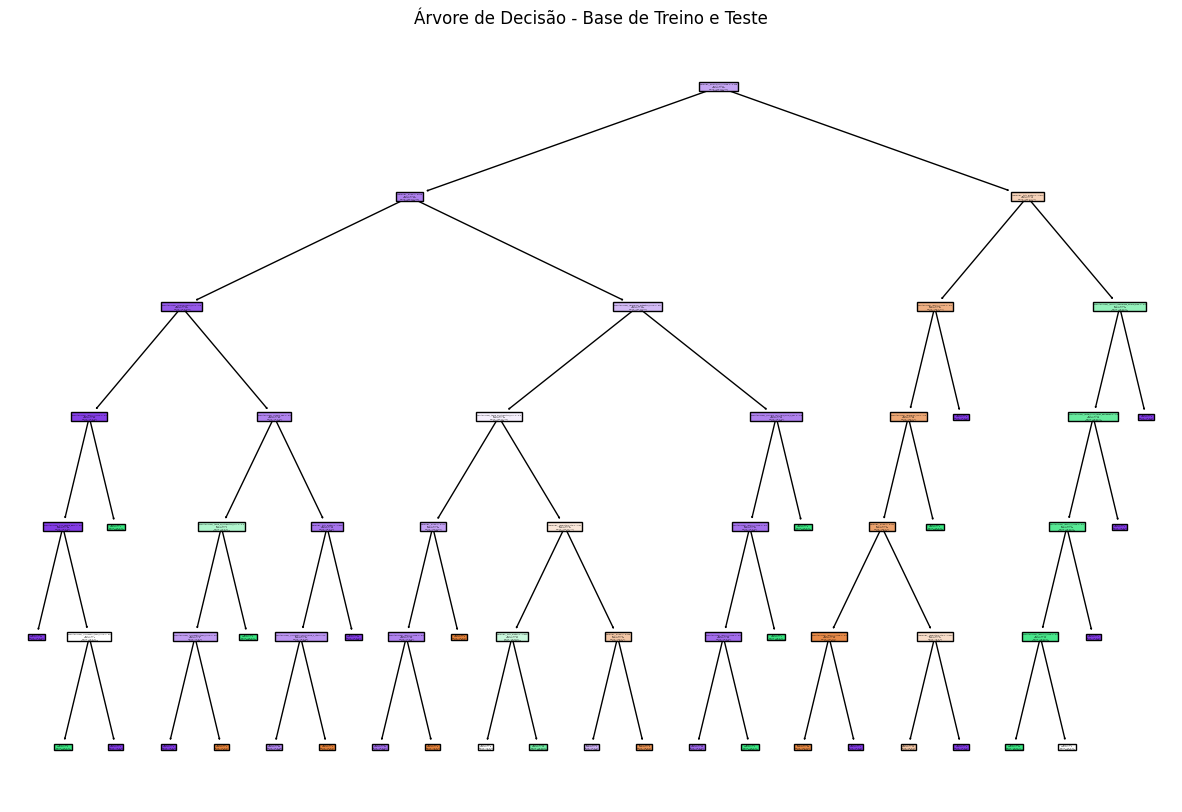

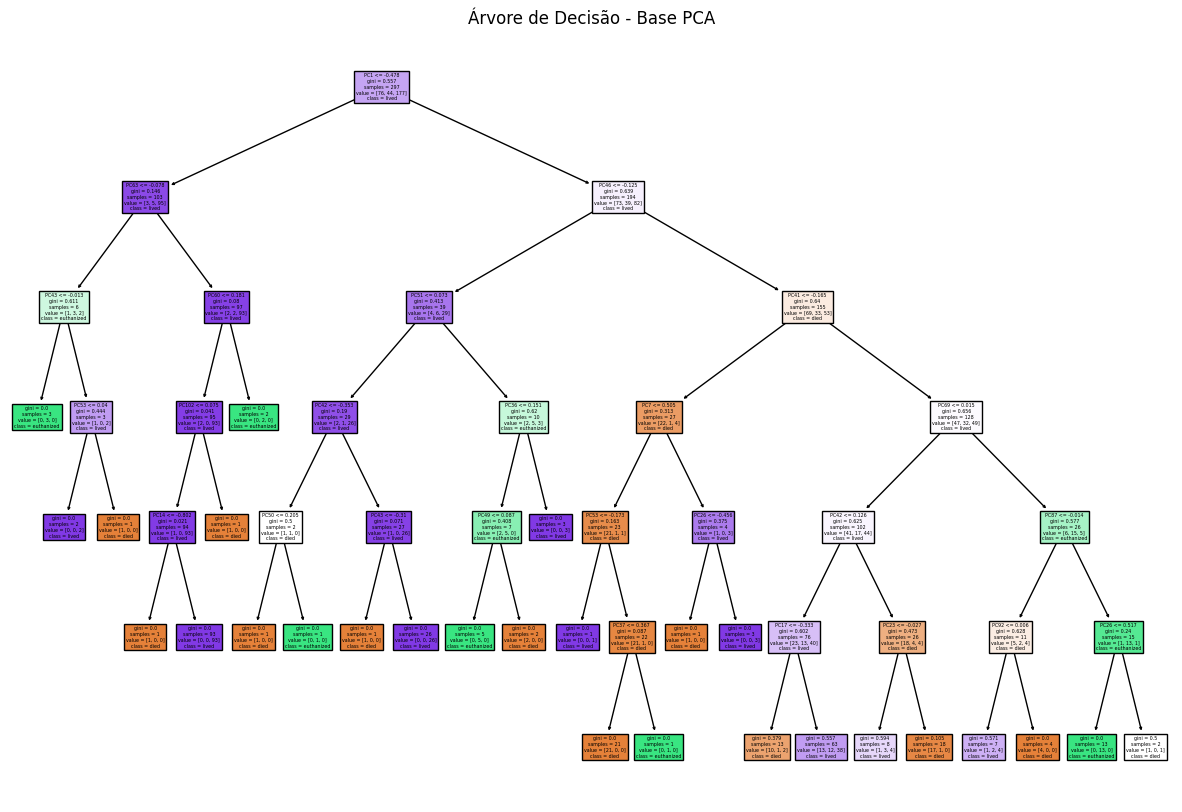

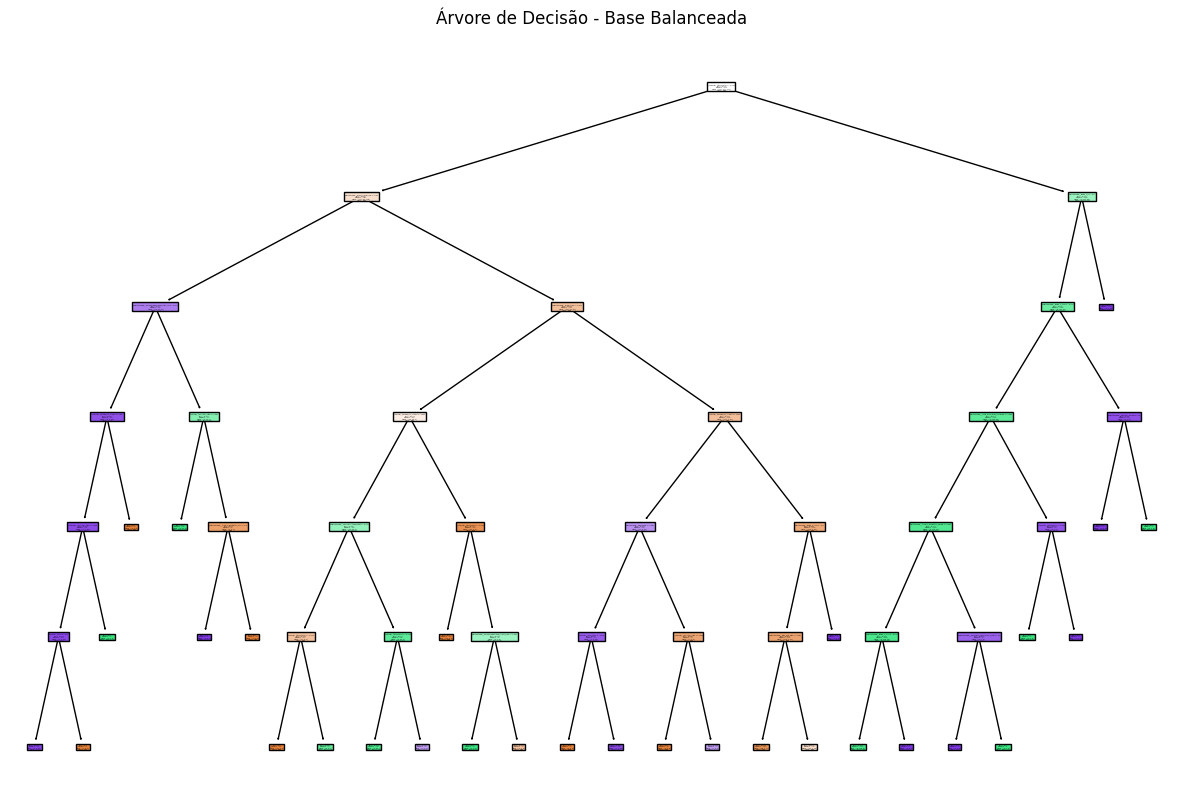

In [ ]:
# Treinar e avaliar a árvore de decisão para cada base

def treinar_e_plotar_arvore_decisao(bases_mod):
    for x_treino, y_treino, x_teste, y_teste, nome_base in bases_mod:

        # Treinar a árvore de decisão
        arvore = DecisionTreeClassifier(max_depth=6, random_state=5)
        arvore.fit(x_treino, y_treino)

        # Plotar a árvore de decisão
        plt.figure(figsize=(15, 10))
        if isinstance(x_treino, pd.DataFrame):
            feature_names = x_treino.columns
        else:
            # Se x_treino não for um DataFrame do pandas, fornecer nomes de características genéricas
            feature_names = [f'feature_{i}' for i in range(x_treino.shape[1])]

        plot_tree(arvore, filled=True, feature_names=feature_names, class_names=['died', 'euthanized', 'lived'])
        plt.title(f'Árvore de Decisão - {nome_base}')
        plt.show()

# Chamar a função para treinar e plotar a árvore de decisão para cada base
treinar_e_plotar_arvore_decisao(bases_mod)

###*K-Nearest Neighbors (KNN)*

In [ ]:
# Criar o modelo KNN (k = 3 por padrão)
knn = KNeighborsClassifier()

In [ ]:
# Função para treinar e avaliar KNN

def treinar_e_avaliar_knn(bases_mod):

    # Dicionário para armazenar as métricas de cada base
    metricas_bases = {}

    # Dicionário para armazenar as previsões e verdadeiros valores de teste
    previsoes_dict = {}

    # Iterar sobre as bases_mod
    for x_treino, y_treino, x_teste, y_teste, nome_base in bases_mod:

        # Garantir que as colunas do treino e teste estejam na mesma ordem
        colunas_ordenadas = x_treino.columns
        x_treino = x_treino[colunas_ordenadas]
        x_teste = x_teste[colunas_ordenadas]

        # Ajustar o classificador aos dados de treinamento (conversão de y para 1D)
        knn.fit(x_treino, y_treino.values.ravel())

        # Fazer previsões nos dados de teste
        previsoes_knn = knn.predict(x_teste)

        # Armazenar previsões e verdadeiros valores de teste
        previsoes_dict[nome_base] = (y_teste, previsoes_knn)

        # Calcular e imprimir o relatório de classificação
        report = classification_report(y_teste, previsoes_knn, zero_division=1)
        print(f"================ KNN - {nome_base} ================")
        print(report)
        print()

        # Realizar a validação cruzada e obter as pontuações de desempenho nos dados de treinamento
        scores_treino = cross_val_score(knn, x_treino, y_treino.values.ravel(), cv=5, scoring='accuracy')

        # Calcular as métricas na base de teste
        acuracia_teste = accuracy_score(y_teste, previsoes_knn)
        precisao_teste = precision_score(y_teste, previsoes_knn, average='weighted', zero_division=1)
        recall_teste = recall_score(y_teste, previsoes_knn, average='weighted', zero_division=1)
        f1_teste = f1_score(y_teste, previsoes_knn, average='weighted', zero_division=1)
        kappa = cohen_kappa_score(y_teste, previsoes_knn)

        # Imprimir as pontuações de desempenho em cada fold e a média
        print("Acurácia em cada fold (treinamento):", scores_treino)
        print("Acurácia na base de treinamento:", scores_treino.mean())
        print()

        # Imprimir a acurácia na base de teste
        print(f"Acurácia na base de teste ({nome_base}): {acuracia_teste}\n\n")
        print()

        # Armazenar as métricas no dicionário
        metricas_bases[nome_base] = {
            'acuracia': acuracia_teste,
            'precisao': precisao_teste,
            'recall': recall_teste,
            'f1_score': f1_teste,
            'kappa': kappa,
            'validacao_cruzada': scores_treino.mean()
        }

    return knn, metricas_bases, previsoes_dict  # Retornar o modelo treinado, as métricas e as previsões


# Chamar a função com a lista de bases_mod e obter o modelo treinado
modelo_knn, metricas_knn, previsoes_knn_dict = treinar_e_avaliar_knn(bases_mod)

================ KNN - Base de Treino e Teste ================

precision    recall  f1-score   support

           0       0.63      0.77      0.69        22
           1       0.86      0.46      0.60        13
           2       0.87      0.88      0.87        51

    accuracy                           0.79        86
   macro avg       0.78      0.71      0.72        86
weighted avg       0.80      0.79      0.79        86

Acurácia em cada fold (treinamento): [0.68333333 0.63333333 0.59322034 0.57627119 0.61016949]

Acurácia na base de treinamento: 0.6192655367231639

Acurácia na base de teste (Base de Treino e Teste): 0.7906976744186046

================ KNN - Base PCA ================

precision    recall  f1-score   support

           0       0.63      0.77      0.69        22
           1       0.86      0.46      0.60        13
           2       0.87      0.88      0.87        51

    accuracy                           0.79        86
   macro avg       0.78      0.71      0.72        86
weighted avg       0.80      0.79      0.79        86

Acurácia em cada fold (treinamento): [0.68333333 0.63333333 0.59322034 0.57627119 0.61016949]

Acurácia na base de treinamento: 0.6192655367231639

Acurácia na base de teste (Base PCA): 0.7906976744186046

================ KNN - Base Balanceada ================

precision    recall  f1-score   support

           0       0.61      1.00      0.76        22
           1       0.50      0.77      0.61        13
           2       0.93      0.55      0.69        51

    accuracy                           0.70        86
   macro avg       0.68      0.77      0.69        86
weighted avg       0.79      0.70      0.70        86

Acurácia em cada fold (treinamento): [0.75700935 0.69811321 0.78301887 0.74528302 0.82075472]

Acurácia na base de treinamento: 0.7608358314230295

Acurácia na base de teste (Base Balanceada): 0.6976744186046512

###*Regressão Logística Multinomial (RLM)*

####*Solver lbfgs*

In [ ]:
# Criar o modelo de Regressão Logística Multinomial
rlm_lbfgs = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)

In [ ]:
# Função para treinar e avaliar Regressão Logística Multinomial

def treinar_e_avaliar_rlm_lbfgs(bases_mod):

    # Dicionário para armazenar as métricas de cada base
    metricas_bases = {}

    # Dicionário para armazenar as previsões e verdadeiros valores de teste
    previsoes_dict = {}

    # Iterar sobre as bases_mod
    for x_treino, y_treino, x_teste, y_teste, nome_base in bases_mod:

        # Garantir que as colunas do treino e teste estejam na mesma ordem
        colunas_ordenadas = x_treino.columns
        x_treino = x_treino[colunas_ordenadas]
        x_teste = x_teste[colunas_ordenadas]

        # Ajustar o classificador aos dados de treinamento (conversão de y para 1D)
        rlm_lbfgs.fit(x_treino, y_treino.values.ravel())

        # Fazer previsões nos dados de teste
        previsoes_rlm_lbfgs = rlm_lbfgs.predict(x_teste)

        # Armazenar previsões e verdadeiros valores de teste
        previsoes_dict[nome_base] = (y_teste, previsoes_rlm_lbfgs)

        # Calcular e imprimir o relatório de classificação
        report = classification_report(y_teste, previsoes_rlm_lbfgs, zero_division=1)
        print(f"================ rlm_lbfgs - {nome_base} ================")
        print(report)
        print()

        # Realizar a validação cruzada e obter as pontuações de desempenho nos dados de treinamento
        scores_treino = cross_val_score(rlm_lbfgs, x_treino, y_treino.values.ravel(), cv=5, scoring='accuracy')

        # Calcular as métricas na base de teste
        acuracia_teste = accuracy_score(y_teste, previsoes_rlm_lbfgs)
        precisao_teste = precision_score(y_teste, previsoes_rlm_lbfgs, average='weighted', zero_division=1)
        recall_teste = recall_score(y_teste, previsoes_rlm_lbfgs, average='weighted', zero_division=1)
        f1_teste = f1_score(y_teste, previsoes_rlm_lbfgs, average='weighted', zero_division=1)
        kappa = cohen_kappa_score(y_teste, previsoes_rlm_lbfgs)

        # Imprimir as pontuações de desempenho em cada fold e a média
        print("Acurácia em cada fold (treinamento):", scores_treino)
        print("Acurácia na base de treinamento:", scores_treino.mean())
        print()

        # Imprimir a acurácia na base de teste
        print(f"Acurácia na base de teste ({nome_base}): {acuracia_teste}\n\n")
        print()

        # Armazenar as métricas no dicionário
        metricas_bases[nome_base] = {
            'acuracia': acuracia_teste,
            'precisao': precisao_teste,
            'recall': recall_teste,
            'f1_score': f1_teste,
            'kappa': kappa,
            'validacao_cruzada': scores_treino.mean()
        }

    return rlm_lbfgs, metricas_bases, previsoes_dict  # Retornar o modelo treinado, as métricas e as previsões


# Chamar a função com a lista de bases_mod e obter o modelo treinado
modelo_rlm_lbfgs, metricas_rlm_lbfgs, previsoes_rlm_lbfgs_dict = treinar_e_avaliar_rlm_lbfgs(bases_mod)

================ rlm_lbfgs - Base de Treino e Teste ================

precision    recall  f1-score   support

           0       0.90      0.86      0.88        22
           1       1.00      0.62      0.76        13
           2       0.88      0.98      0.93        51

    accuracy                           0.90        86
   macro avg       0.93      0.82      0.86        86
weighted avg       0.90      0.90      0.89        86

Acurácia em cada fold (treinamento): [0.7        0.7        0.62711864 0.66101695 0.74576271]

Acurácia na base de treinamento: 0.6867796610169492

Acurácia na base de teste (Base de Treino e Teste): 0.8953488372093024

================ rlm_lbfgs - Base PCA ================

precision    recall  f1-score   support

           0       0.90      0.86      0.88        22
           1       1.00      0.62      0.76        13
           2       0.88      0.98      0.93        51

    accuracy                           0.90        86
   macro avg       0.93      0.82      0.86        86
weighted avg       0.90      0.90      0.89        86

Acurácia em cada fold (treinamento): [0.7        0.7        0.62711864 0.66101695 0.74576271]

Acurácia na base de treinamento: 0.6867796610169492

Acurácia na base de teste (Base PCA): 0.8953488372093024

================ rlm_lbfgs - Base Balanceada ================

precision    recall  f1-score   support

           0       0.78      0.82      0.80        22
           1       0.80      0.92      0.86        13
           2       0.90      0.84      0.87        51

    accuracy                           0.85        86
   macro avg       0.83      0.86      0.84        86
weighted avg       0.85      0.85      0.85        86

Acurácia em cada fold (treinamento): [0.8317757  0.76415094 0.88679245 0.86792453 0.89622642]

Acurácia na base de treinamento: 0.8493740081114443

Acurácia na base de teste (Base Balanceada): 0.8488372093023255

####*Solver newton-cg*

In [ ]:
# Criar o modelo de Regressão Logística Multinomial
rlm_ncg = LogisticRegression(multi_class='multinomial', solver='newton-cg', max_iter=1000)

In [ ]:
# Função para treinar e avaliar Regressão Logística Multinomial

def treinar_e_avaliar_rlm_ncg(bases_mod):

    # Dicionário para armazenar as métricas de cada base
    metricas_bases = {}

    # Dicionário para armazenar as previsões e verdadeiros valores de teste
    previsoes_dict = {}

    # Iterar sobre as bases_mod
    for x_treino, y_treino, x_teste, y_teste, nome_base in bases_mod:

        # Garantir que as colunas do treino e teste estejam na mesma ordem
        colunas_ordenadas = x_treino.columns
        x_treino = x_treino[colunas_ordenadas]
        x_teste = x_teste[colunas_ordenadas]

        # Ajustar o classificador aos dados de treinamento (conversão de y para 1D)
        rlm_ncg.fit(x_treino, y_treino.values.ravel())

        # Fazer previsões nos dados de teste
        previsoes_rlm_ncg = rlm_ncg.predict(x_teste)

        # Armazenar previsões e verdadeiros valores de teste
        previsoes_dict[nome_base] = (y_teste, previsoes_rlm_ncg)

        # Calcular e imprimir o relatório de classificação
        report = classification_report(y_teste, previsoes_rlm_ncg, zero_division=1)
        print(f"================ rlm_ncg - {nome_base} ================")
        print(report)
        print()

        # Realizar a validação cruzada e obter as pontuações de desempenho nos dados de treinamento
        scores_treino = cross_val_score(rlm_ncg, x_treino, y_treino.values.ravel(), cv=5, scoring='accuracy')

        # Calcular as métricas na base de teste
        acuracia_teste = accuracy_score(y_teste, previsoes_rlm_ncg)
        precisao_teste = precision_score(y_teste, previsoes_rlm_ncg, average='weighted', zero_division=1)
        recall_teste = recall_score(y_teste, previsoes_rlm_ncg, average='weighted', zero_division=1)
        f1_teste = f1_score(y_teste, previsoes_rlm_ncg, average='weighted', zero_division=1)
        kappa = cohen_kappa_score(y_teste, previsoes_rlm_ncg)

        # Imprimir as pontuações de desempenho em cada fold e a média
        print("Acurácia em cada fold (treinamento):", scores_treino)
        print("Acurácia na base de treinamento:", scores_treino.mean())
        print()

        # Imprimir a acurácia na base de teste
        print(f"Acurácia na base de teste ({nome_base}): {acuracia_teste}\n\n")
        print()

        # Armazenar as métricas no dicionário
        metricas_bases[nome_base] = {
            'acuracia': acuracia_teste,
            'precisao': precisao_teste,
            'recall': recall_teste,
            'f1_score': f1_teste,
            'kappa': kappa,
            'validacao_cruzada': scores_treino.mean()
        }

    return rlm_ncg, metricas_bases, previsoes_dict  # Retornar o modelo treinado, as métricas e as previsões


# Chamar a função com a lista de bases_mod e obter o modelo treinado
modelo_rlm_ncg, metricas_rlm_ncg, previsoes_rlm_ncg_dict = treinar_e_avaliar_rlm_ncg(bases_mod)

================ rlm_ncg - Base de Treino e Teste ================

precision    recall  f1-score   support

           0       0.90      0.86      0.88        22
           1       1.00      0.62      0.76        13
           2       0.88      0.98      0.93        51

    accuracy                           0.90        86
   macro avg       0.93      0.82      0.86        86
weighted avg       0.90      0.90      0.89        86

Acurácia em cada fold (treinamento): [0.7        0.7        0.62711864 0.66101695 0.74576271]

Acurácia na base de treinamento: 0.6867796610169492

Acurácia na base de teste (Base de Treino e Teste): 0.8953488372093024

================ rlm_ncg - Base PCA ================

precision    recall  f1-score   support

           0       0.90      0.86      0.88        22
           1       1.00      0.62      0.76        13
           2       0.88      0.98      0.93        51

    accuracy                           0.90        86
   macro avg       0.93      0.82      0.86        86
weighted avg       0.90      0.90      0.89        86

Acurácia em cada fold (treinamento): [0.7        0.7        0.62711864 0.66101695 0.74576271]

Acurácia na base de treinamento: 0.6867796610169492

Acurácia na base de teste (Base PCA): 0.8953488372093024

================ rlm_ncg - Base Balanceada ================

precision    recall  f1-score   support

           0       0.78      0.82      0.80        22
           1       0.80      0.92      0.86        13
           2       0.90      0.84      0.87        51

    accuracy                           0.85        86
   macro avg       0.83      0.86      0.84        86
weighted avg       0.85      0.85      0.85        86

Acurácia em cada fold (treinamento): [0.8317757  0.76415094 0.88679245 0.86792453 0.89622642]

Acurácia na base de treinamento: 0.8493740081114443

Acurácia na base de teste (Base Balanceada): 0.8488372093023255

####*Solver saga*

In [ ]:
# Criar o modelo de Regressão Logística Multinomial
rlm_saga = LogisticRegression(multi_class='multinomial', solver='saga', max_iter=1000)

In [ ]:
# Função para treinar e avaliar Regressão Logística Multinomial

def treinar_e_avaliar_rlm_saga(bases_mod):

    # Dicionário para armazenar as métricas de cada base
    metricas_bases = {}

    # Dicionário para armazenar as previsões e verdadeiros valores de teste
    previsoes_dict = {}

    # Iterar sobre as bases_mod
    for x_treino, y_treino, x_teste, y_teste, nome_base in bases_mod:

        # Garantir que as colunas do treino e teste estejam na mesma ordem
        colunas_ordenadas = x_treino.columns
        x_treino = x_treino[colunas_ordenadas]
        x_teste = x_teste[colunas_ordenadas]

        # Ajustar o classificador aos dados de treinamento (conversão de y para 1D)
        rlm_saga.fit(x_treino, y_treino.values.ravel())

        # Fazer previsões nos dados de teste
        previsoes_rlm_saga = rlm_saga.predict(x_teste)

        # Armazenar previsões e verdadeiros valores de teste
        previsoes_dict[nome_base] = (y_teste, previsoes_rlm_saga)

        # Calcular e imprimir o relatório de classificação
        report = classification_report(y_teste, previsoes_rlm_saga, zero_division=1)
        print(f"================ rlm_saga - {nome_base} ================")
        print(report)
        print()

        # Realizar a validação cruzada e obter as pontuações de desempenho nos dados de treinamento
        scores_treino = cross_val_score(rlm_saga, x_treino, y_treino.values.ravel(), cv=5, scoring='accuracy')

        # Calcular as métricas na base de teste
        acuracia_teste = accuracy_score(y_teste, previsoes_rlm_saga)
        precisao_teste = precision_score(y_teste, previsoes_rlm_saga, average='weighted', zero_division=1)
        recall_teste = recall_score(y_teste, previsoes_rlm_saga, average='weighted', zero_division=1)
        f1_teste = f1_score(y_teste, previsoes_rlm_saga, average='weighted', zero_division=1)
        kappa = cohen_kappa_score(y_teste, previsoes_rlm_saga)

        # Imprimir as pontuações de desempenho em cada fold e a média
        print("Acurácia em cada fold (treinamento):", scores_treino)
        print("Acurácia na base de treinamento:", scores_treino.mean())
        print()

        # Imprimir a acurácia na base de teste
        print(f"Acurácia na base de teste ({nome_base}): {acuracia_teste}\n\n")
        print()

        # Armazenar as métricas no dicionário
        metricas_bases[nome_base] = {
            'acuracia': acuracia_teste,
            'precisao': precisao_teste,
            'recall': recall_teste,
            'f1_score': f1_teste,
            'kappa': kappa,
            'validacao_cruzada': scores_treino.mean()
        }

    return rlm_saga, metricas_bases, previsoes_dict  # Retornar o modelo treinado, as métricas e as previsões


# Chamar a função com a lista de bases_mod e obter o modelo treinado
modelo_rlm_saga, metricas_rlm_saga, previsoes_rlm_saga_dict = treinar_e_avaliar_rlm_saga(bases_mod)

================ rlm_saga - Base de Treino e Teste ================

precision    recall  f1-score   support

           0       0.90      0.86      0.88        22
           1       1.00      0.62      0.76        13
           2       0.88      0.98      0.93        51

    accuracy                           0.90        86
   macro avg       0.93      0.82      0.86        86
weighted avg       0.90      0.90      0.89        86

Acurácia em cada fold (treinamento): [0.7        0.7        0.62711864 0.66101695 0.74576271]

Acurácia na base de treinamento: 0.6867796610169492

Acurácia na base de teste (Base de Treino e Teste): 0.8953488372093024

================ rlm_saga - Base PCA ================

precision    recall  f1-score   support

           0       0.90      0.86      0.88        22
           1       1.00      0.62      0.76        13
           2       0.88      0.98      0.93        51

    accuracy                           0.90        86
   macro avg       0.93      0.82      0.86        86
weighted avg       0.90      0.90      0.89        86

Acurácia em cada fold (treinamento): [0.7        0.7        0.62711864 0.66101695 0.74576271]

Acurácia na base de treinamento: 0.6867796610169492

Acurácia na base de teste (Base PCA): 0.8953488372093024

================ rlm_saga - Base Balanceada ================

precision    recall  f1-score   support

           0       0.78      0.82      0.80        22
           1       0.80      0.92      0.86        13
           2       0.90      0.84      0.87        51

    accuracy                           0.85        86
   macro avg       0.83      0.86      0.84        86
weighted avg       0.85      0.85      0.85        86

Acurácia em cada fold (treinamento): [0.8317757  0.75471698 0.88679245 0.86792453 0.89622642]

Acurácia na base de treinamento: 0.8474872156586141

Acurácia na base de teste (Base Balanceada): 0.8488372093023255

###*Random Forest*

In [ ]:
# Criar o modelo de Random Forest
random_forest = RandomForestClassifier(n_estimators=100, random_state=5)

In [ ]:
# Função para treinar e avaliar Random Forest

def treinar_e_avaliar_random_forest(bases_mod):

    # Dicionário para armazenar as métricas de cada base
    metricas_bases = {}

    # Dicionário para armazenar as previsões e verdadeiros valores de teste
    previsoes_dict = {}

    # Iterar sobre as bases_mod
    for x_treino, y_treino, x_teste, y_teste, nome_base in bases_mod:

        # Garantir que as colunas do treino e teste estejam na mesma ordem
        colunas_ordenadas = x_treino.columns
        x_treino = x_treino[colunas_ordenadas]
        x_teste = x_teste[colunas_ordenadas]

        # Ajustar o classificador aos dados de treinamento (conversão de y para 1D)
        random_forest.fit(x_treino, y_treino.values.ravel())

        # Fazer previsões nos dados de teste
        previsoes_random_forest = random_forest.predict(x_teste)

        # Armazenar previsões e verdadeiros valores de teste
        previsoes_dict[nome_base] = (y_teste, previsoes_random_forest)

        # Calcular e imprimir o relatório de classificação
        report = classification_report(y_teste, previsoes_random_forest, zero_division=1)
        print(f"================ Random Forest - {nome_base} ================")
        print(report)
        print()

        # Realizar a validação cruzada e obter as pontuações de desempenho nos dados de treinamento
        scores_treino = cross_val_score(random_forest, x_treino, y_treino.values.ravel(), cv=5, scoring='accuracy')

        # Calcular as métricas na base de teste
        acuracia_teste = accuracy_score(y_teste, previsoes_random_forest)
        precisao_teste = precision_score(y_teste, previsoes_random_forest, average='weighted', zero_division=1)
        recall_teste = recall_score(y_teste, previsoes_random_forest, average='weighted', zero_division=1)
        f1_teste = f1_score(y_teste, previsoes_random_forest, average='weighted', zero_division=1)
        kappa = cohen_kappa_score(y_teste, previsoes_random_forest)

        # Imprimir as pontuações de desempenho em cada fold e a média
        print("Acurácia em cada fold (treinamento):", scores_treino)
        print("Acurácia na base de treinamento:", scores_treino.mean())
        print()

        # Imprimir a acurácia na base de teste
        print(f"Acurácia na base de teste ({nome_base}): {acuracia_teste}\n\n")
        print()

        # Armazenar as métricas no dicionário
        metricas_bases[nome_base] = {
            'acuracia': acuracia_teste,
            'precisao': precisao_teste,
            'recall': recall_teste,
            'f1_score': f1_teste,
            'kappa': kappa,
            'validacao_cruzada': scores_treino.mean()
        }

    return random_forest, metricas_bases, previsoes_dict  # Retornar o modelo treinado, as métricas e as previsões


# Chamar a função com a lista de bases_mod e obter o modelo treinado
modelo_random_forest, metricas_random_forest, previsoes_random_forest_dict = treinar_e_avaliar_random_forest(bases_mod)

================ Random Forest - Base de Treino e Teste ================

precision    recall  f1-score   support

           0       1.00      1.00      1.00        22
           1       1.00      1.00      1.00        13
           2       1.00      1.00      1.00        51

    accuracy                           1.00        86
   macro avg       1.00      1.00      1.00        86
weighted avg       1.00      1.00      1.00        86

Acurácia em cada fold (treinamento): [0.68333333 0.73333333 0.66101695 0.77966102 0.6779661 ]

Acurácia na base de treinamento: 0.7070621468926553

Acurácia na base de teste (Base de Treino e Teste): 1.0

================ Random Forest - Base PCA ================

precision    recall  f1-score   support

           0       1.00      0.95      0.98        22
           1       1.00      1.00      1.00        13
           2       0.98      1.00      0.99        51

    accuracy                           0.99        86
   macro avg       0.99      0.98      0.99        86
weighted avg       0.99      0.99      0.99        86

Acurácia em cada fold (treinamento): [0.65       0.66666667 0.62711864 0.59322034 0.61016949]

Acurácia na base de treinamento: 0.6294350282485877

Acurácia na base de teste (Base PCA): 0.9883720930232558

================ Random Forest - Base Balanceada ================

precision    recall  f1-score   support

           0       1.00      1.00      1.00        22
           1       1.00      1.00      1.00        13
           2       1.00      1.00      1.00        51

    accuracy                           1.00        86
   macro avg       1.00      1.00      1.00        86
weighted avg       1.00      1.00      1.00        86

Acurácia em cada fold (treinamento): [0.80373832 0.85849057 0.91509434 0.90566038 0.94339623]

Acurácia na base de treinamento: 0.8852759654381943

Acurácia na base de teste (Base Balanceada): 1.0

## **Avaliação dos Modelos**

###*Lista das métricas e dos modelos*

In [ ]:
# Consolidar todas as métricas em um único dicionário
metricas_bases = {
    "Dummy": metricas_dummy,
    "Árvore de Decisão": metricas_arvore,
    "KNN": metricas_knn,
    "RLM - rlm_lbfgs": metricas_rlm_lbfgs,
    "RLM - ncg": metricas_rlm_ncg,
    "RLM - saga": metricas_rlm_saga,
    "Random Forest": metricas_random_forest
}

In [ ]:
# Lista de modelos para comparação
modelos = [
    ("Dummy", modelo_dummy),
    ("Árvore de Decisão", modelo_arvore),
    ("KNN", modelo_knn),
    ("RLM lbfgs", modelo_rlm_lbfgs),
    ("RLM ncg", modelo_rlm_ncg),
    ("RLM saga", modelo_rlm_saga),
    ("Random Forest", modelo_random_forest)
]

###*Acurácia, Precisão, Recall, F1_score e Kappa*

In [ ]:
# Função para consolidar as métricas em um DataFrame
def consolidar_metricas(modelos, metricas_bases):
    metricas_consolidadas = []

    for nome_modelo, metricas_modelo in metricas_bases.items():
        for nome_base, metricas in metricas_modelo.items():
            metricas_convertidas = {k: (v.item() if isinstance(v, np.generic) else v) for k, v in metricas.items()}
            metricas_convertidas['Modelo'] = nome_modelo
            metricas_convertidas['Base'] = nome_base
            metricas_consolidadas.append(metricas_convertidas)

    return pd.DataFrame(metricas_consolidadas)

In [ ]:
# Consolidar as métricas em um DataFrame
df_metricas = consolidar_metricas(None, metricas_bases)

# Reordenar as colunas do DataFrame
df_metricas = df_metricas[['Modelo', 'Base', 'acuracia', 'precisao', 'recall', 'f1_score', 'kappa']]

In [ ]:
# Exibir o DataFrame de métricas com a tabela formatada
print(tabulate(df_metricas.values, df_metricas.columns, floatfmt=".2f"))

Modelo             Base                      acuracia    precisao    recall    f1_score    kappa
-----------------  ----------------------  ----------  ----------  --------  ----------  -------
Dummy              Base de Treino e Teste        0.59        0.76      0.59        0.44     0.00
Dummy              Base PCA                      0.59        0.76      0.59        0.44     0.00
Dummy              Base Balanceada               0.26        0.81      0.26        0.10     0.00
Árvore de Decisão  Base de Treino e Teste        0.77        0.76      0.77        0.75     0.55
Árvore de Decisão  Base PCA                      0.81        0.80      0.81        0.81     0.66
Árvore de Decisão  Base Balanceada               0.84        0.84      0.84        0.84     0.72
KNN                Base de Treino e Teste        0.79        0.80      0.79        0.79     0.62
KNN                Base PCA                      0.79        0.80      0.79        0.79     0.62
KNN                Base Balanceada               0.70        0.79      0.70        0.70     0.54
RLM - rlm_lbfgs    Base de Treino e Teste        0.90        0.90      0.90        0.89     0.80
RLM - rlm_lbfgs    Base PCA                      0.90        0.90      0.90        0.89     0.80
RLM - rlm_lbfgs    Base Balanceada               0.85        0.85      0.85        0.85     0.74
RLM - ncg          Base de Treino e Teste        0.90        0.90      0.90        0.89     0.80
RLM - ncg          Base PCA                      0.90        0.90      0.90        0.89     0.80
RLM - ncg          Base Balanceada               0.85        0.85      0.85        0.85     0.74
RLM - saga         Base de Treino e Teste        0.90        0.90      0.90        0.89     0.80
RLM - saga         Base PCA                      0.90        0.90      0.90        0.89     0.80
RLM - saga         Base Balanceada               0.85        0.85      0.85        0.85     0.74
Random Forest      Base de Treino e Teste        1.00        1.00      1.00        1.00     1.00
Random Forest      Base PCA                      0.99        0.99      0.99        0.99     0.98
Random Forest      Base Balanceada               1.00        1.00      1.00        1.00     1.00

Resumo da análise dos modelos:

* **Dummy**: Representa um classificador aleatório, com performance próxima a 0.5 em diversas métricas. Utilizado apenas como baseline.

* **Árvore de Decisão**: Performance razoável, porém inferior aos melhores modelos.

* **KNN**: Resultados próximos à Árvore de Decisão, mas ainda aquém do ideal.

* **RLM (com diferentes solvers)**: Atingiu bom desempenho, com métricas acima de 0.85, indicando boa capacidade preditiva.

* **Random Forest**: Apresentou performance excepcional, com métricas próximas ou iguais a 1, sugerindo um ajuste excelente aos dados. Apesar do excelente desempenho, a suspeita de overfitting é alta, dada a performance "perfeita". É crucial realizar validação cruzada robusta e testes em um conjunto de dados independente para confirmar a generalização do modelo.

###*Matriz de Confusão*

Neste trabalho, o problema de classificação é multiclasse. Portanto, a matriz de confusão não é 2x2 e sim 3x3:

![picture](https://drive.google.com/uc?id=1IaY4IDZd9_P9mlRpfivVyl-0hZ9ooh8K)


*   Verdadeiro Positivo (VP): é o valor da previsão correta;
*   Verdadeiro Negativo (VN): são a soma das classes que não envolvem a Classe 1;
*  Falso Positivo (FP): são a soma das classes erroneamente previstas como Classe 1;
*  Falso Negativo (FN): são a soma das classes previstas como outras classes que deveriam ter sido previstas como Classe 1.

Esse processo é repetido para todas as classes, e os valores totais de VP, FP, VN e FN são calculados em média para obter métricas como recall.


Neste projeto, **os piores erros são os Falsos Positivo (FP)**. Isso porque prever de forma equivocada que o cavalo “viveu”, enquanto na verdade ele “morreu” ou “fez eutanásia”, é um erro grave, que impedirá tomar medidas adequadas para cuidar do animal. Já classificar que um cavalo “morreu” ou “fez eutanásia” uma vez que ele “viveu” é bem menos problemático (Falsos Negativos: FN).

####*Dummy*

As matrizes de confusão apresentadas demonstram claramente que o modelo Dummy é muito básico e tende a prever a classe majoritária.  

Na base original e na base com PCA, o modelo previu que todas as instâncias na classe 2, que é a classe majoritária. Isso indica uma previsão tendenciosa e não informativa, já que não reflete a capacidade do modelo de aprender padrões nos dados, mas sim a distribuição desigual das classes.

Já na base balanceada, em que todas as classes foram equilibradas, o modelo Dummy, acabou prevendo que todas as instâncias pertenciam à classe 0, ignorando completamente as outras classes. Isso ocorre porque, com as classes balanceadas, não há mais uma classe dominante para o modelo se basear, levando-o a fazer previsões simplistas e incorretas.


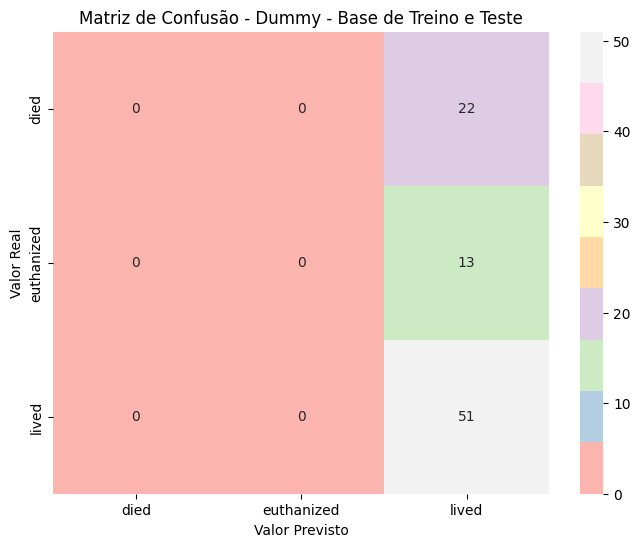

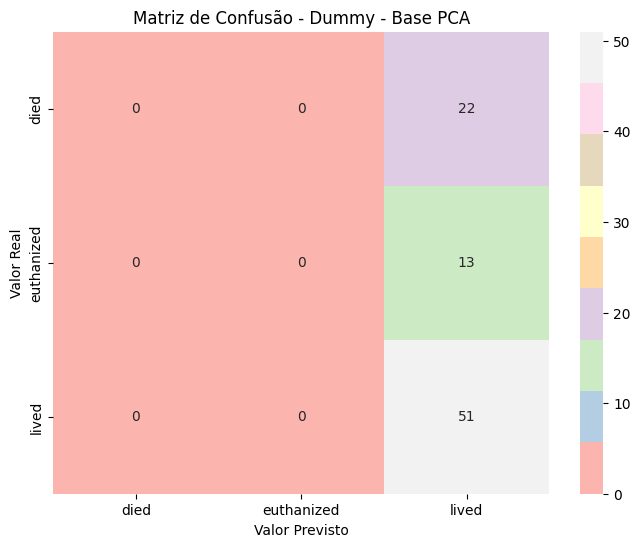

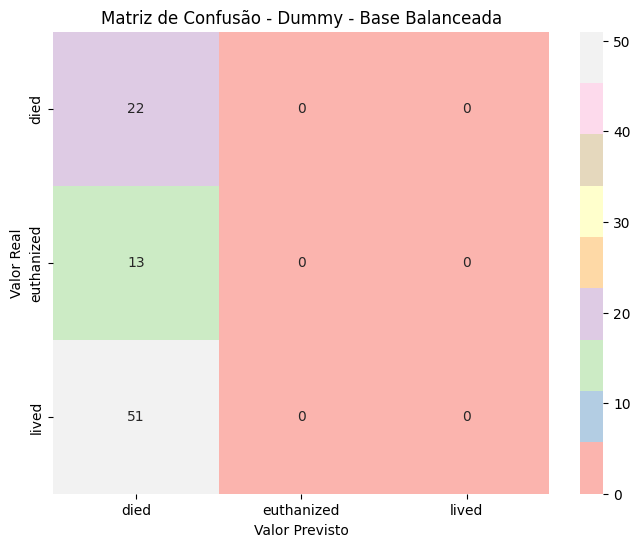

In [ ]:
# Plotar a matriz de confusão para cada base após o treinamento
for nome_base, (y_teste, previsoes_dummy) in previsoes_dummy_dict.items():
    plot_confusion_matrix(y_teste, previsoes_dummy, classes=['died', 'euthanized', 'lived'], title=f'Matriz de Confusão - Dummy - {nome_base}')

####*Árvore de Decisão*

No modelo Árvore de Decisão, a **base balanceada apresenta o melhor desempenho**. Considerando a criticidade dos falsos positivos, esta base classificou em menor número "lived" como "died" (5 ocorrências).

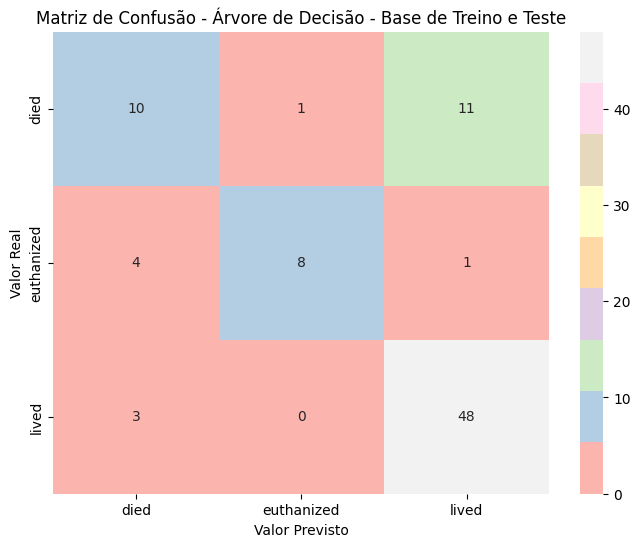

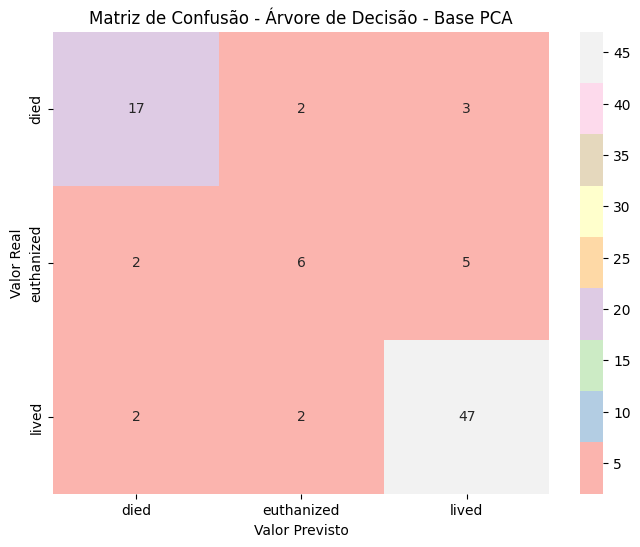

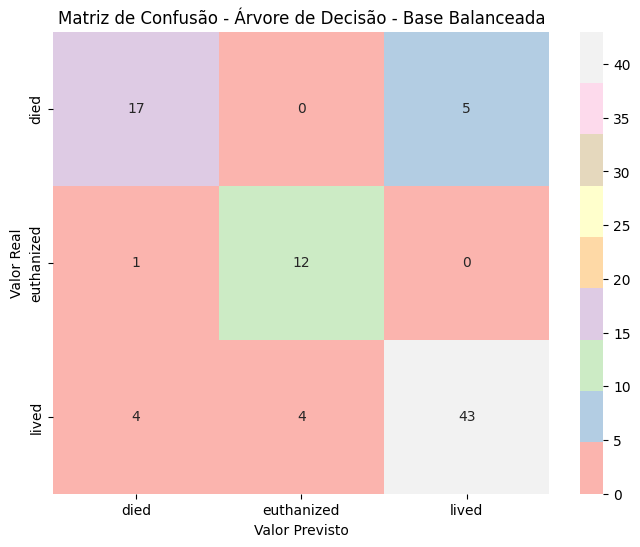

In [ ]:
# Plotar a matriz de confusão para cada base após o treinamento
for nome_base, (y_teste, previsoes_arvore) in previsoes_arvore_dict.items():
    plot_confusion_matrix(y_teste, previsoes_arvore, classes=['died', 'euthanized', 'lived'], title=f'Matriz de Confusão - Árvore de Decisão - {nome_base}')

####*KNN*

No modelo KNN, a base apenas com o pré-processamento e a base com o PCA apresentam exatamente a mesma matriz de confusão, indicando que a aplicação do PCA não resultou em mudanças significativas na capacidade preditiva.

A escolha da melhor base foi direcionada em acertar a classificação "died": **a base balanceada se destaca**.

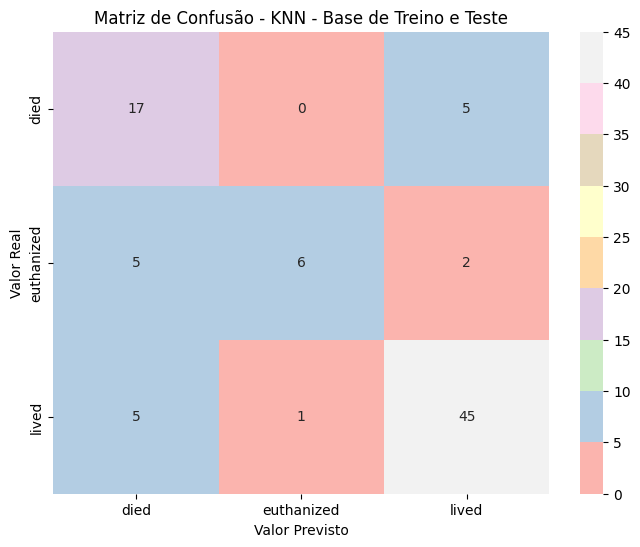

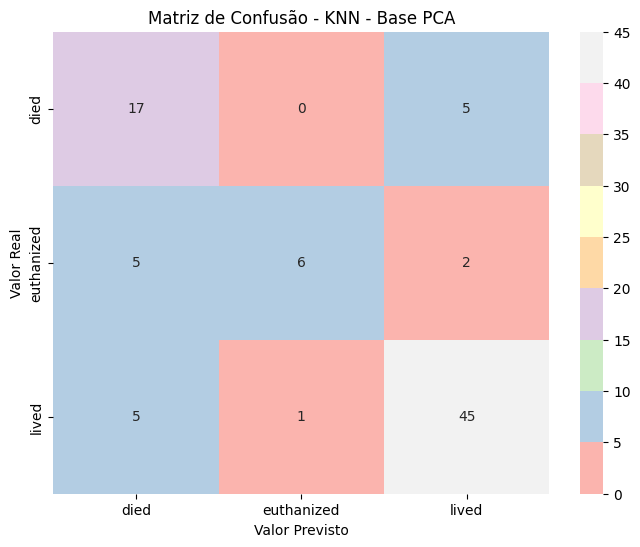

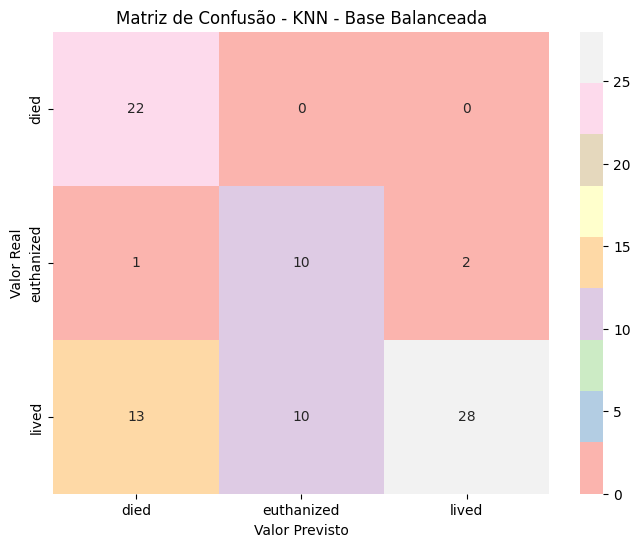

In [ ]:
# Plotar a matriz de confusão para cada base após o treinamento
for nome_base, (y_teste, previsoes_knn) in previsoes_knn_dict.items():
    plot_confusion_matrix(y_teste, previsoes_knn, classes=['died', 'euthanized', 'lived'], title=f'Matriz de Confusão - KNN - {nome_base}')

####*Regressão Logística Multinomial (RLM)*

Após analisar as matrizes de confusão do modelo RLM com os solvers LBFGS, Newton-CG e Saga, nas bases balanceada, PCA e pré-processada, é possível chegar as considerações:

* **Performance Consistente entre Solvers**: O RLM apresentou desempenho muito similar, com matrizes de confusão praticamente idênticas, independentemente do solver utilizado (LBFGS, Newton-CG ou Saga). Isso sugere que, para este problema específico e com essa base de dados, a escolha do solver não impacta significativamente a performance do modelo.

* **Bases Balanceada como Melhor Opção**: Apesar da acurácia ser mais baixa que as outras bases, a base balanceada apresenta um menor número de falsos positivos (5).

Dado que o desempenho foi similar entre os solvers, a escolha se torna menos crítica. No entanto, pode-se considerar algumas nuances:

* **Saga**: É geralmente recomendado para datasets grandes, o que não é o caso.
* **LBFGS**: Adequado para problemas com um número relativamente pequeno de features.
* **Newton-CG**: Pode ser mais eficiente que o LBFGS em algumas situações, mas exige que a função de custo seja duas vezes diferenciável.

Considerando a situação, o LBFGS se mostra uma escolha sólida, por ser adequado para datasets menores e frequentemente apresentar bom desempenho em problemas de classificação.

Em resumo, **a combinação RLM com solver LBFGS na base de dados balanceada parece ser a mais adequada para este problema**, equilibrando a minimização do erro crítico com a interpretabilidade do modelo e a eficiência computacional.

#####*RLM - Solver lbfgs*

Assim como no KNN, a base apenas com o pré-processamento e a base com o PCA apresentam matrizes de confusão idênticas para o RLM-LBFGS. Portanto, a aplicação do PCA não foi significativa.

Como a prioridade do problema é ter maior precisão na classe "died", **a base balanceada apresenta melhor desempenho**, apesar dos falsos positivos "lived" (menor impacto).

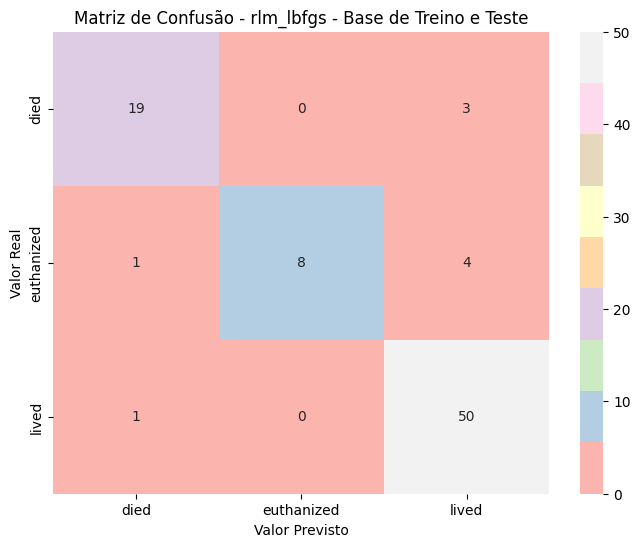

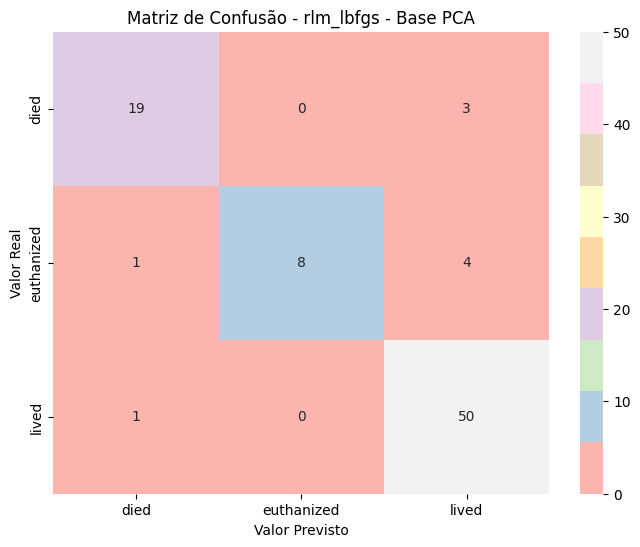

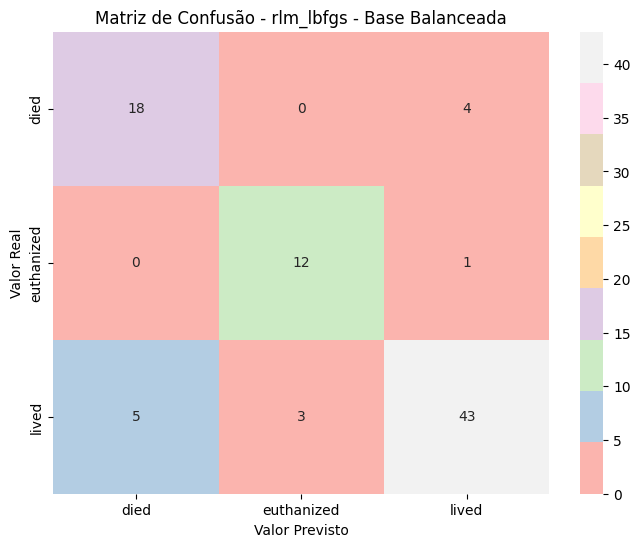

In [ ]:
# Plotar a matriz de confusão para cada base após o treinamento
for nome_base, (y_teste, previsoes_rlm_lbfgs) in previsoes_rlm_lbfgs_dict.items():
    plot_confusion_matrix(y_teste, previsoes_rlm_lbfgs, classes=['died', 'euthanized', 'lived'], title=f'Matriz de Confusão - rlm_lbfgs - {nome_base}')

#####*RLM - Solver newton-cg*

Novamente, assim como no KNN e no solver LBFGS do RLM, as matrizes de confusão são idênticas para as bases com o pré-processamento e com o PCA.

Como há a necessidade da precisão em "died", **a base balanceada é considerada a base com melhor desempenho**, uma vez que classificar um cavalo viverá enquanto ele morrerá ou será eutanaziado é muito pior do que classificar que o cavalo morretá ou será eutanaziado, enquanto, na verdade, ele viverá.

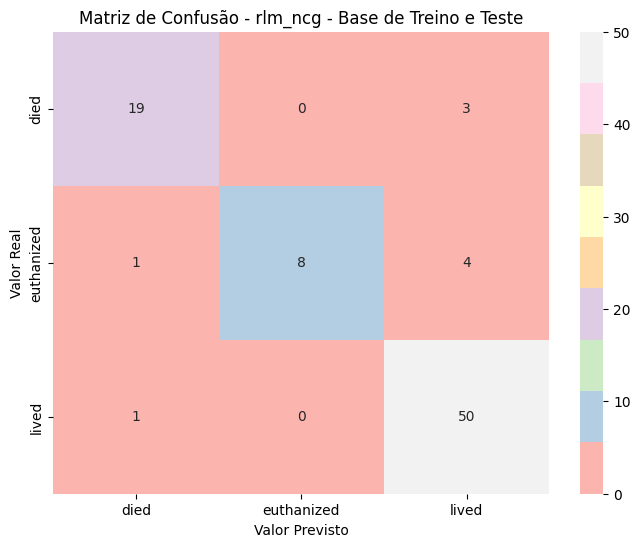

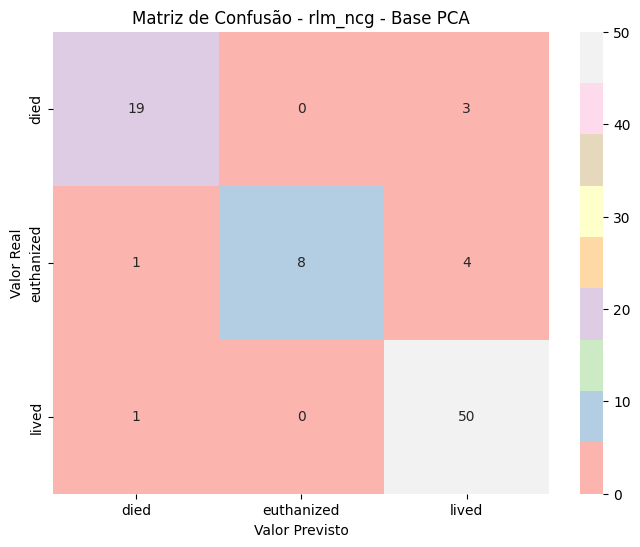

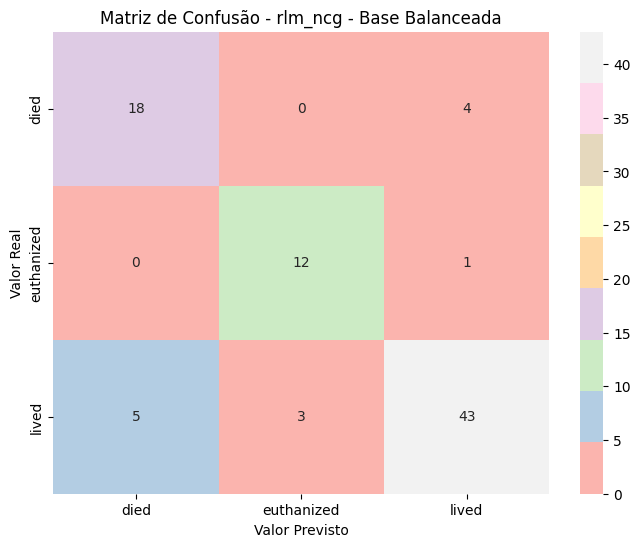

In [ ]:
# Plotar a matriz de confusão para cada base após o treinamento
for nome_base, (y_teste, previsoes_rlm_ncg) in previsoes_rlm_ncg_dict.items():
    plot_confusion_matrix(y_teste, previsoes_rlm_ncg, classes=['died', 'euthanized', 'lived'], title=f'Matriz de Confusão - rlm_ncg - {nome_base}')

#####*RLM - Solver saga*

Na aplicação do otimizador SAGA, o PCA também não teve efeito significativo.

A gravidade do erro crítico de classificar um cavalo vivo como morto ou sacrificado supera a necessidade de um pequeno aumento na precisão das outras classes, e com isso, a **base balanceada apresente melhor precisão**.

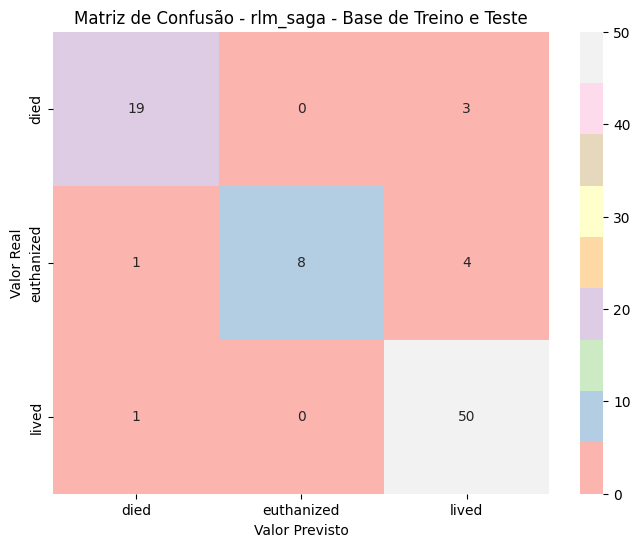

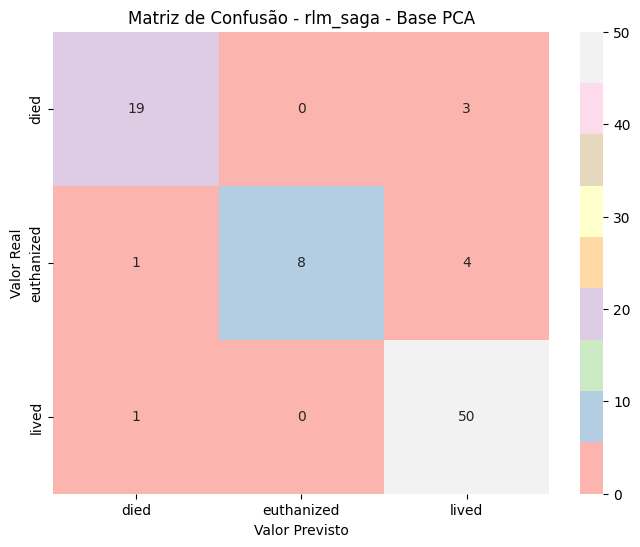

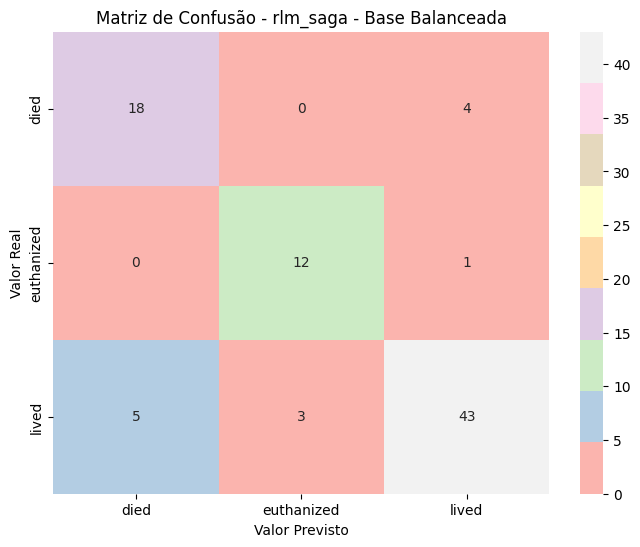

In [ ]:
# Plotar a matriz de confusão para cada base após o treinamento
for nome_base, (y_teste, previsoes_rlm_saga) in previsoes_rlm_saga_dict.items():
    plot_confusion_matrix(y_teste, previsoes_rlm_saga, classes=['died', 'euthanized', 'lived'], title=f'Matriz de Confusão - rlm_saga - {nome_base}')

####*Random Forest*

O Random Forest apresentou o melhor desempenho dentre todos os modelos testados, eliminando completamente o erro crítico. Tanto a base balanceada quanto a pré-processada eliminaram completamente o erro crítico: nenhum cavalo "lived" foi classificado incorretamente.

**Um resultado "perfeito", como o obtido pelo Random Forest nas três bases de dados, levanta imediatamente a suspeita de overfitting**, principalmente em problemas reais e com datasets relativamente pequenos.

Overfitting ocorre quando o modelo aprende "demais" os padrões dos dados de treino, incluindo ruídos e particularidades, e perde a capacidade de generalizar para dados não vistos.

Por conta disso, **a recomendação será a base com PCA**. A redução marginal no desempenho (Acurácia: 0.99) ainda é muito alta e aceitável, especialmente considerando a Kappa de 0.98. Além de que a aplicação do PCA ajuda a simplificar o modelo e pode melhorar a generalização.


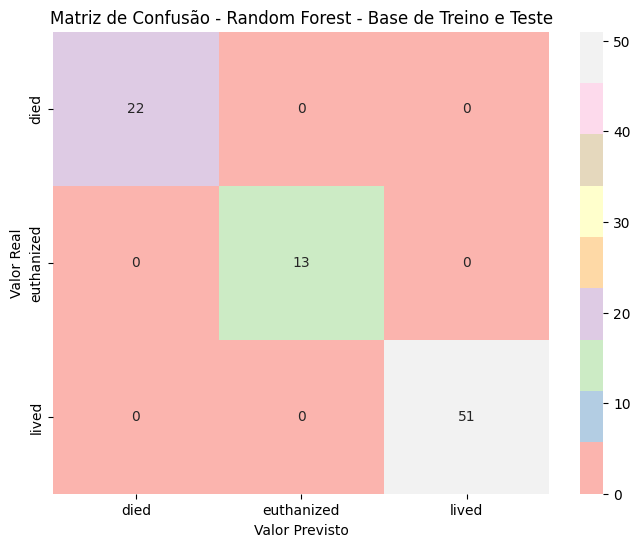

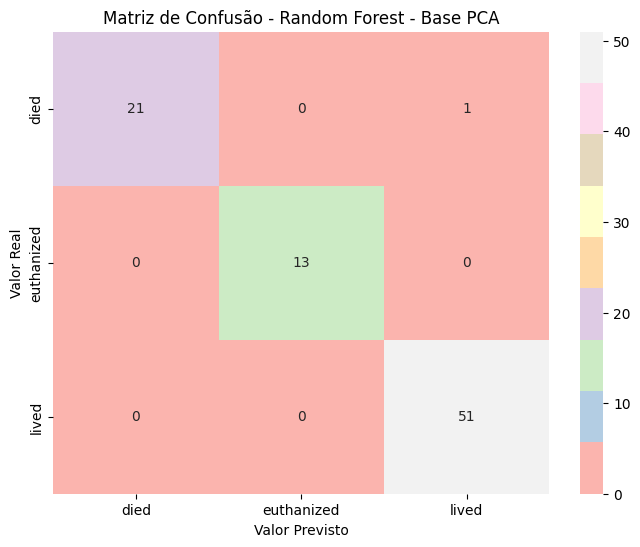

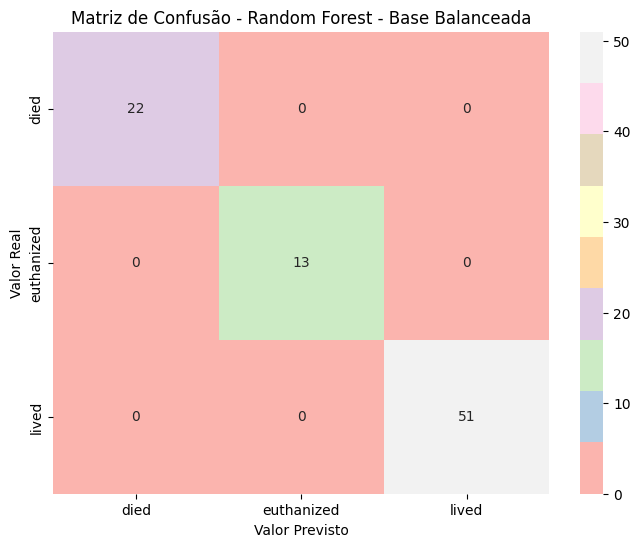

In [ ]:
# Plotar a matriz de confusão para cada base após o treinamento
for nome_base, (y_teste, previsoes_random_forest) in previsoes_random_forest_dict.items():
    plot_confusion_matrix(y_teste, previsoes_random_forest, classes=['died', 'euthanized', 'lived'], title=f'Matriz de Confusão - Random Forest - {nome_base}')

## **Conclusão**

Considerando a prioridade de minimizar falsos positivos e a análise detalhada dos resultados de cada modelo, a melhor escolha é: **Random Forest utilizando a base com PCA**.

***Justificativa:***

**Desempenho**: O modelo Random Forest com base PCA mostra métricas de precisão, recall, F1-score e acurácia extremamente altas.

**Prevenção de Overfitting**: A redução da dimensionalidade via PCA ajuda a simplificar o modelo e previne overfitting, como indicado pela alta acurácia em dados de teste.

***Observações:***

A escolha da base com PCA foi importante para o sucesso do Random Forest neste caso, demonstrando a importância do pré-processamento de dados para otimizar o desempenho do modelo.

***Próximos passos:***

* **Implementação e Monitoramento**: implementar o modelo em um ambiente de produção e estabelecer um processo de monitoramento para acompanhar seu  desempenho ao longo do tempo para garantir que ele continue a funcionar de forma eficaz e fazer ajustes conforme necessário.

* **Análise de Importância das Características**: Analisar a importância das características (features) fornecidas pelo modelo Random Forest para entender quais atributos estão mais contribuindo para as previsões. Isso pode fornecer insights valiosos e permitir simplificar o modelo sem perder desempenho.

* **Ajuste de Hiperparâmetros**: Realizar uma busca de hiperparâmetros (por exemplo, Grid Search ou Random Search) para encontrar a combinação ideal de parâmetros do Random Forest, como o número de árvores, a profundidade máxima, o número mínimo de amostras por folha, entre outros.

* **Regularização**: Realizar técnicas de regularização como L1 (Lasso), L2 (Ridge) ou Dropout (em redes neurais). Essa técnica limita a complexidade do modelo, evitando que ele se ajuste muito aos dados de treino.

* **Explorar outros Modelos e Técnicas de Ensemble**: Embora o Random Forest tenha apresentado o melhor desempenho (técnica de ensemble Bagging), seria interessante considerar testar outros modelos avançados, como Gradient Boosting Machines (GBM), Support Vector Machines (SVM) ou modelos baseados em redes neurais, se houver a possibilidade de mudanças nos dados ou aumento da complexidade do problema. Isso pode levar a um modelo ainda mais robusto e preciso no longo prazo.

* **Mais dados**: Se fosse possível, coletar mais dados aumentaria a robustez do modelo e reduziria o overfitting.